In [598]:
import numpy as np
import xarray as xr
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature
import pandas as pd
from sklearn.decomposition import pca
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from scipy import interpolate
import seaborn as sns

from MapXtremePCIC import MapXtremePCIC

from datacube import read_data
from operators import *
from preprocessing import *
from eof import *
from gridding import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Use a wildcard and specify the path of the ensemble members for the design value

In [599]:
#PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/daily/processed/hdd/*ann_ta.nc'
PATH = '/home/nannau/Desktop/ensembles/jan1.0p/*'

Read in ensembles and put in a xarray dataset

In [600]:
ds = read_data(PATH)
dv_field = ds['dv'].values.copy()

tas


load the land mask

In [601]:
mask = load_land_mask('./mask.nc')

Check for any NaN values, and if there are any in the ensemble, disqualify that grid cell from the rest of the analysis. Combine the land mask and the nan mask using `logical disjoint`.


In [602]:
mask_master = mask_land_and_nan(dv_field, mask)

Flatten the master mask into ensemble space to reference the grid cell number that the mask corresponds to. 

In [603]:
idx = mask_land_and_nan_ens_index(mask_master)

Calculate the areas of each grid cell.

In [604]:
area = frac_grid_area(ds['dv'])
area_relevent_grid_cells = area.reshape(1, -1)
area_relevent_grid_cells.shape

(1, 20150)

Flatten the ensemble data cube design values.

In [605]:
ens = ens_flat(ds['dv'].values)

Calculate the mean of each grid cell along the ensemble members.

In [606]:
mean = ens.mean(axis=0).reshape(1, -1)

Weight each design value in the ensemble by its corresponding grid cell area, then subtract the mean. This corresponds to 
$$X' = \left(I_n - \frac{1}{n}1_n\right)X$$
and
$$X'_w = X' W$$
in Chao's methods.

In [607]:
corr_ens = ens*area_relevent_grid_cells - mean
                                                  

The next step is to calculate the first $N$ eof's that explain up to 95% of the variance. Then take only the relavent grid cells by the master mask's ensemble representation, with indices in `idx`

In [608]:
ens_eof = ens_to_eof(corr_ens)[:, idx]
print("EOF Shape: ", ens_eof.shape)

EOF Shape:  (27, 9022)


Extend the rotated latitude and longitude into the ensemble space, assigning a lat and lon to each grid cell in the ensemble array. Also correct the rotated pole configuration into a non-rotated reference frame.

In [609]:
rlon = ds['rlon'].values.copy()
rlat = ds['rlat'].values.copy()

lat_lon_ens = correct_extend_rlat_and_rlon_to_ens(rlat, rlon)[idx, :]

Read in the MSC query observations, and zup together the latitude and longitudes of the stations where the observations were found.

In [610]:
df = pd.read_csv('jan_1st_percentile_1991_2016', index_col=None)
lat_lon_obs = list(zip(df['lat'], df['lon']))

Using the euclidean distance, find the index location of the grid in the ensemble space that is closest to the observation. 

In [614]:
df['nearest_grid'] = euclidean_dist_index(lat_lon_obs, lat_lon_ens)

(26, 583) (583,)
Model score: 0.6227729511308224
(26, 9022)
(9022,)


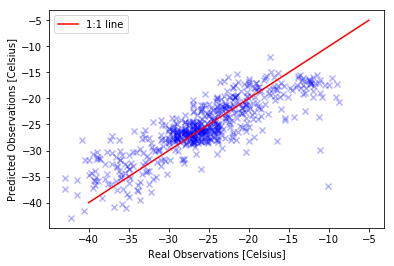

In [537]:
ndf = df['quantile'].groupby(df['nearest_grid']).mean()
match_ens_obs_idx = np.asarray(ndf.index)

match_obs_ens = np.array(ndf)*area_relevent_grid_cells[:, match_ens_obs_idx]
match_model_ens = ens_eof[:, match_ens_obs_idx]

print(match_model_ens.shape, match_obs_ens[0, :].shape)

model = regress_eof(match_model_ens.T, match_obs_ens[0, :])

print(ens_eof.shape)

predictions = predict_dv(model, ens_eof.T)

print(predictions.shape)

x = np.arange(-40, -5.0, 0.001)

plt.scatter(.10*match_obs_ens/area_relevent_grid_cells[:, match_ens_obs_idx],
            .10*predictions[match_ens_obs_idx]/area_relevent_grid_cells[:, match_ens_obs_idx], 
            marker='x', 
            color='blue',
            alpha=0.3)
plt.plot(x, x, color='r', label='1:1 line')
plt.legend()
plt.xlabel('Real Observations [Celsius]')
plt.ylabel('Predicted Observations [Celsius]')
plt.savefig('first_predictions_using_obs')

In [343]:
# gridder

df = pd.read_csv('jan_1st_percentile_1991_2016', index_col=None)
obs_lat, obs_lon = df['lat'], df['lon']



idx_list = []
for i, data in enumerate(obs_lat):
    idx_list.append(
        find_nearest(rlat_ens, 
                     rlon_ens, 
                     (obs_lat[i], 
                      obs_lon[i])
                    )
    )
    
# reminder to self: x and y are the indices in rlat and rlon where 
# the observations land on. We need to get the model values 
# from these points from the EOF'd ensemble array!
x, y = zip(*idx_list)
df['lonidx'], df['latidx'] = np.asarray(x), np.asarray(y)
df
ndf = df.groupby(['lonidx', 'latidx'])[['lat', 'lon', 'lonidx', 'latidx', 'quantile']].mean()
y, x = ndf['lonidx'].values, ndf['latidx'].values


y, x

#ens[idx_arr[x, y]]
ens_matched_cells = np.isin(mask_corr_dict['idx'], idx_arr[x, y])
np.where(ens_matched_cells == True)[0].shape, ndf.shape, df.shape
ndf['new_lat']
#idx_arr[x, y], mask_corr_dict['idx']
#mask_corr_dict['idx'], np.sort(idx_arr[y, x])
#idx_list
#obs = df['quantile']*area_flat[ens_matched_cells][:, 0]

lat         lon  lonidx  latidx    quantile
lonidx latidx                                                   
0      86      51.935800 -131.016000       0      86   -5.000000
       89      53.111433 -131.821667       0      89  -23.666667
       90      53.407800 -132.361000       0      90  -24.030000
       91      53.961400 -131.980000       0      91  -20.500000
       92      54.481200 -130.762000       0      92  -33.666667
       97      56.666700 -131.100000       0      97 -180.000000
       104     59.577700 -135.037333       0     104 -208.333333
       105     60.113600 -134.078667       0     105 -295.333333
       106     60.709750 -135.048000       0     106 -311.500000
       107     60.878940 -136.100600       0     107 -325.000000
       108     61.366700 -139.050000       0     108 -360.000000
       110     62.234925 -135.952250       0     110 -349.500000
       111     62.830000 -137.311000       0     111 -338.000000
       113     63.605450 -136.695000       0     113 -373.000000
       114     64.052000 -139.127500       0     114 -370.000000
       115     64.453900 -138.216000       0     115 -340.000000
       117     65.360300 -138.305000       0     117 -430.000000
       119     66.369400 -136.718000       0     119 -330.000000
       121     66.981100 -136.218000       0     121 -313.000000
       122     67.516333 -138.179333       0     122 -390.000000
       123     68.223300 -135.006000       0     123 -370.000000
       124     68.310450 -133.500000       0     124 -354.500000
       125     68.848150 -135.359500       0     125 -357.500000
       126     69.343667 -135.397667       0     126 -371.333333
       127     69.604200 -136.366250       0     127 -358.000000
1      90      53.492800 -130.638500       1      90  -28.000000
       92      54.253533 -130.471667       1      92  -37.333333
       97      56.652500 -130.446000       1      97 -175.000000
       121     67.179200 -130.228000       1     121 -430.000000
2      96      55.936100 -129.985000       2      96 -106.000000
...                  ...         ...     ...     ...         ...
153    73      46.029450  -63.571400     153      73 -157.500000
       74      46.454450  -63.450150     153      74 -167.500000
       83      50.283300  -63.600000     153      83 -256.000000
       116     64.957800  -63.577800     153     116 -311.000000
154    68      43.932200  -60.009400     154      68  -85.000000
       70      44.816700  -62.333300     154      70 -120.000000
       71      45.172786  -62.254600     154      71 -140.977143
       72      45.598340  -62.550970     154      72 -151.900000
       73      46.095425  -60.859138     154      73 -127.625000
       74      46.453333  -61.410672     154      74 -136.512222
       75      46.923917  -54.367183     154      75 -102.833333
       76      47.340000  -55.599629     154      76 -117.352941
       77      47.714276  -55.429365     154      77 -127.506471
       78      48.233525  -54.024250     154      78 -150.125000
       79      48.670720  -56.201720     154      79 -145.601000
       80      49.041675  -56.624175     154      80 -157.687500
       81      49.548086  -55.244443     154      81 -146.108571
       82      49.988300  -58.443460     154      82 -186.400000
       83      50.390280  -58.744100     154      83 -200.988000
       84      50.867560  -56.682560     154      84 -186.000000
       85      51.346640  -56.416660     154      85 -212.200000
       86      51.733600  -59.991800     154      86 -246.500000
       87      52.303600  -55.832500     154      87 -242.000000
       90      53.512500  -58.725850     154      90 -266.000000
       93      54.715800  -58.357800     154      93 -276.000000
       94      55.266100  -59.702650     154      94 -250.500000
       97      56.550000  -61.683300     154      97 -267.500000
       98      57.135800  -61.475600     154      98 -274.000000
       101     58.333300  -62.585600     154     101 -26

<Figure size 2160x3240 with 0 Axes>

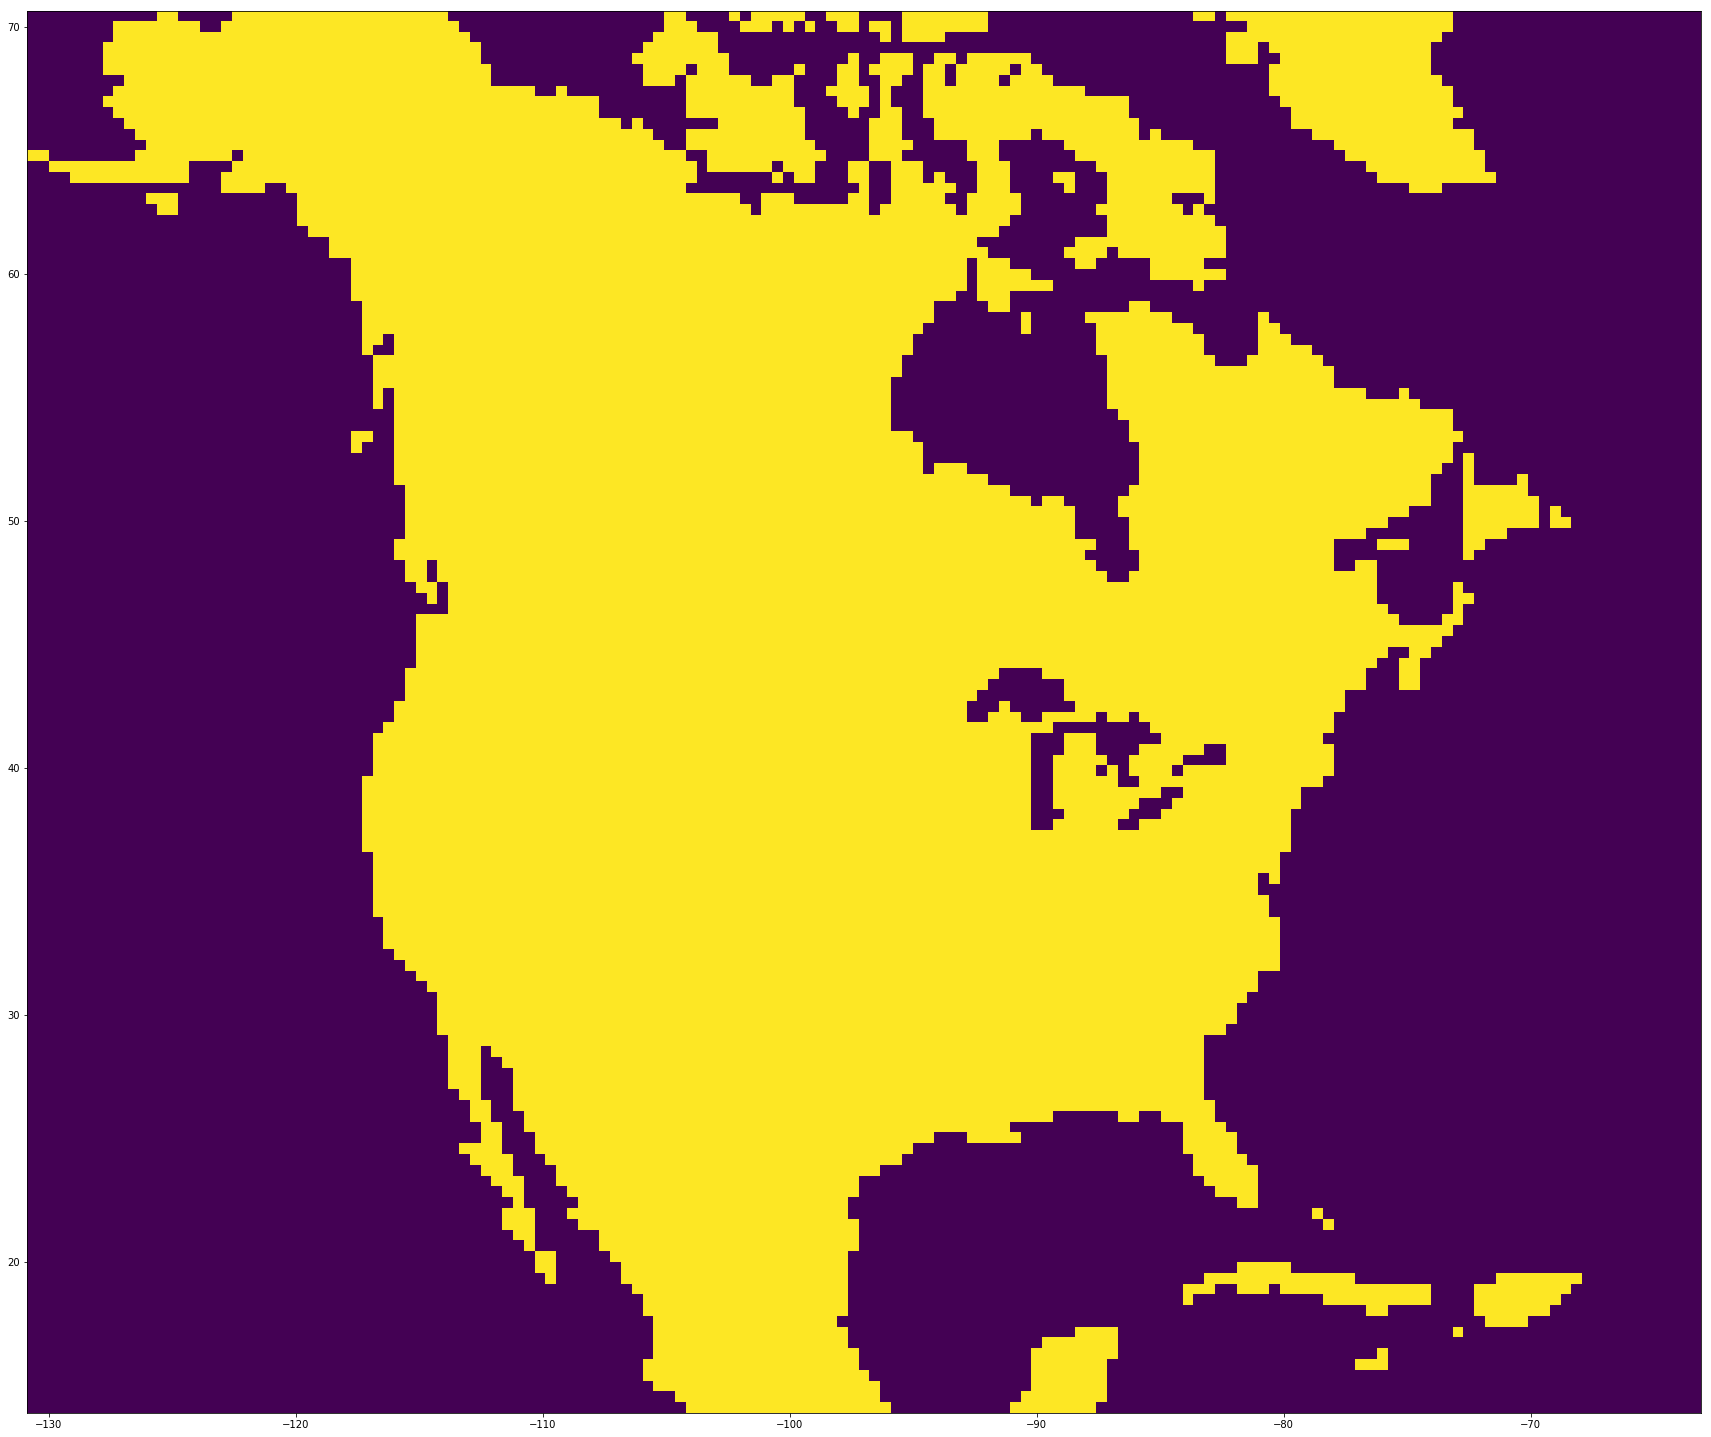

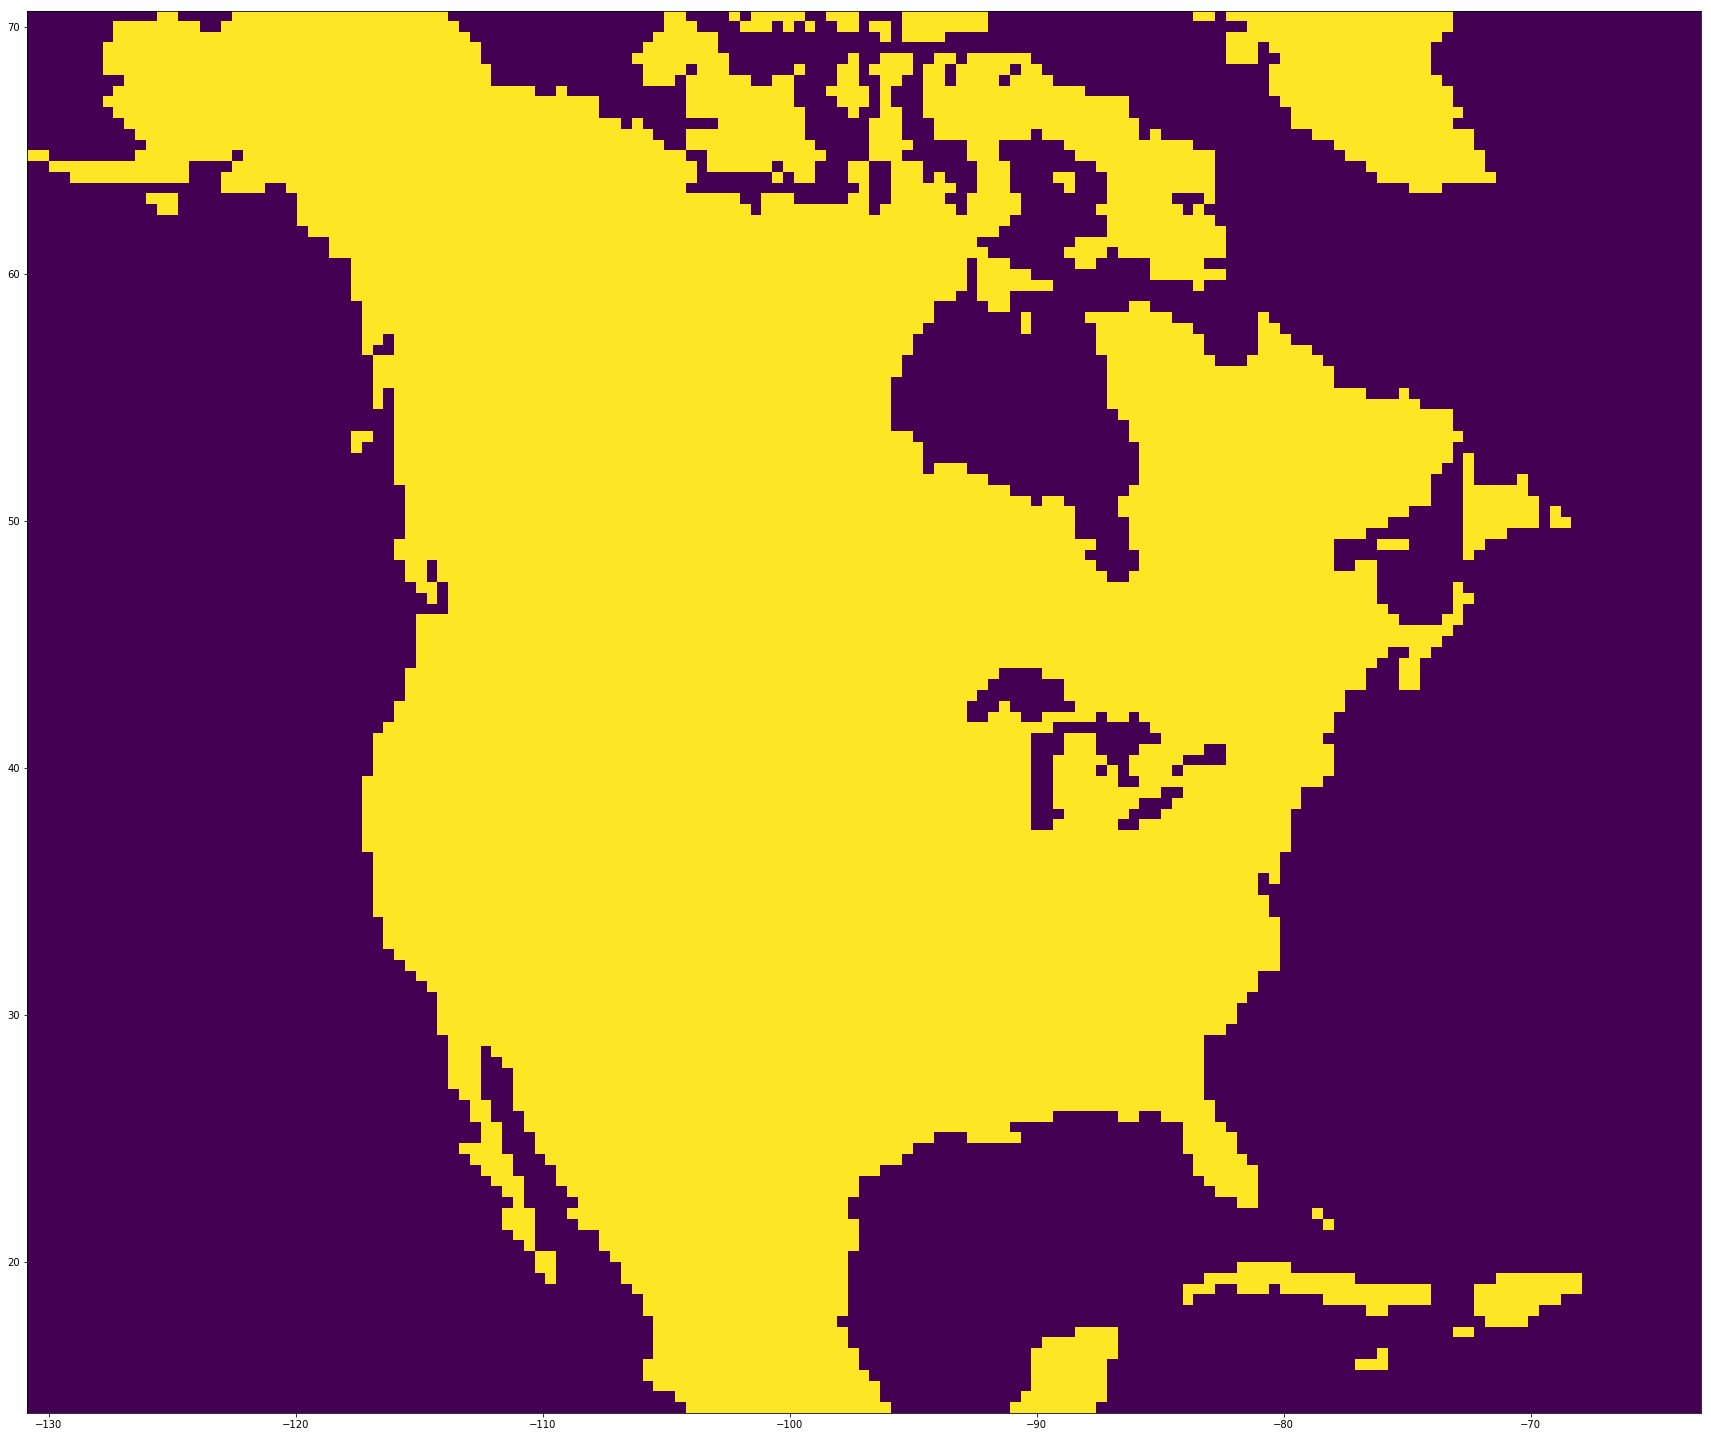

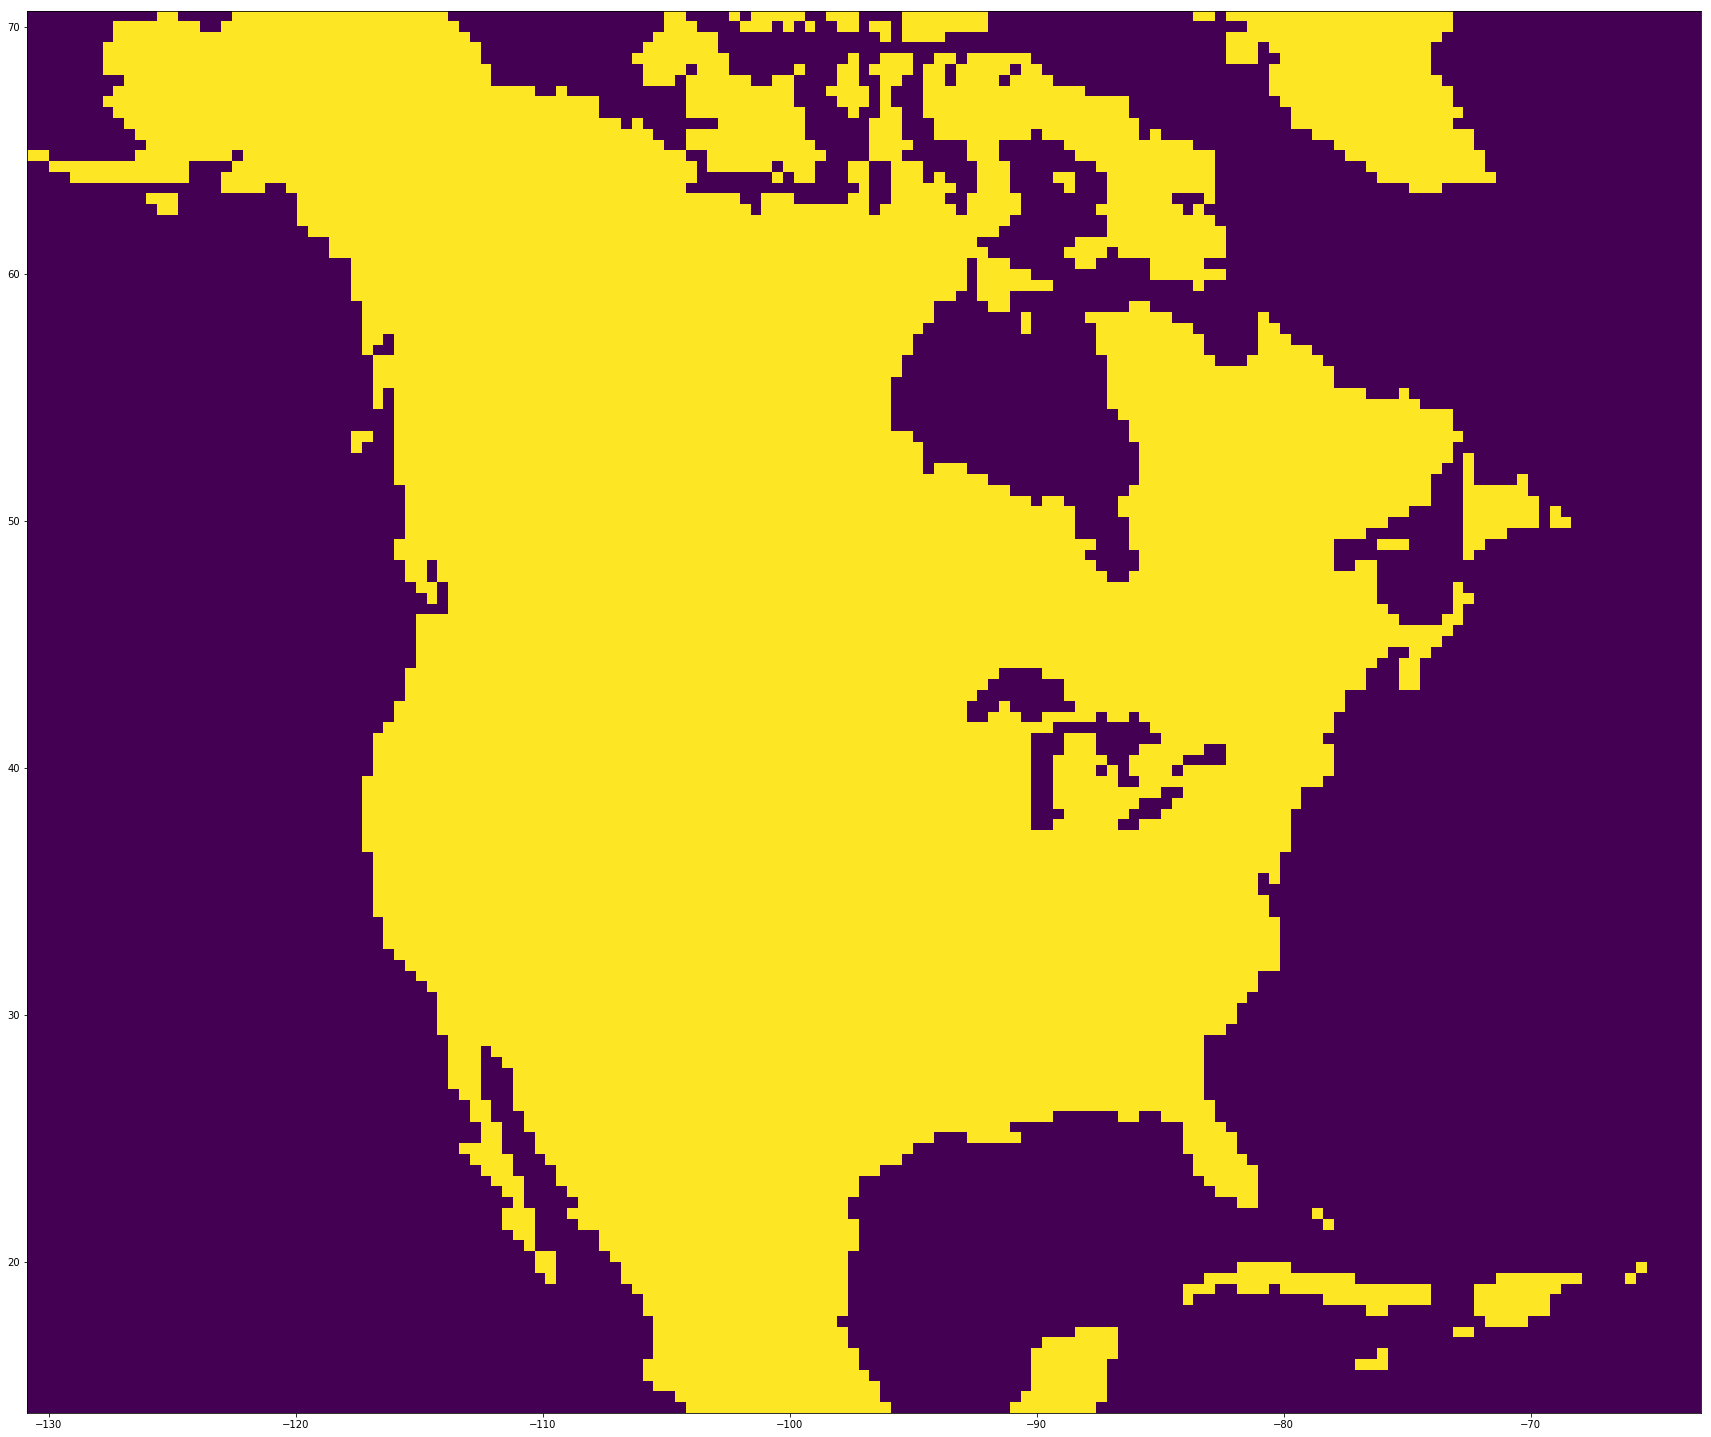

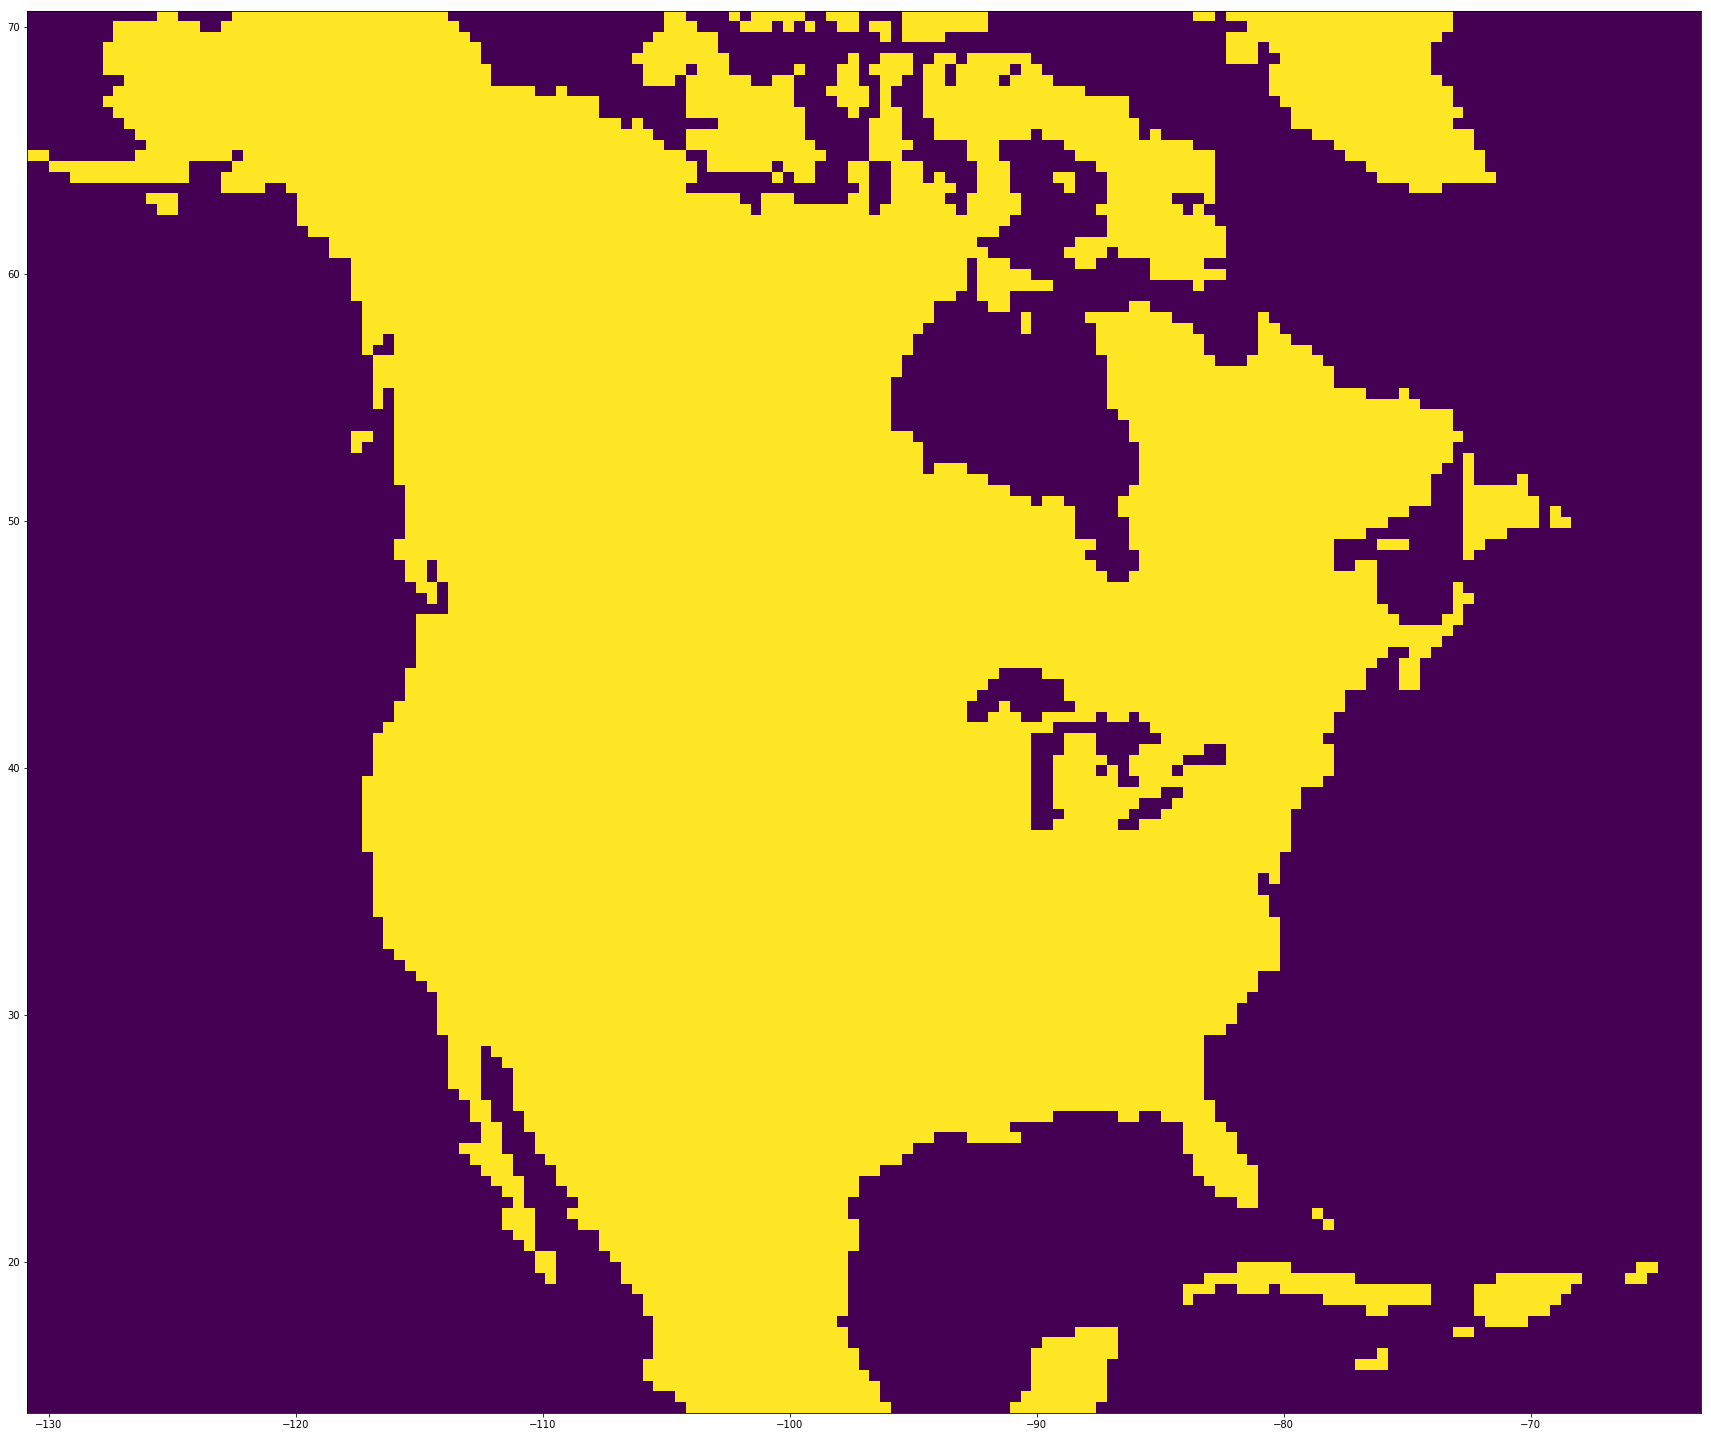

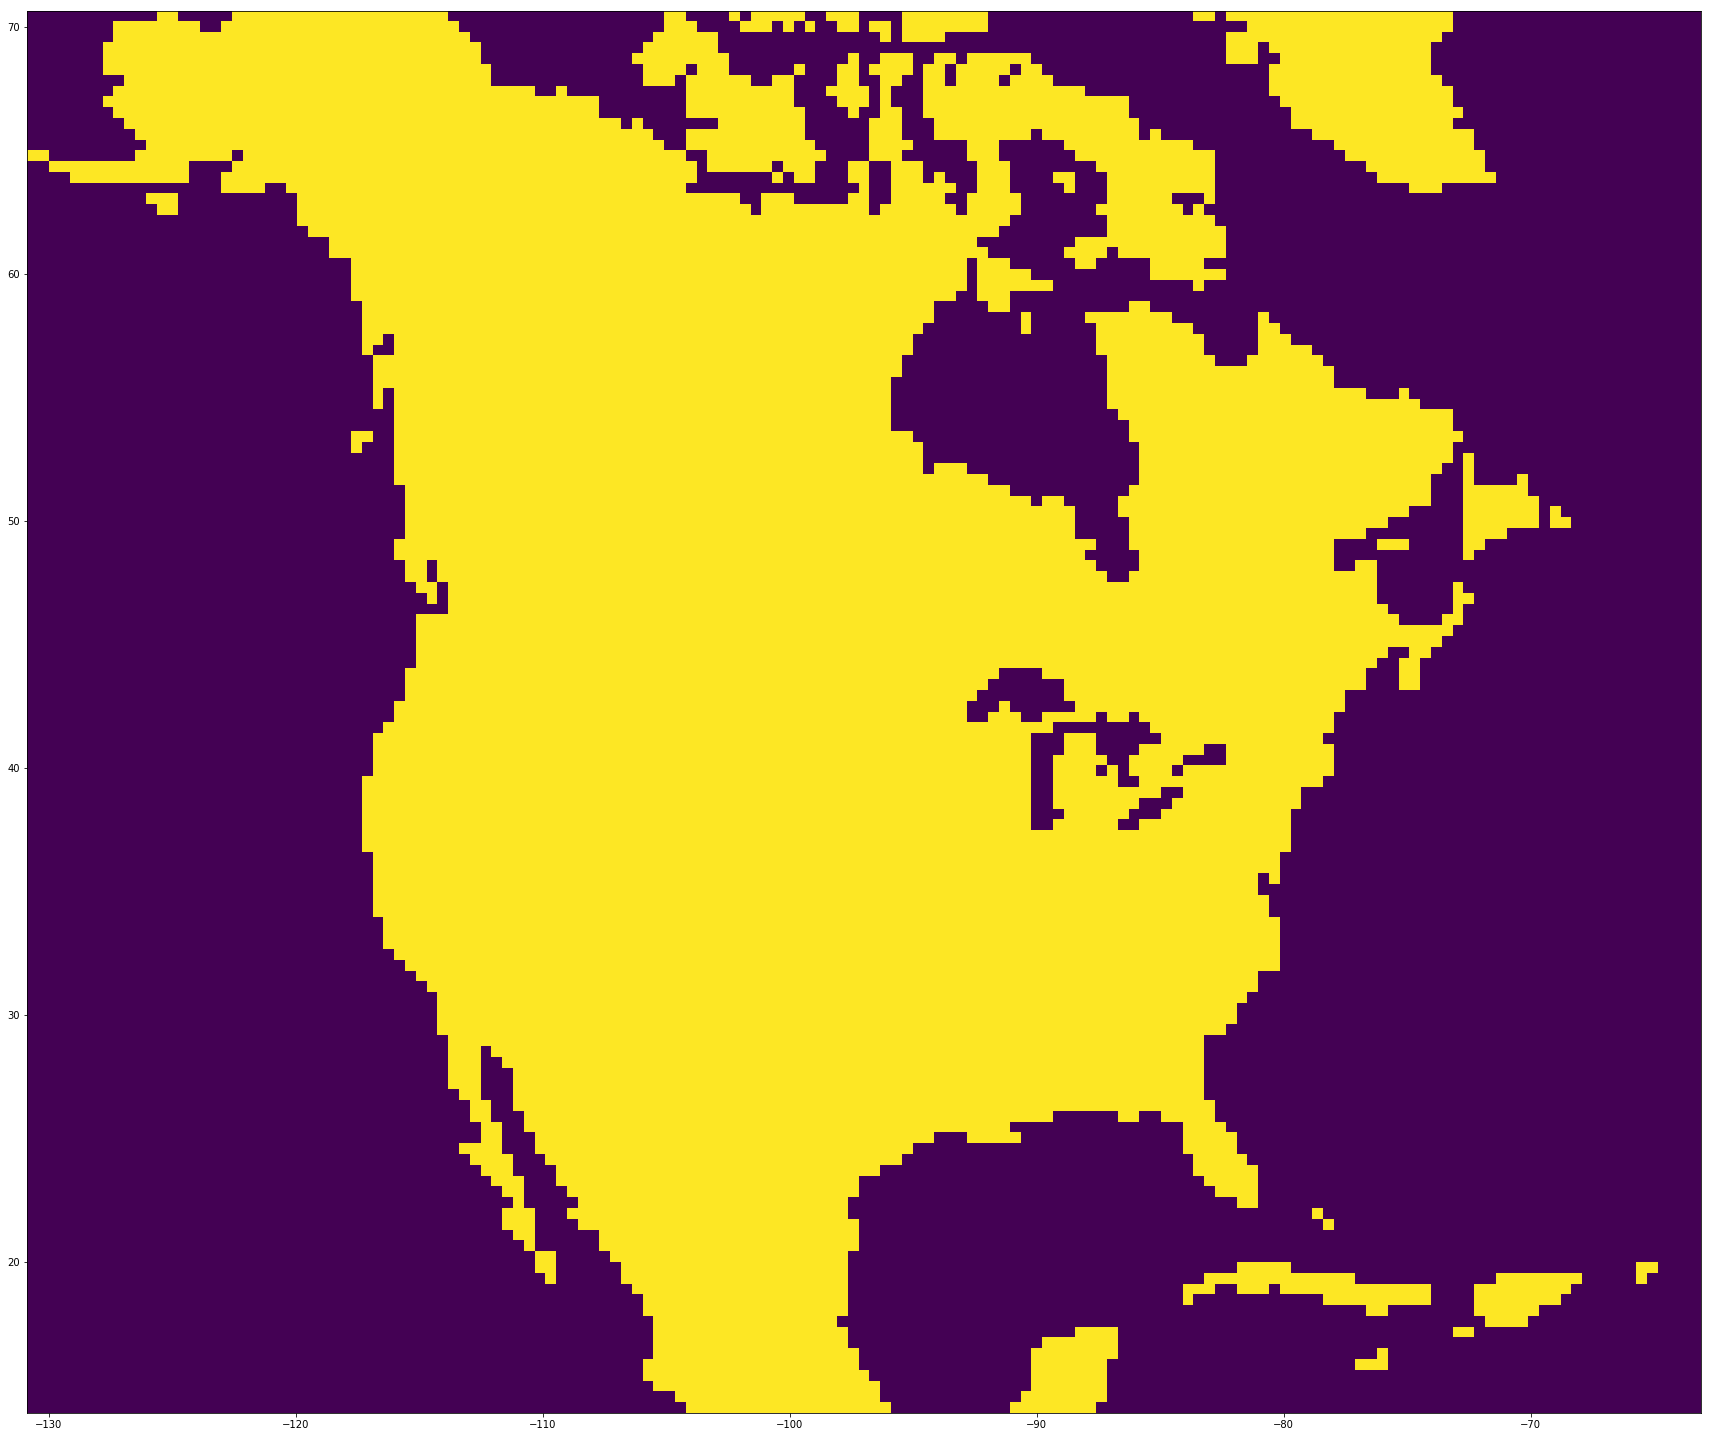

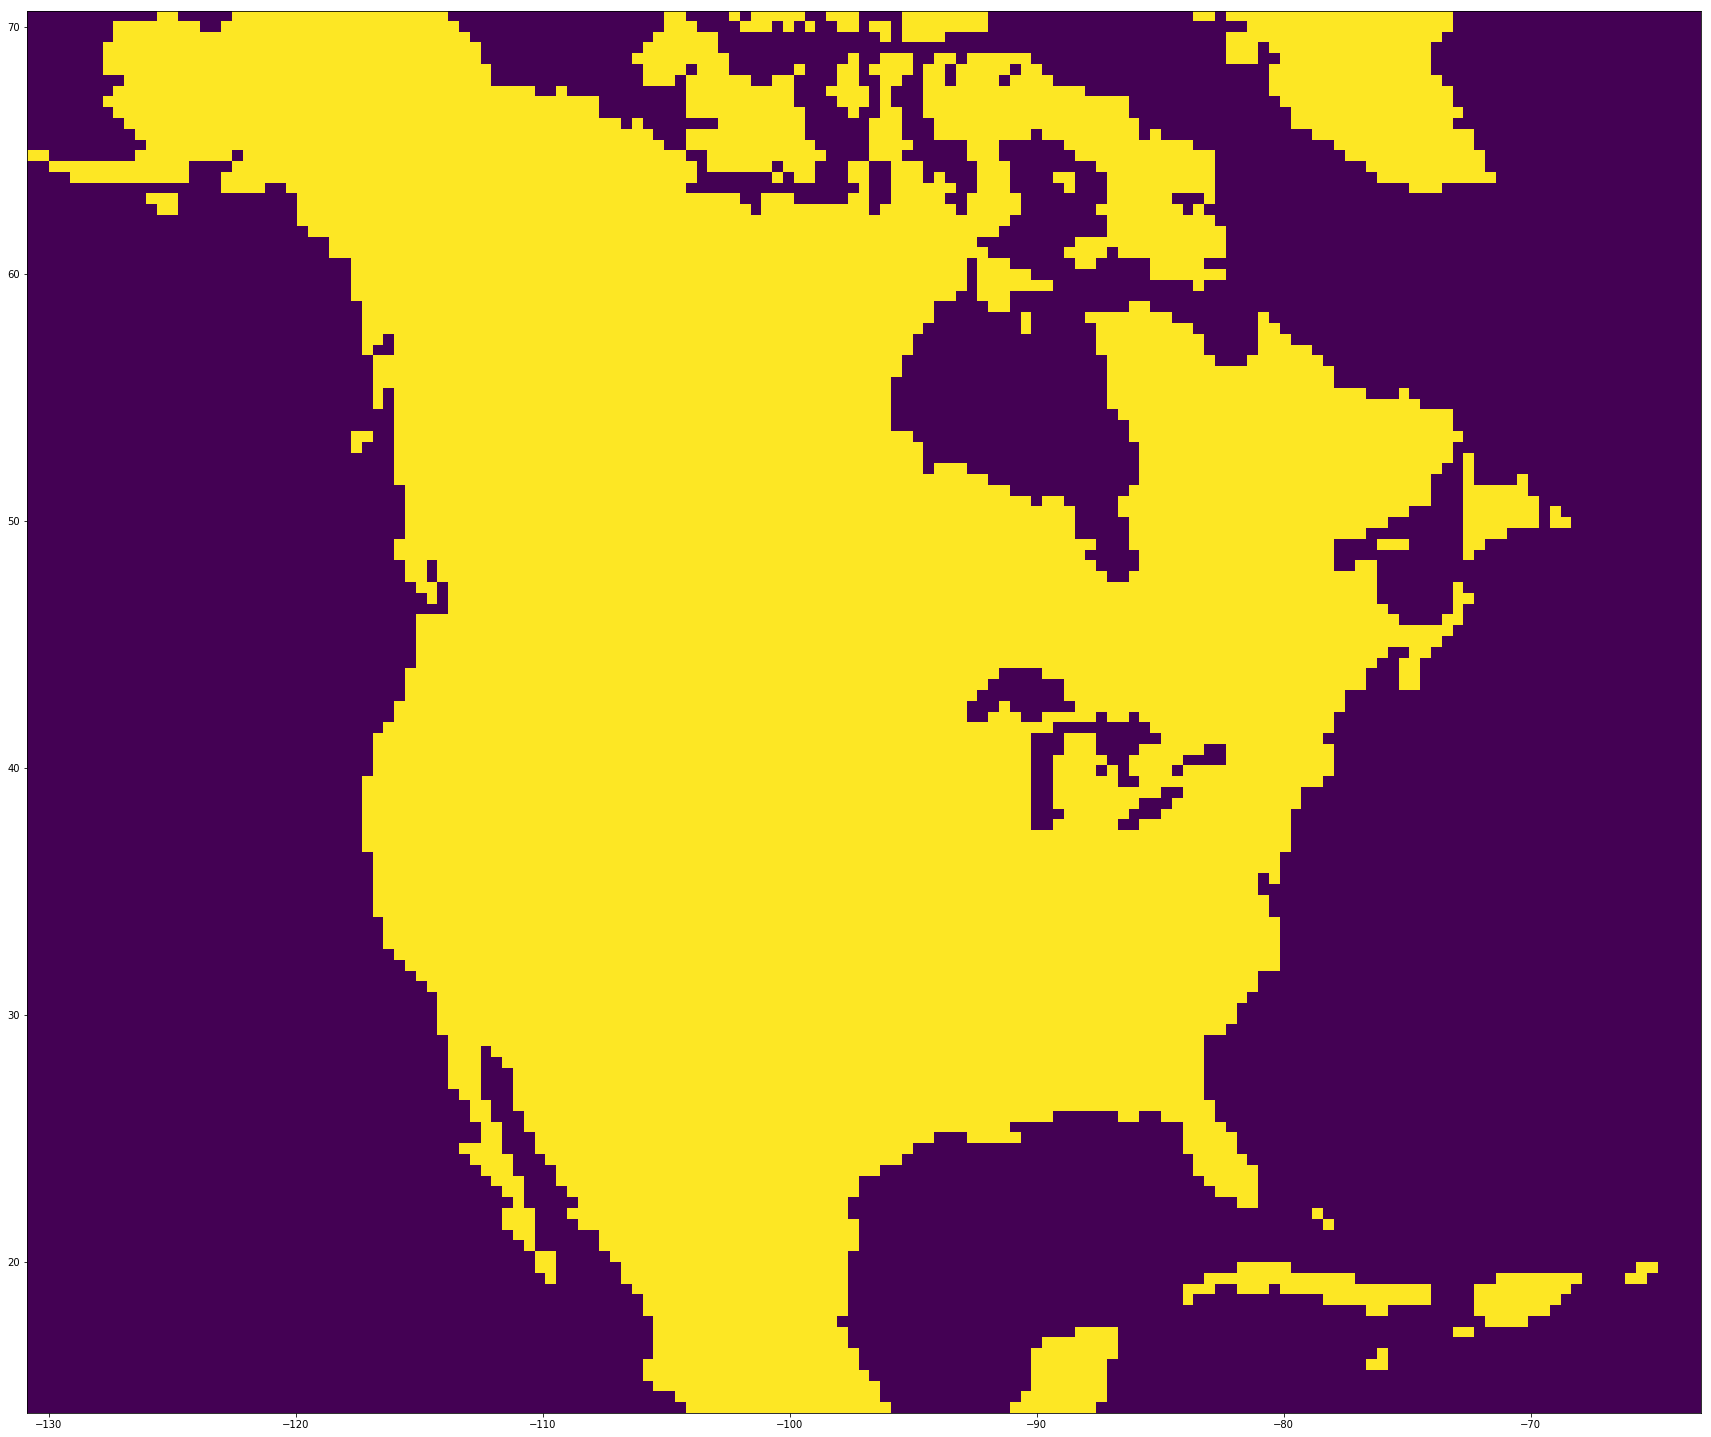

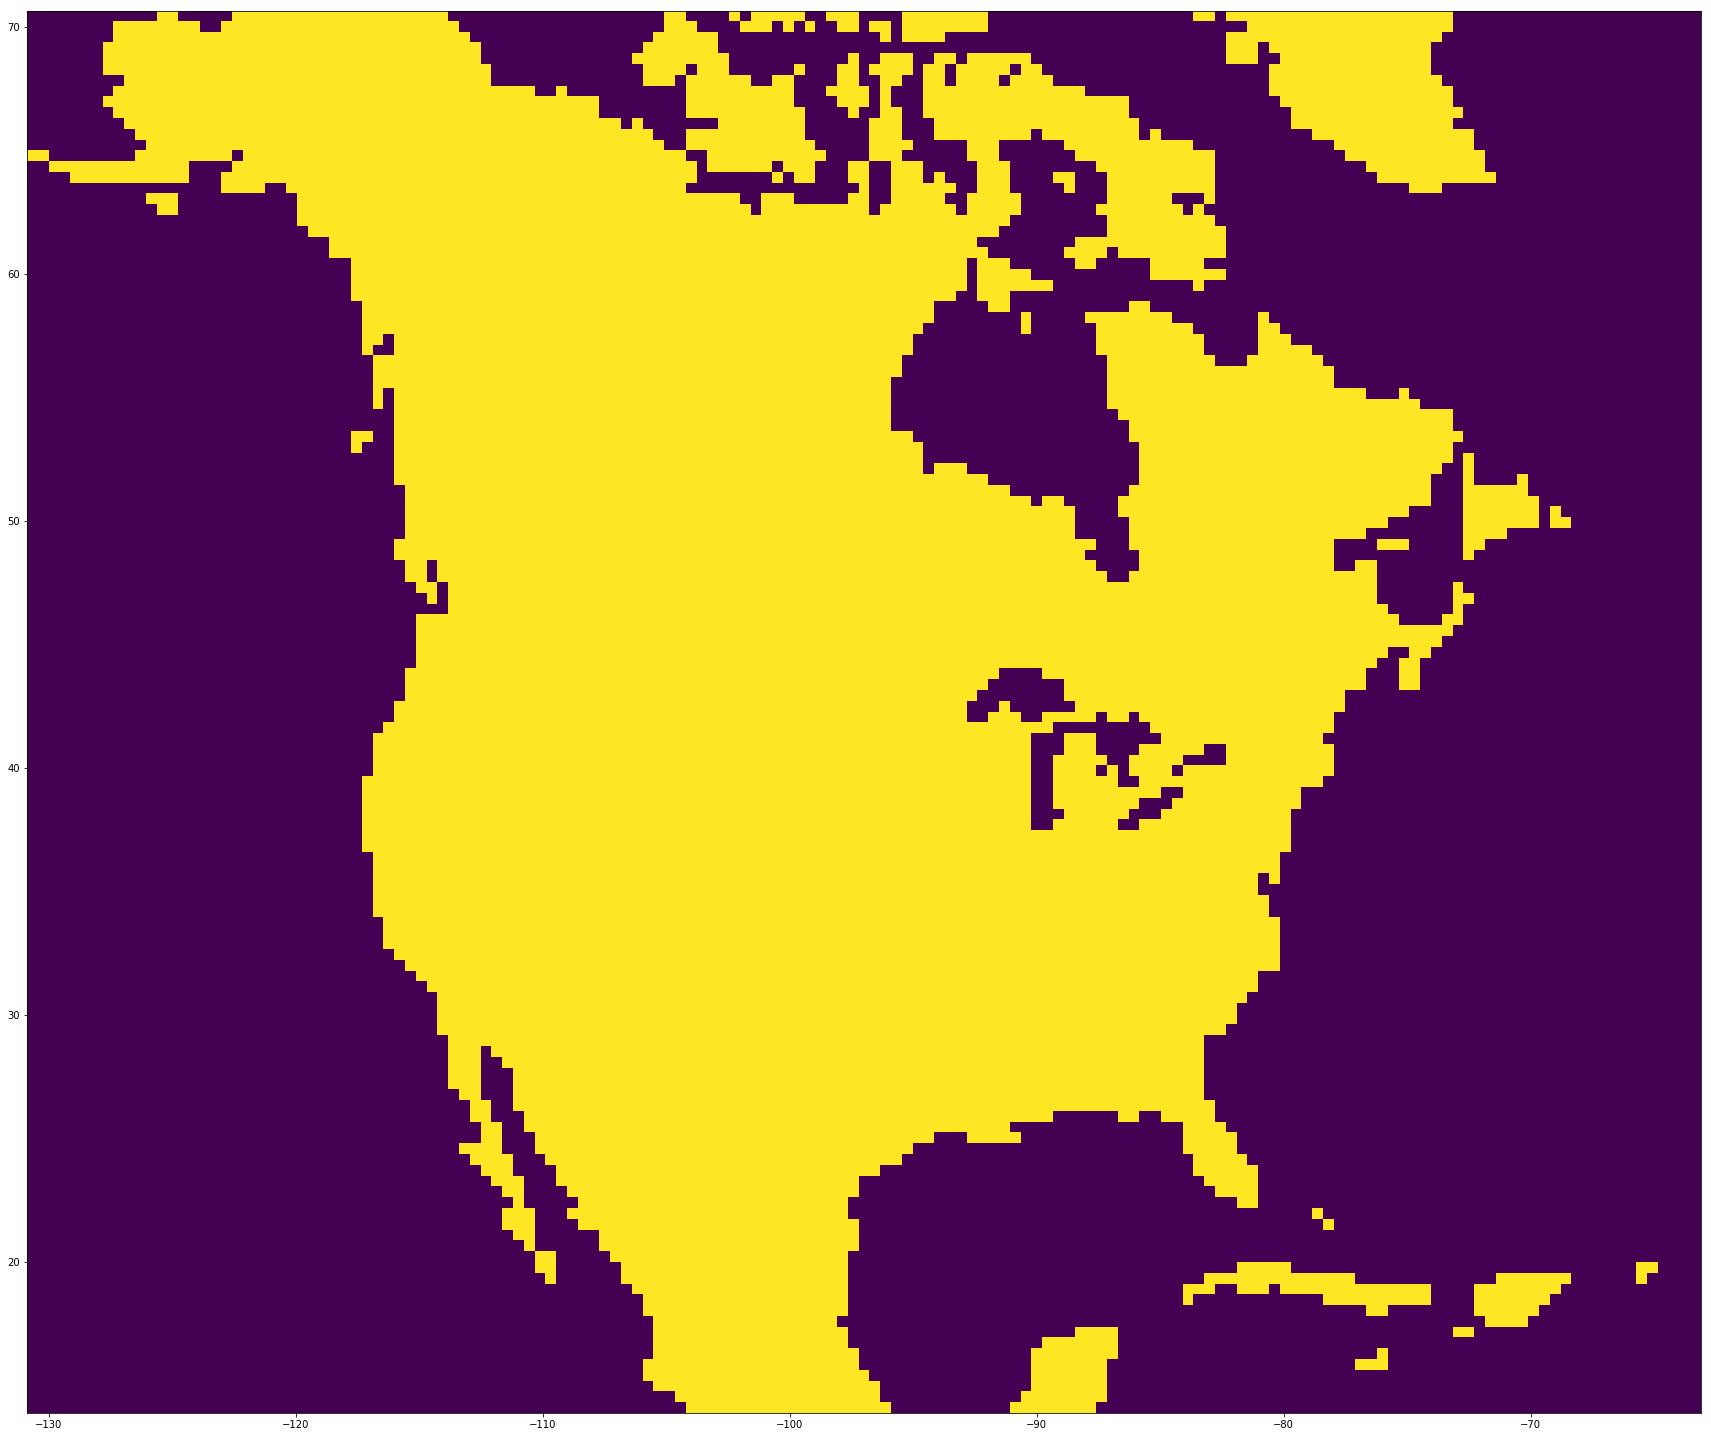

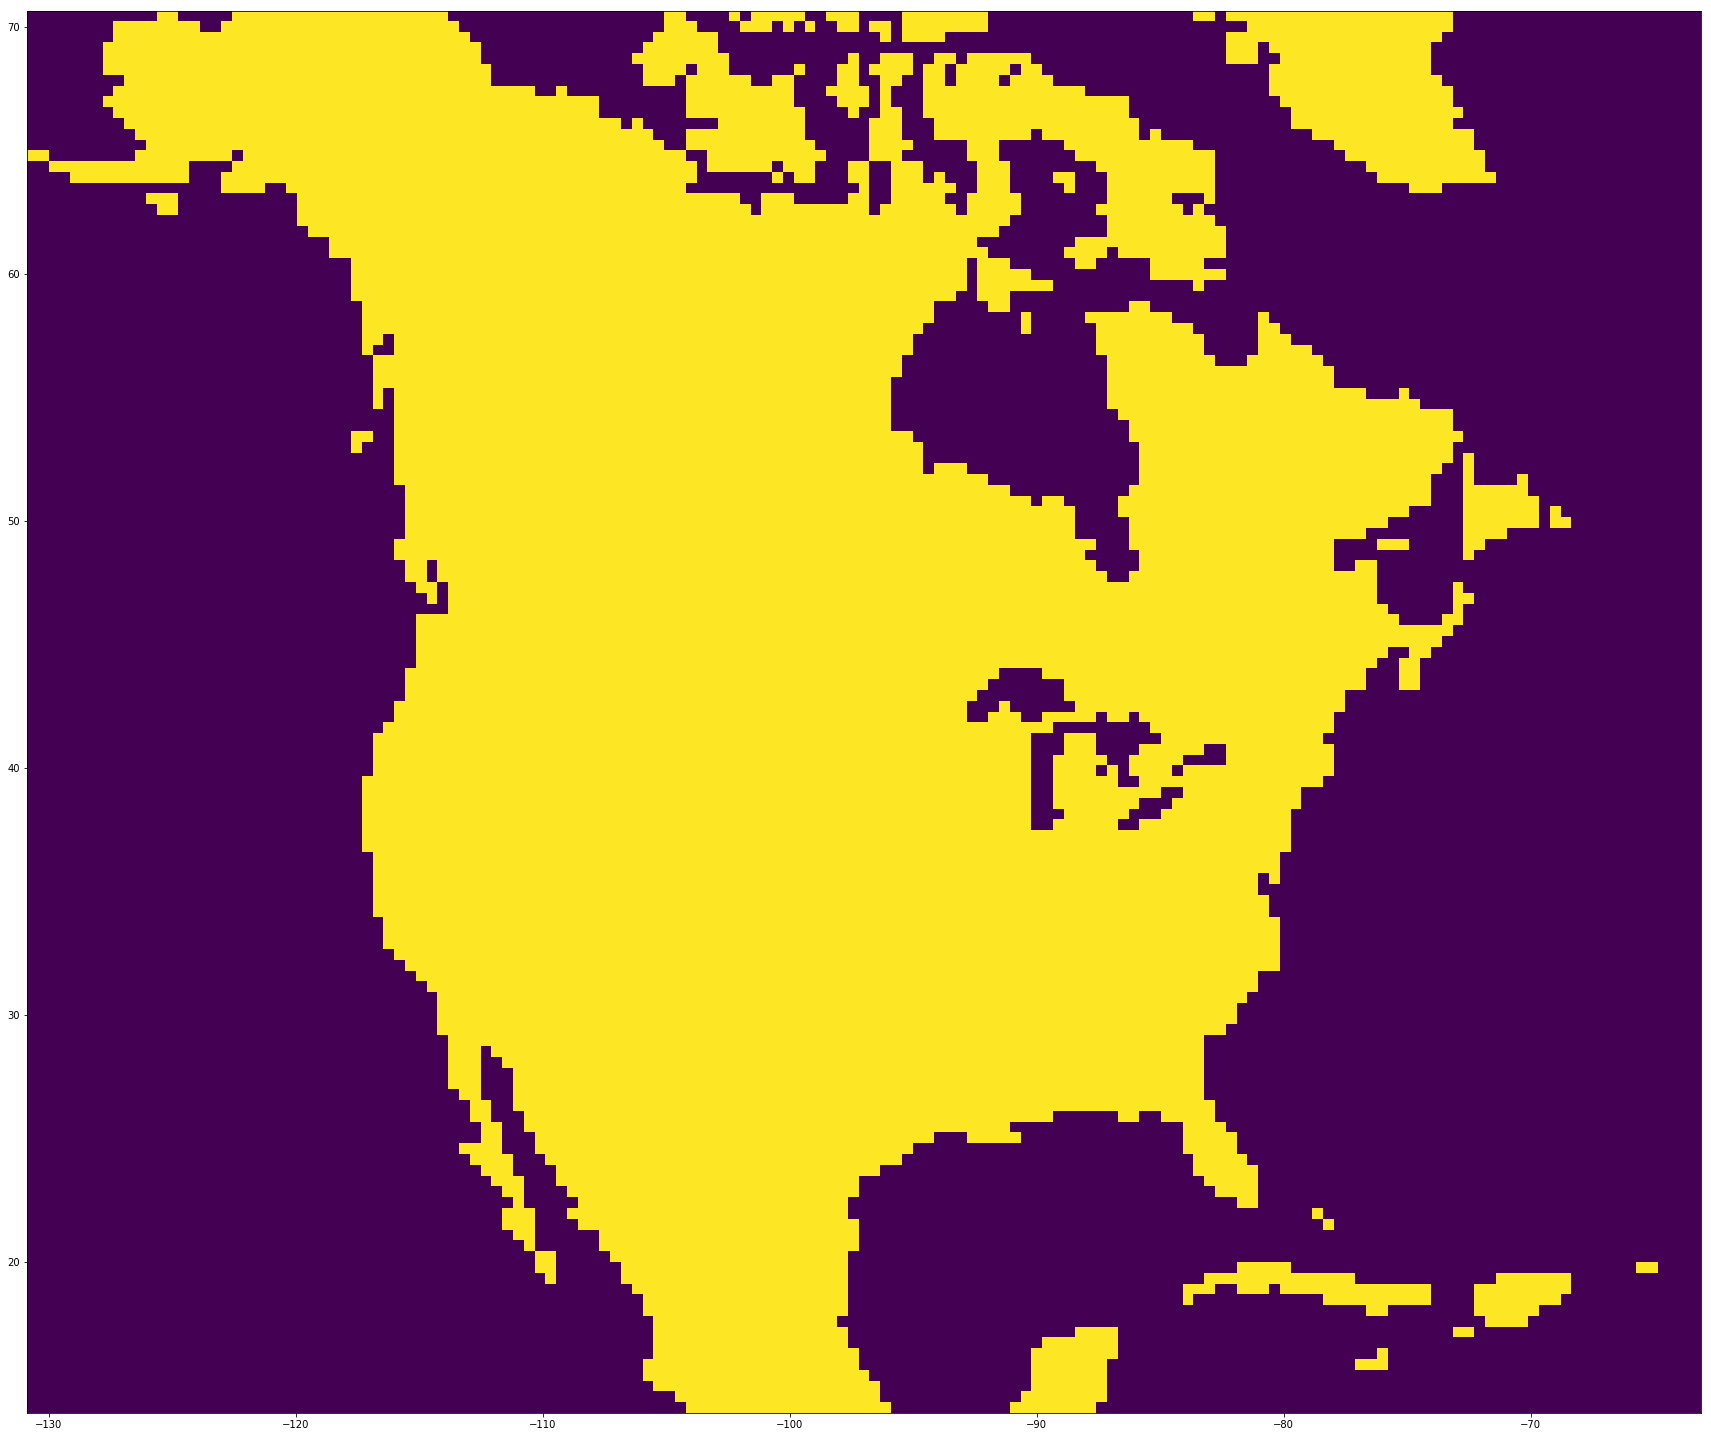

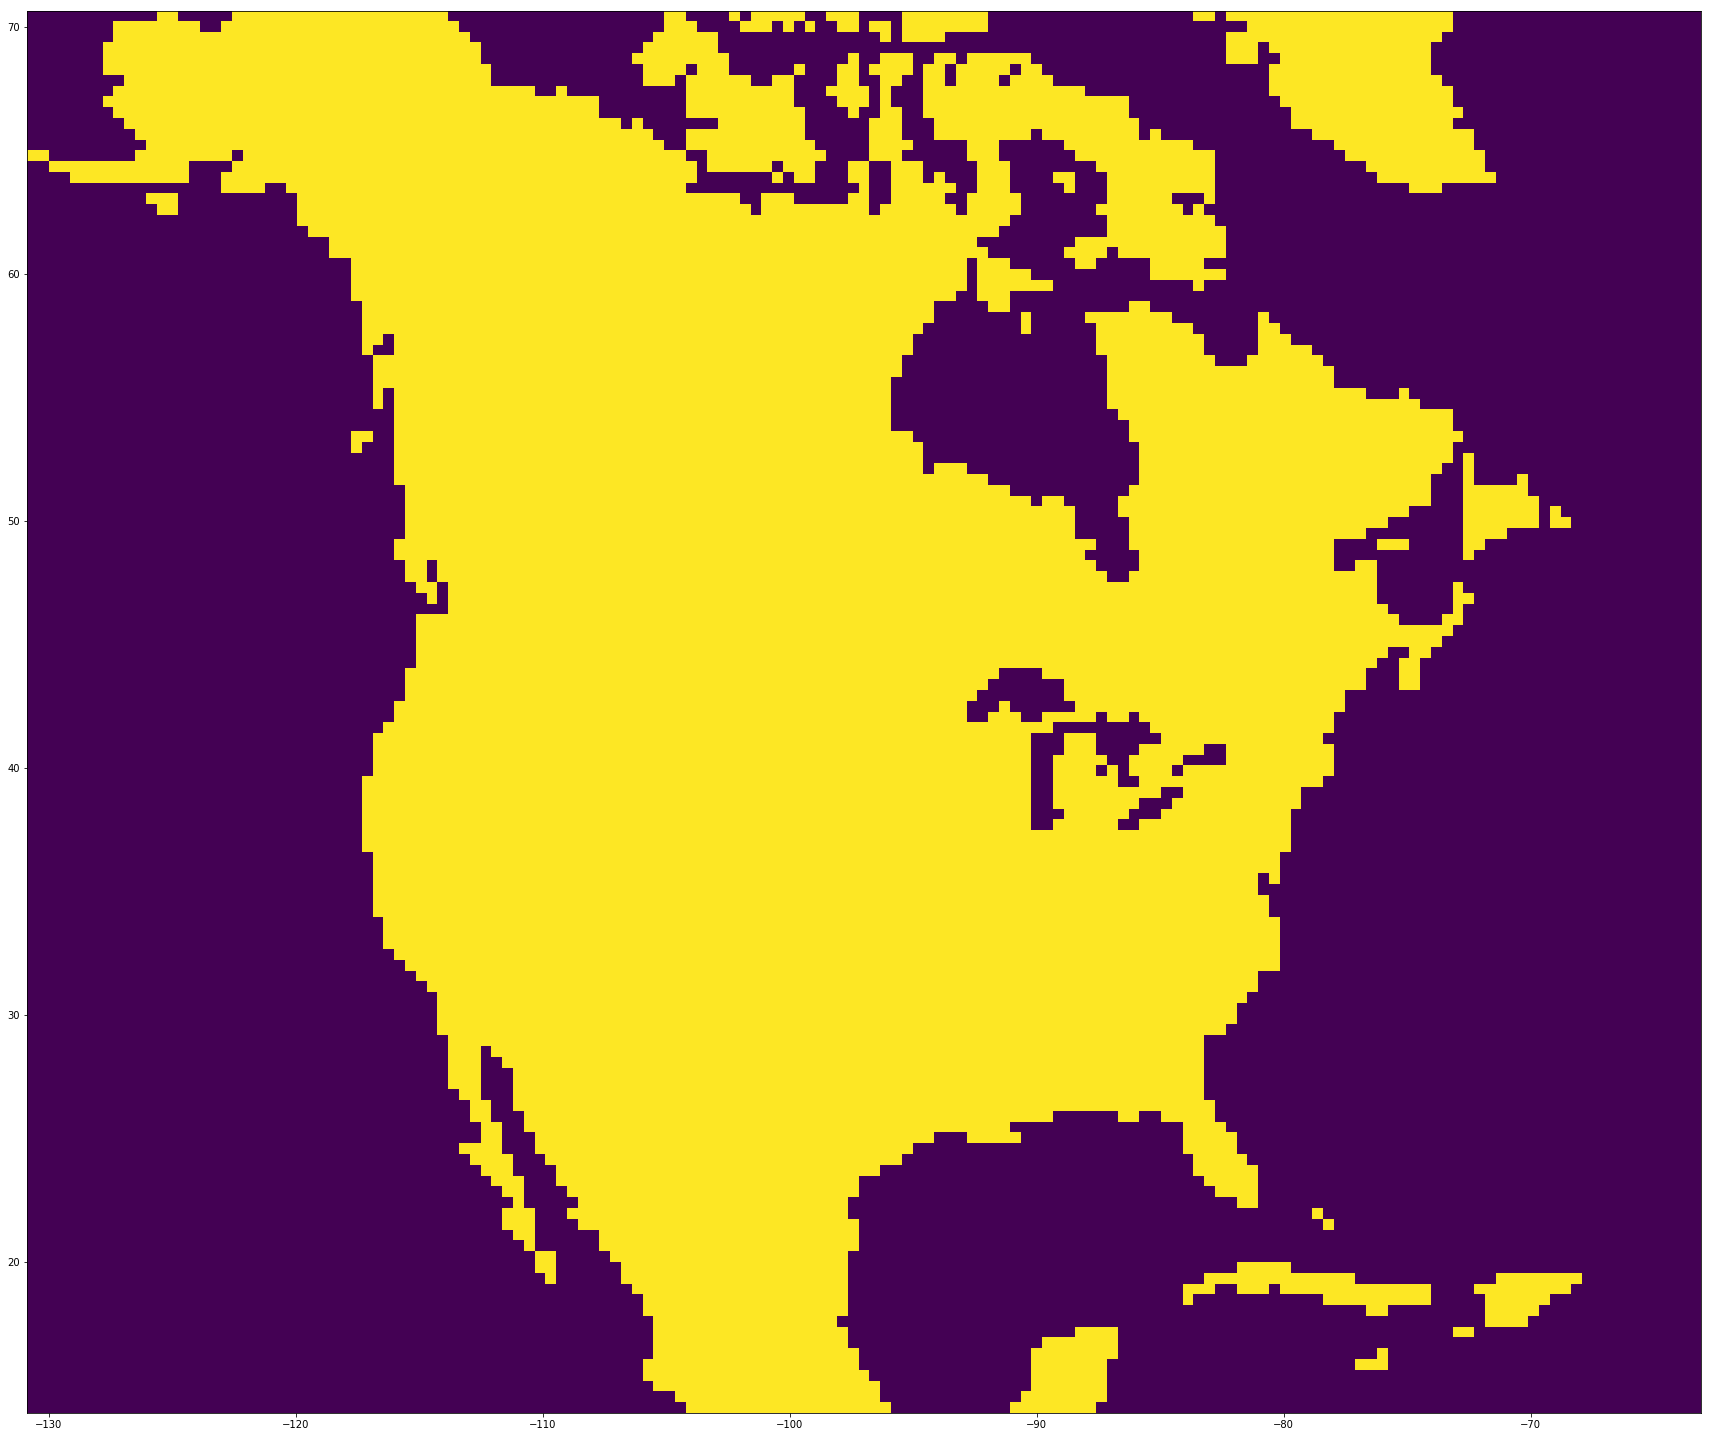

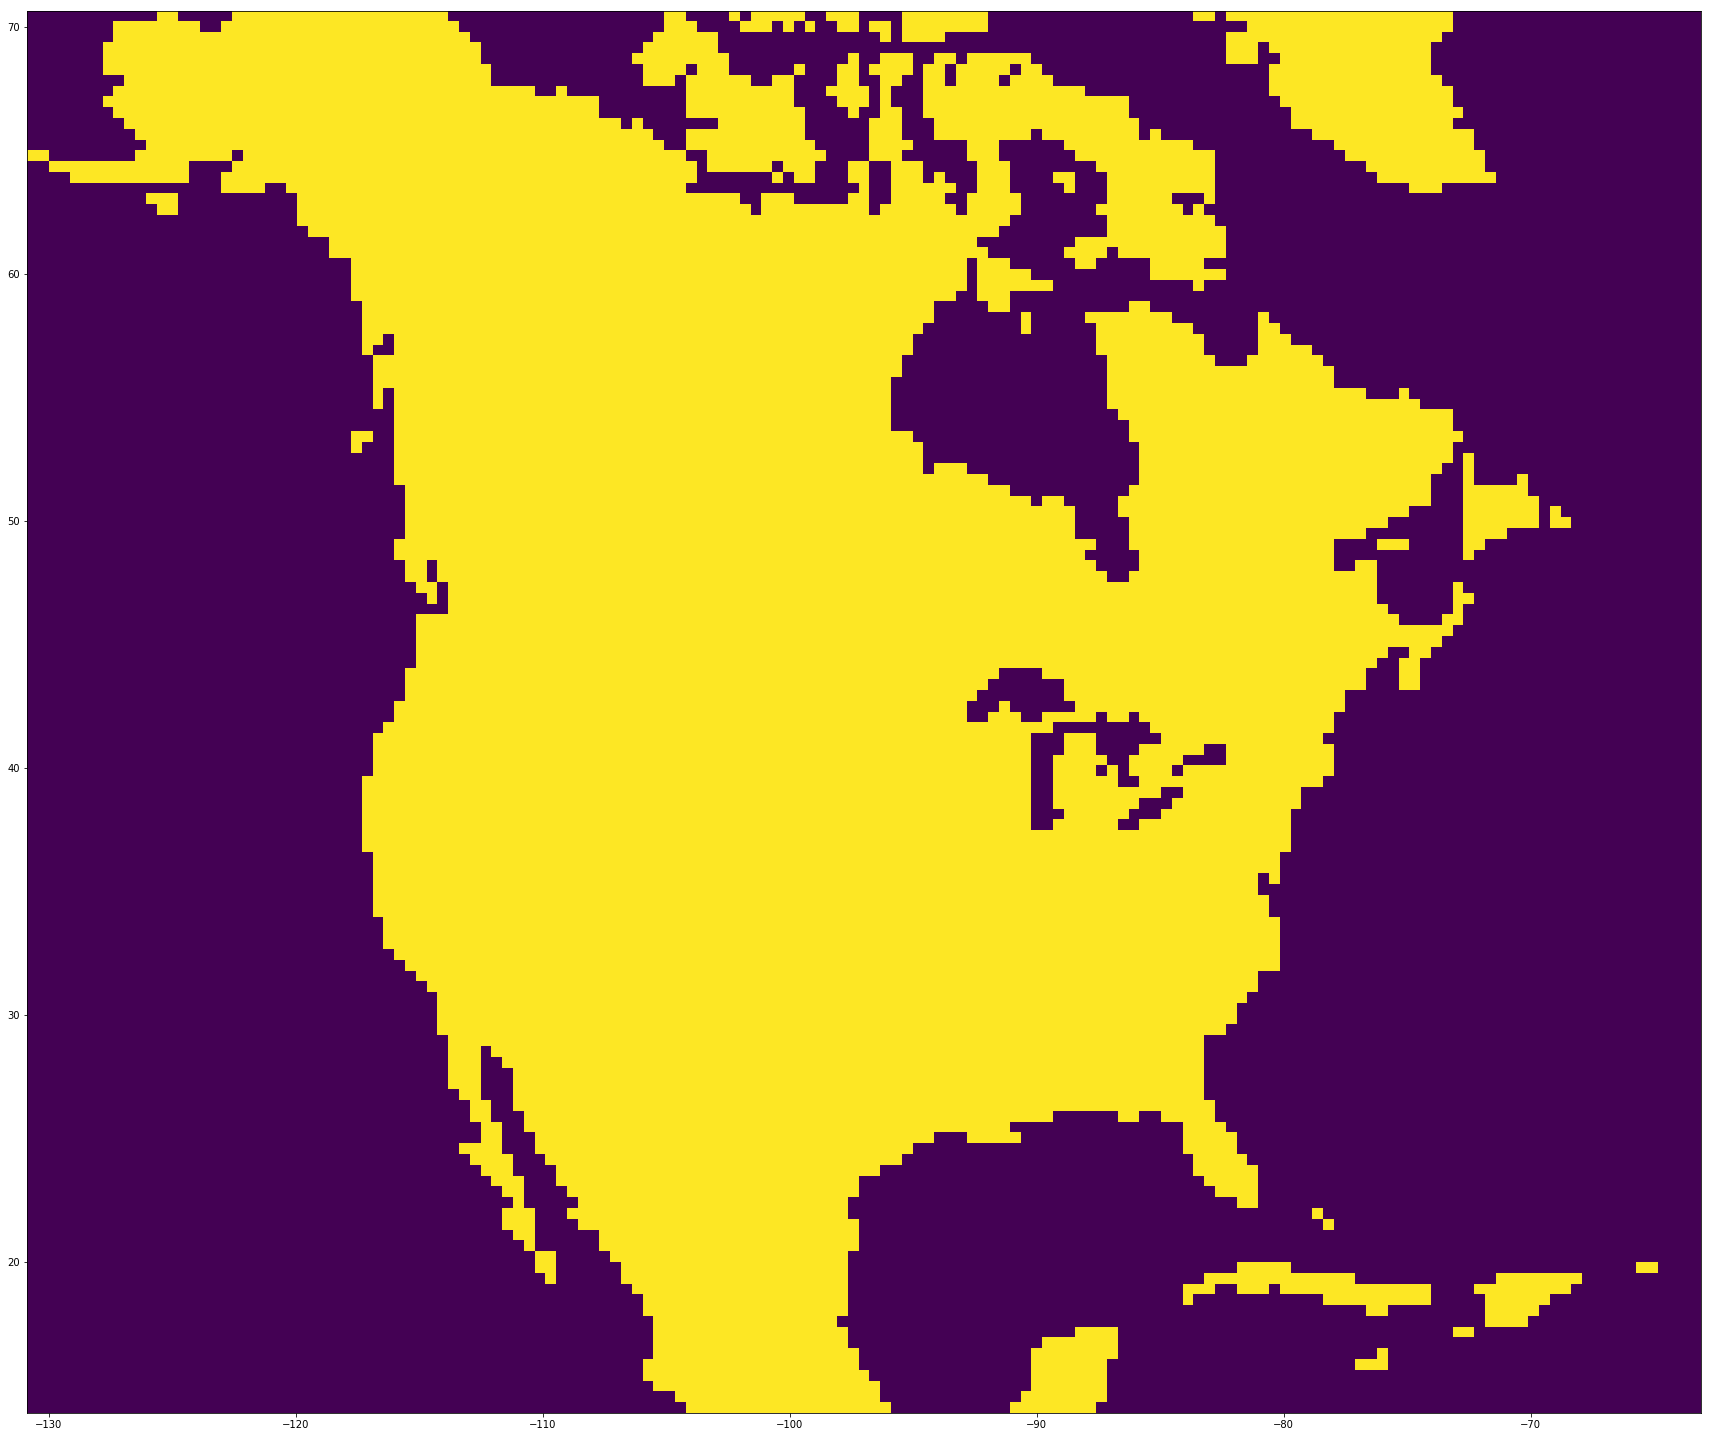

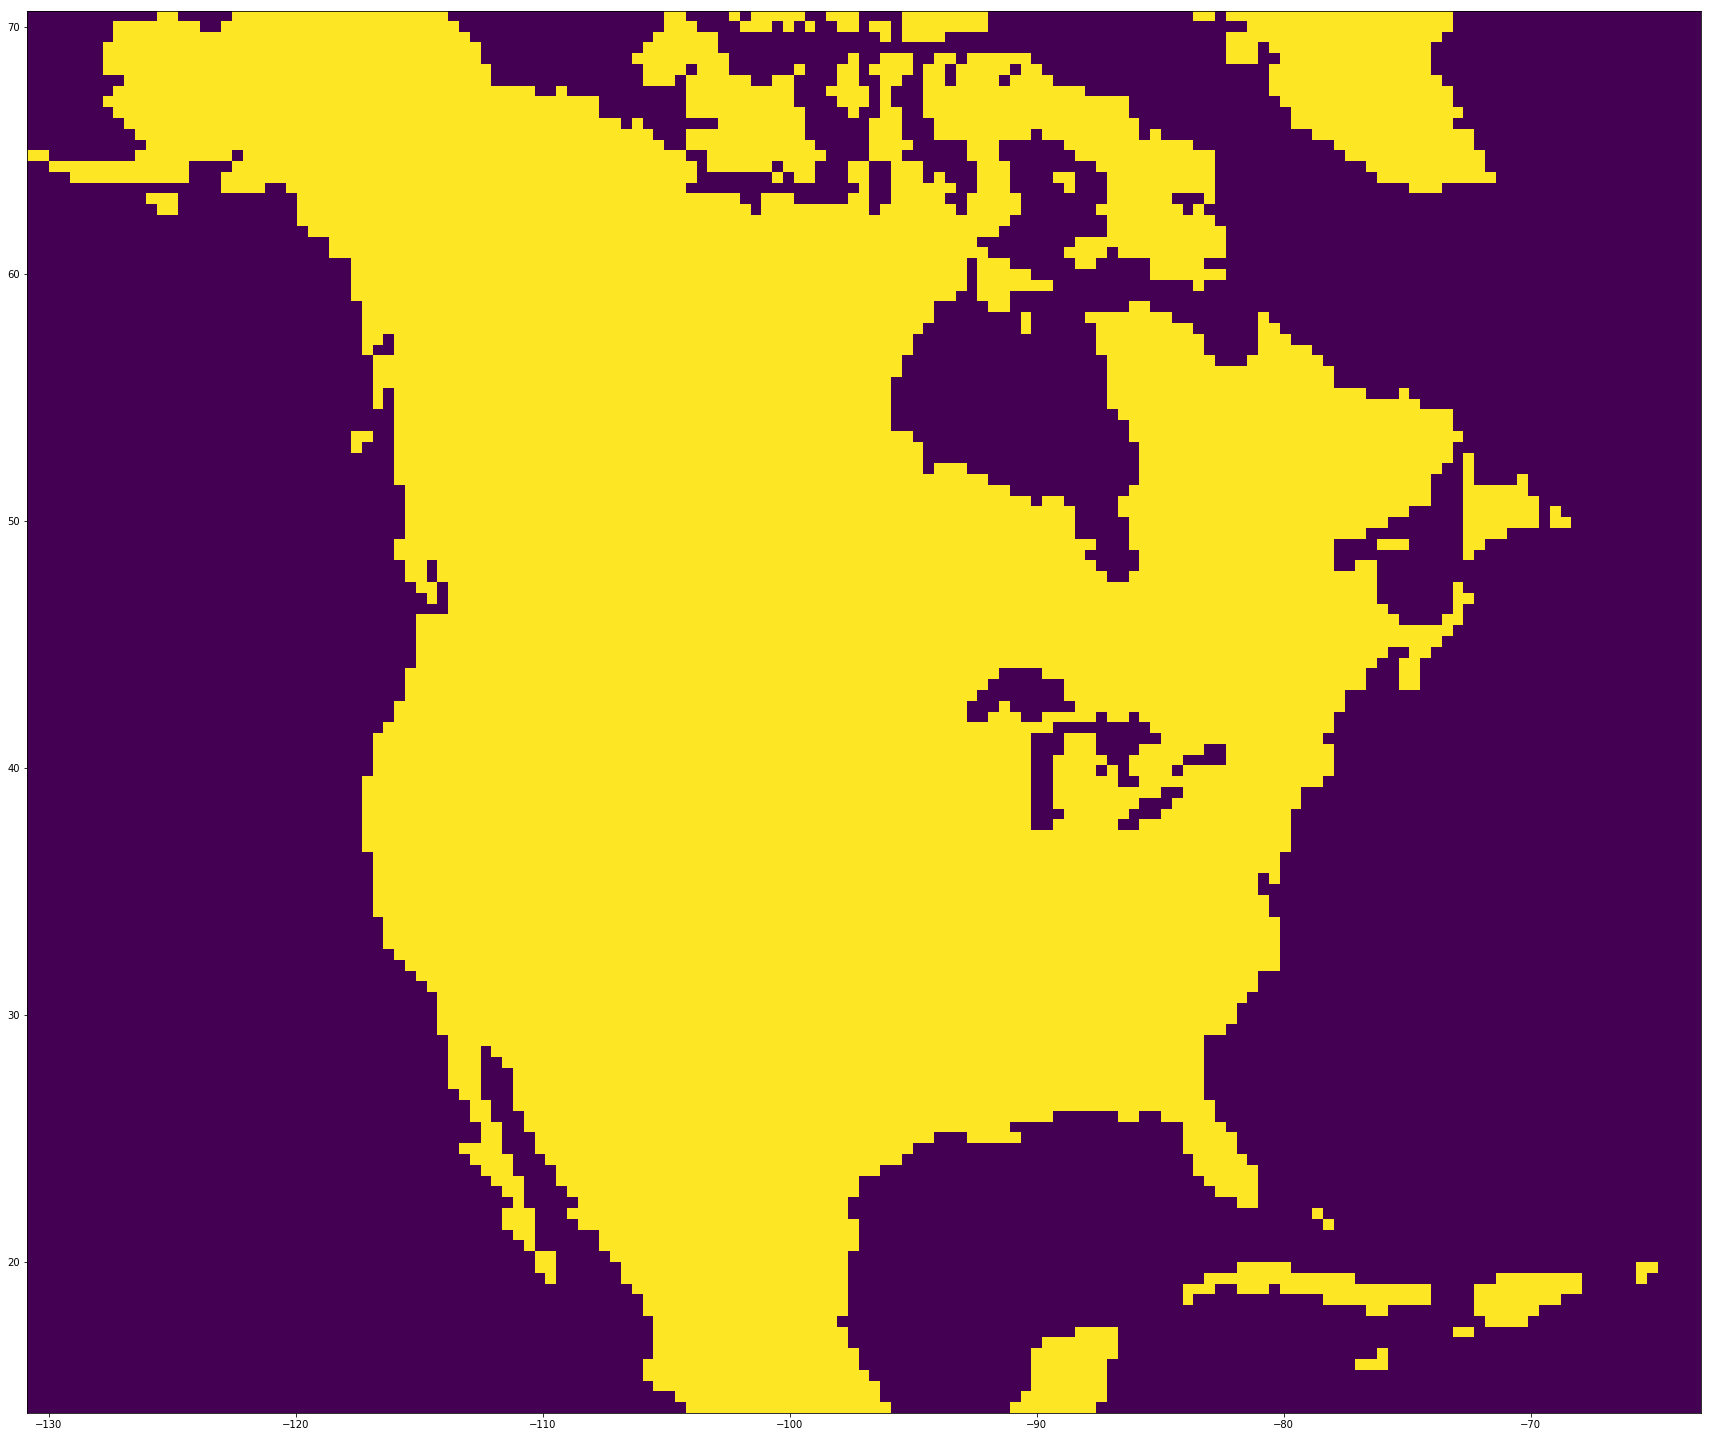

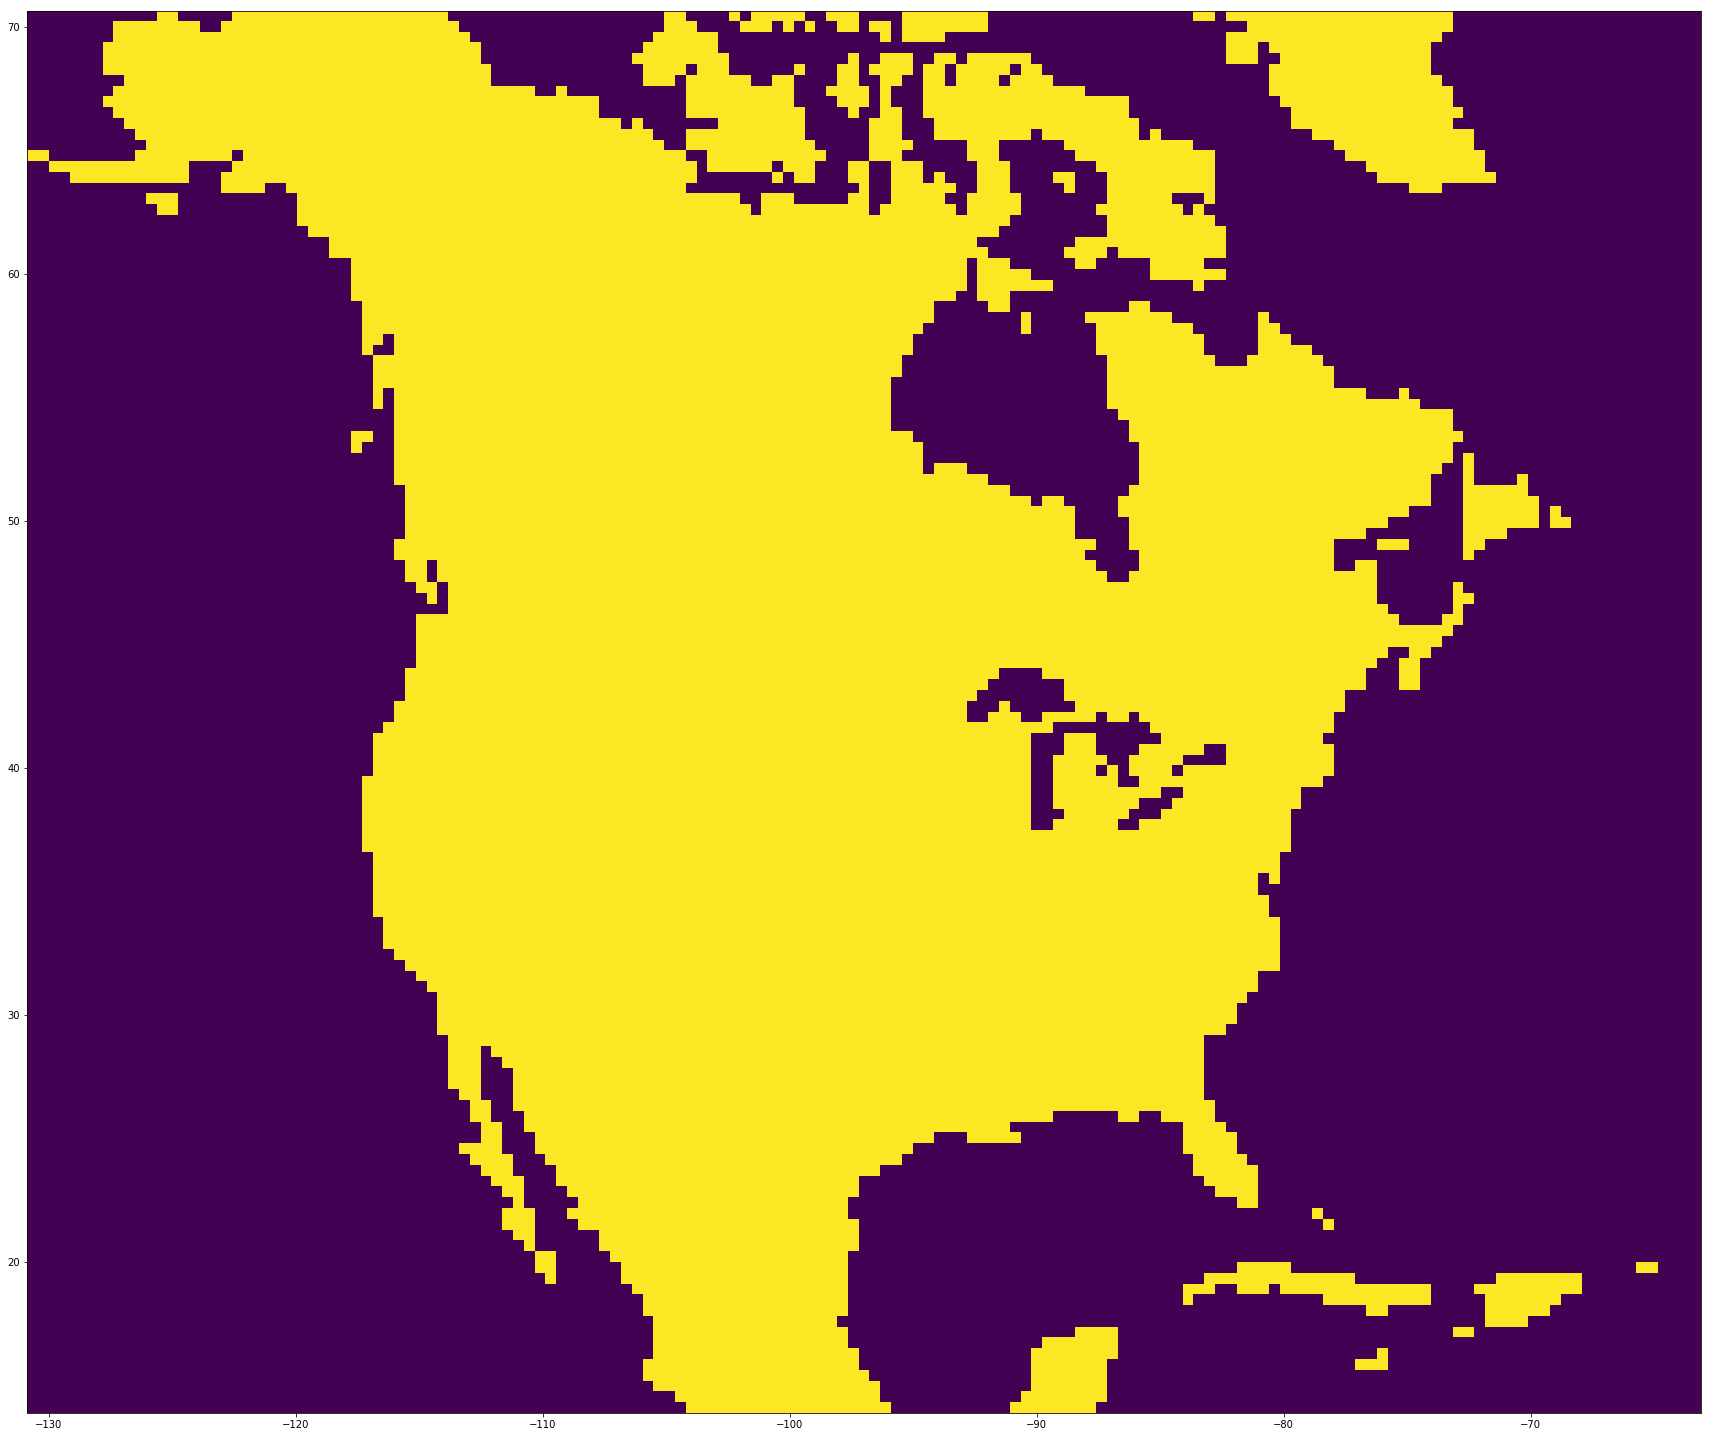

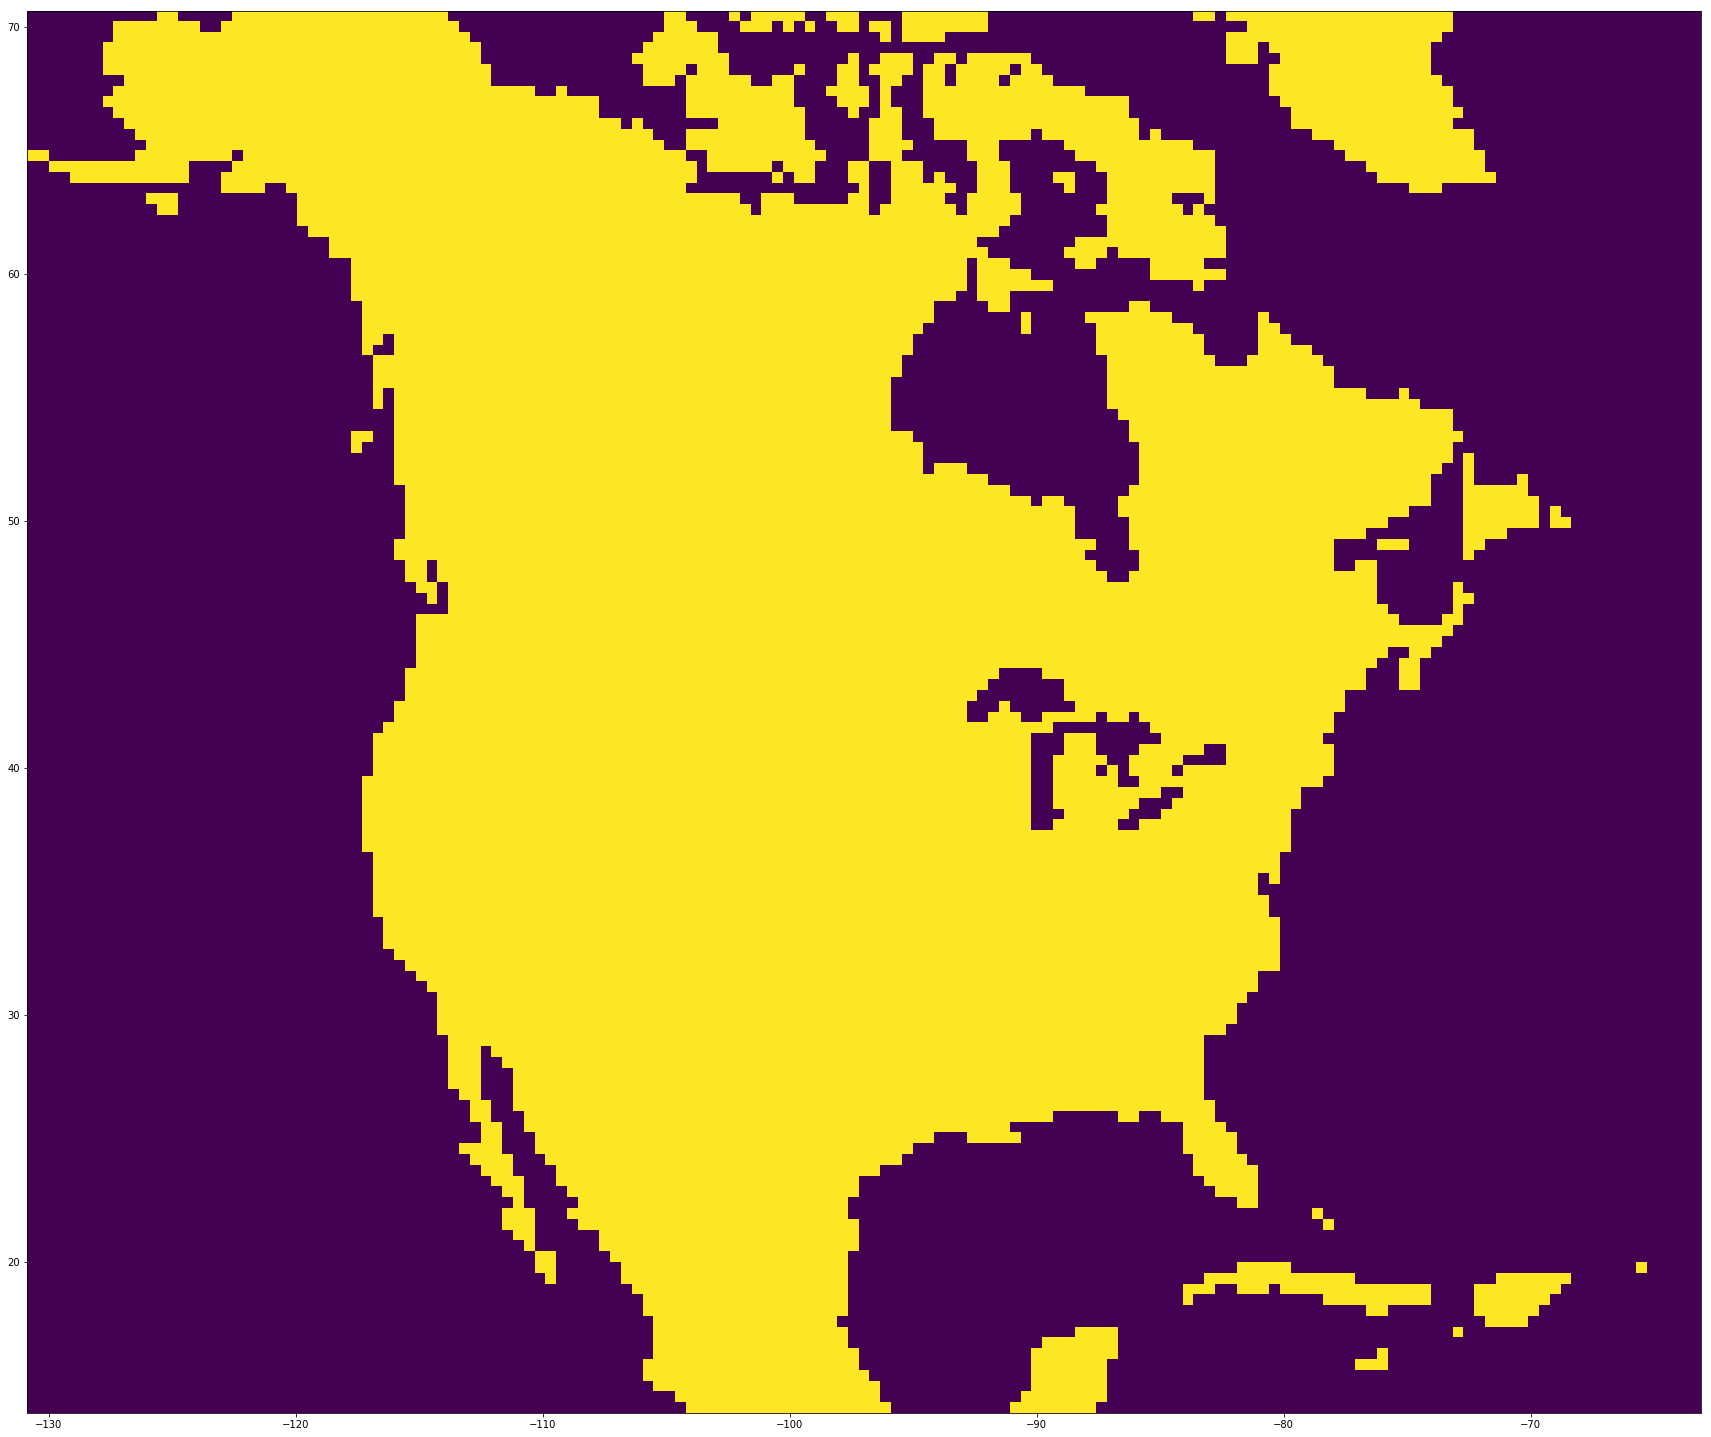

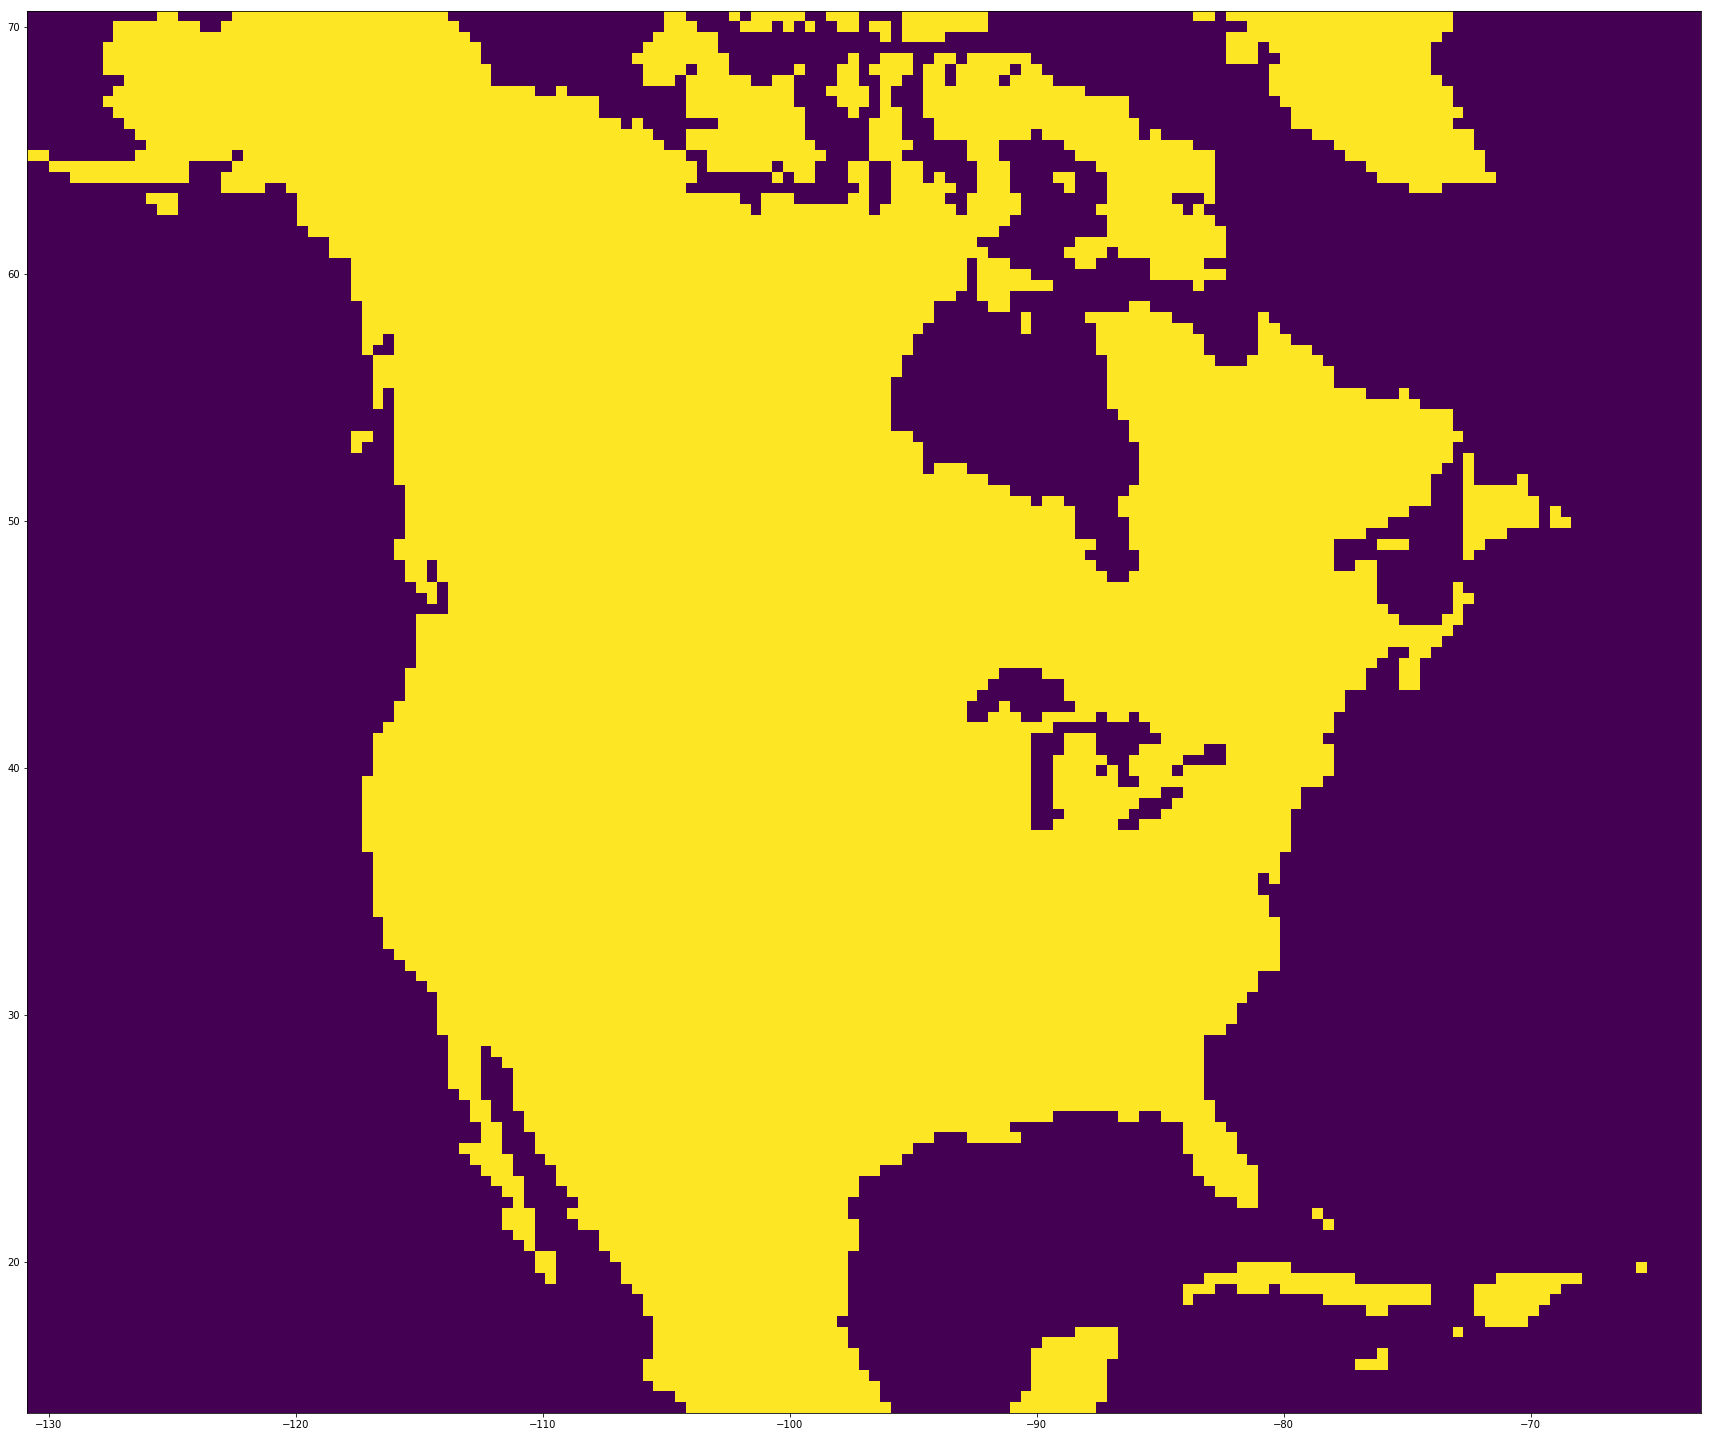

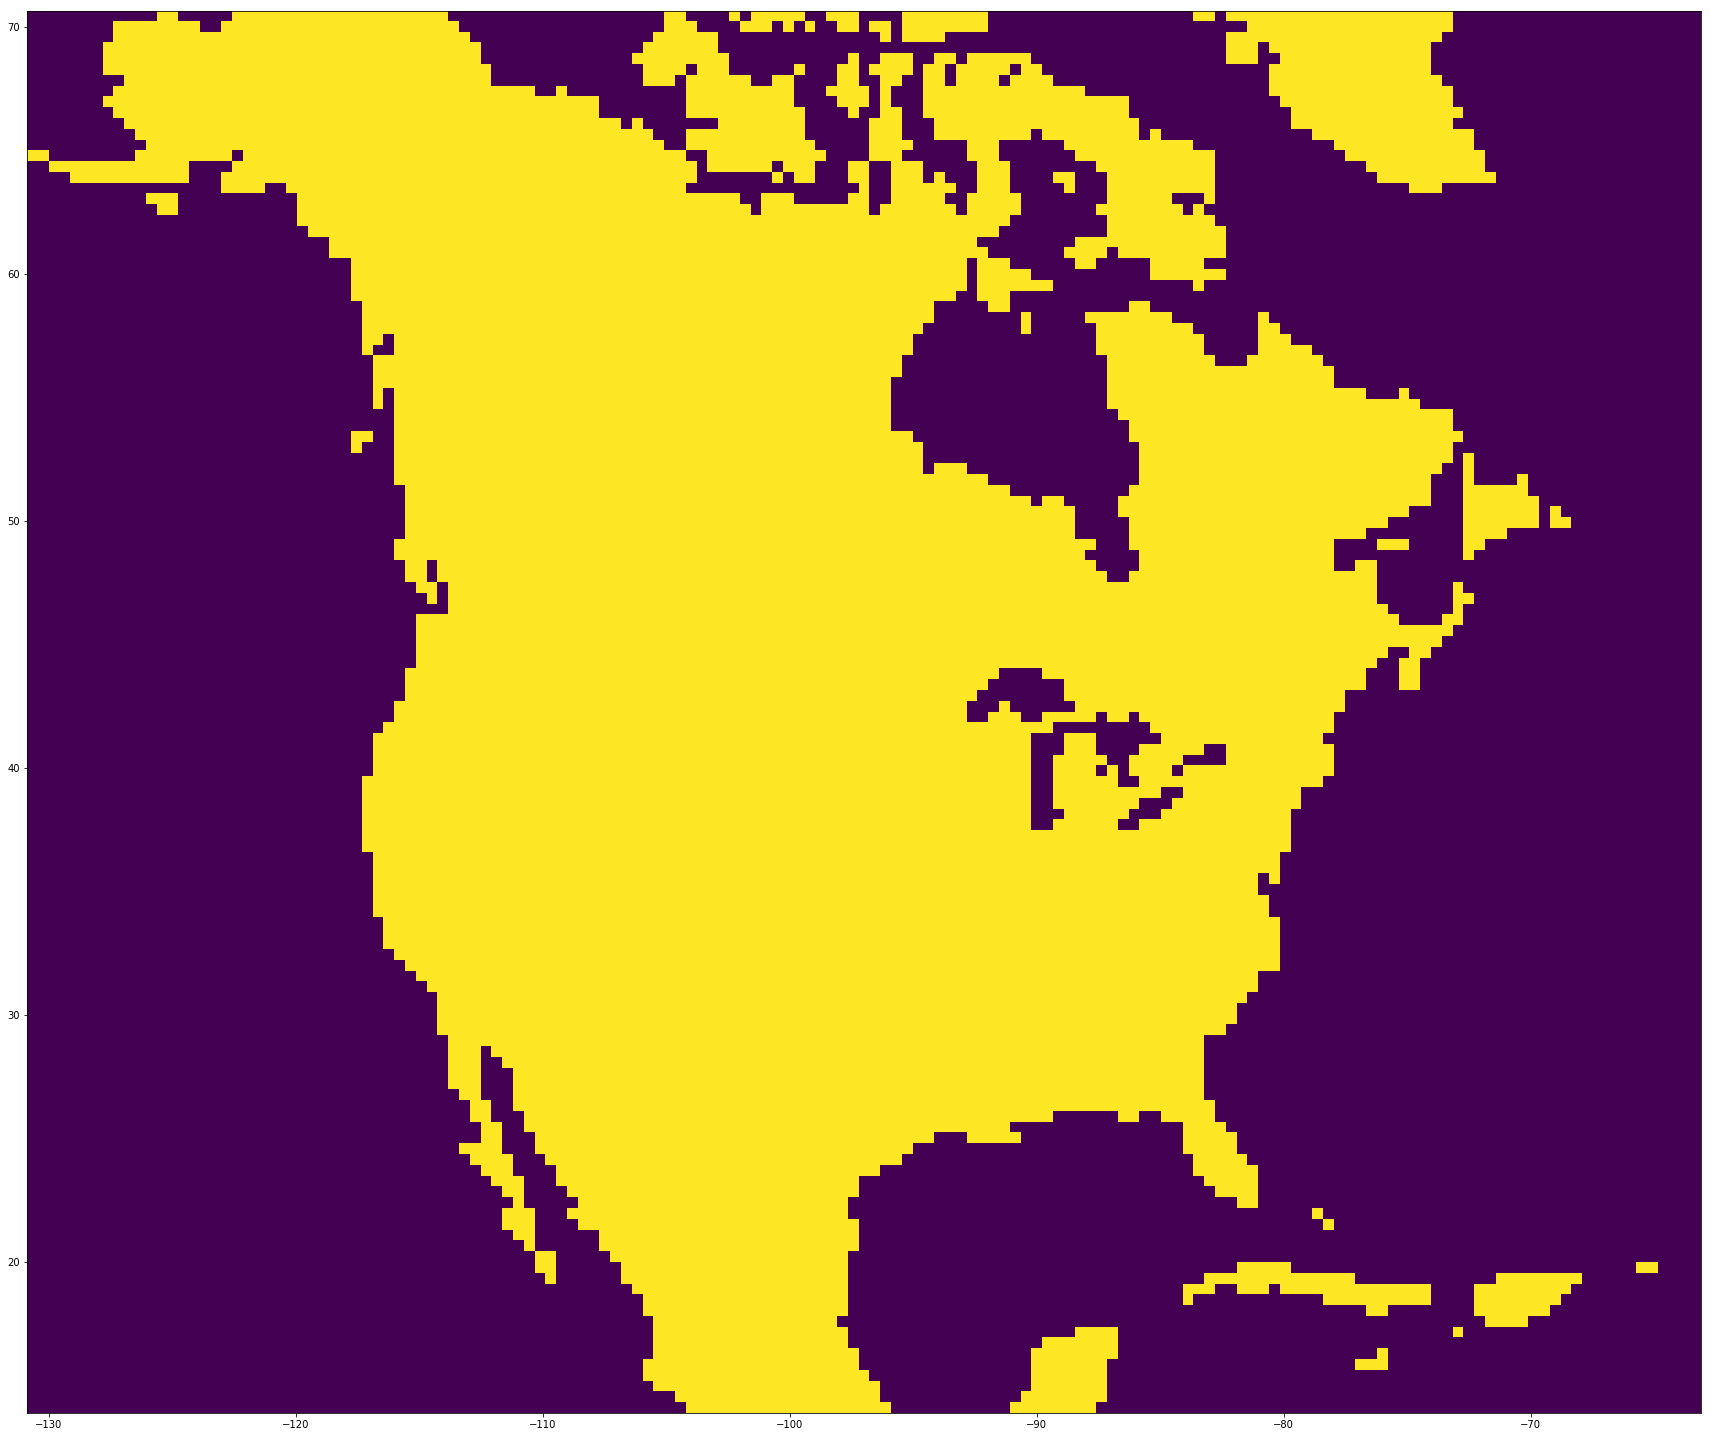

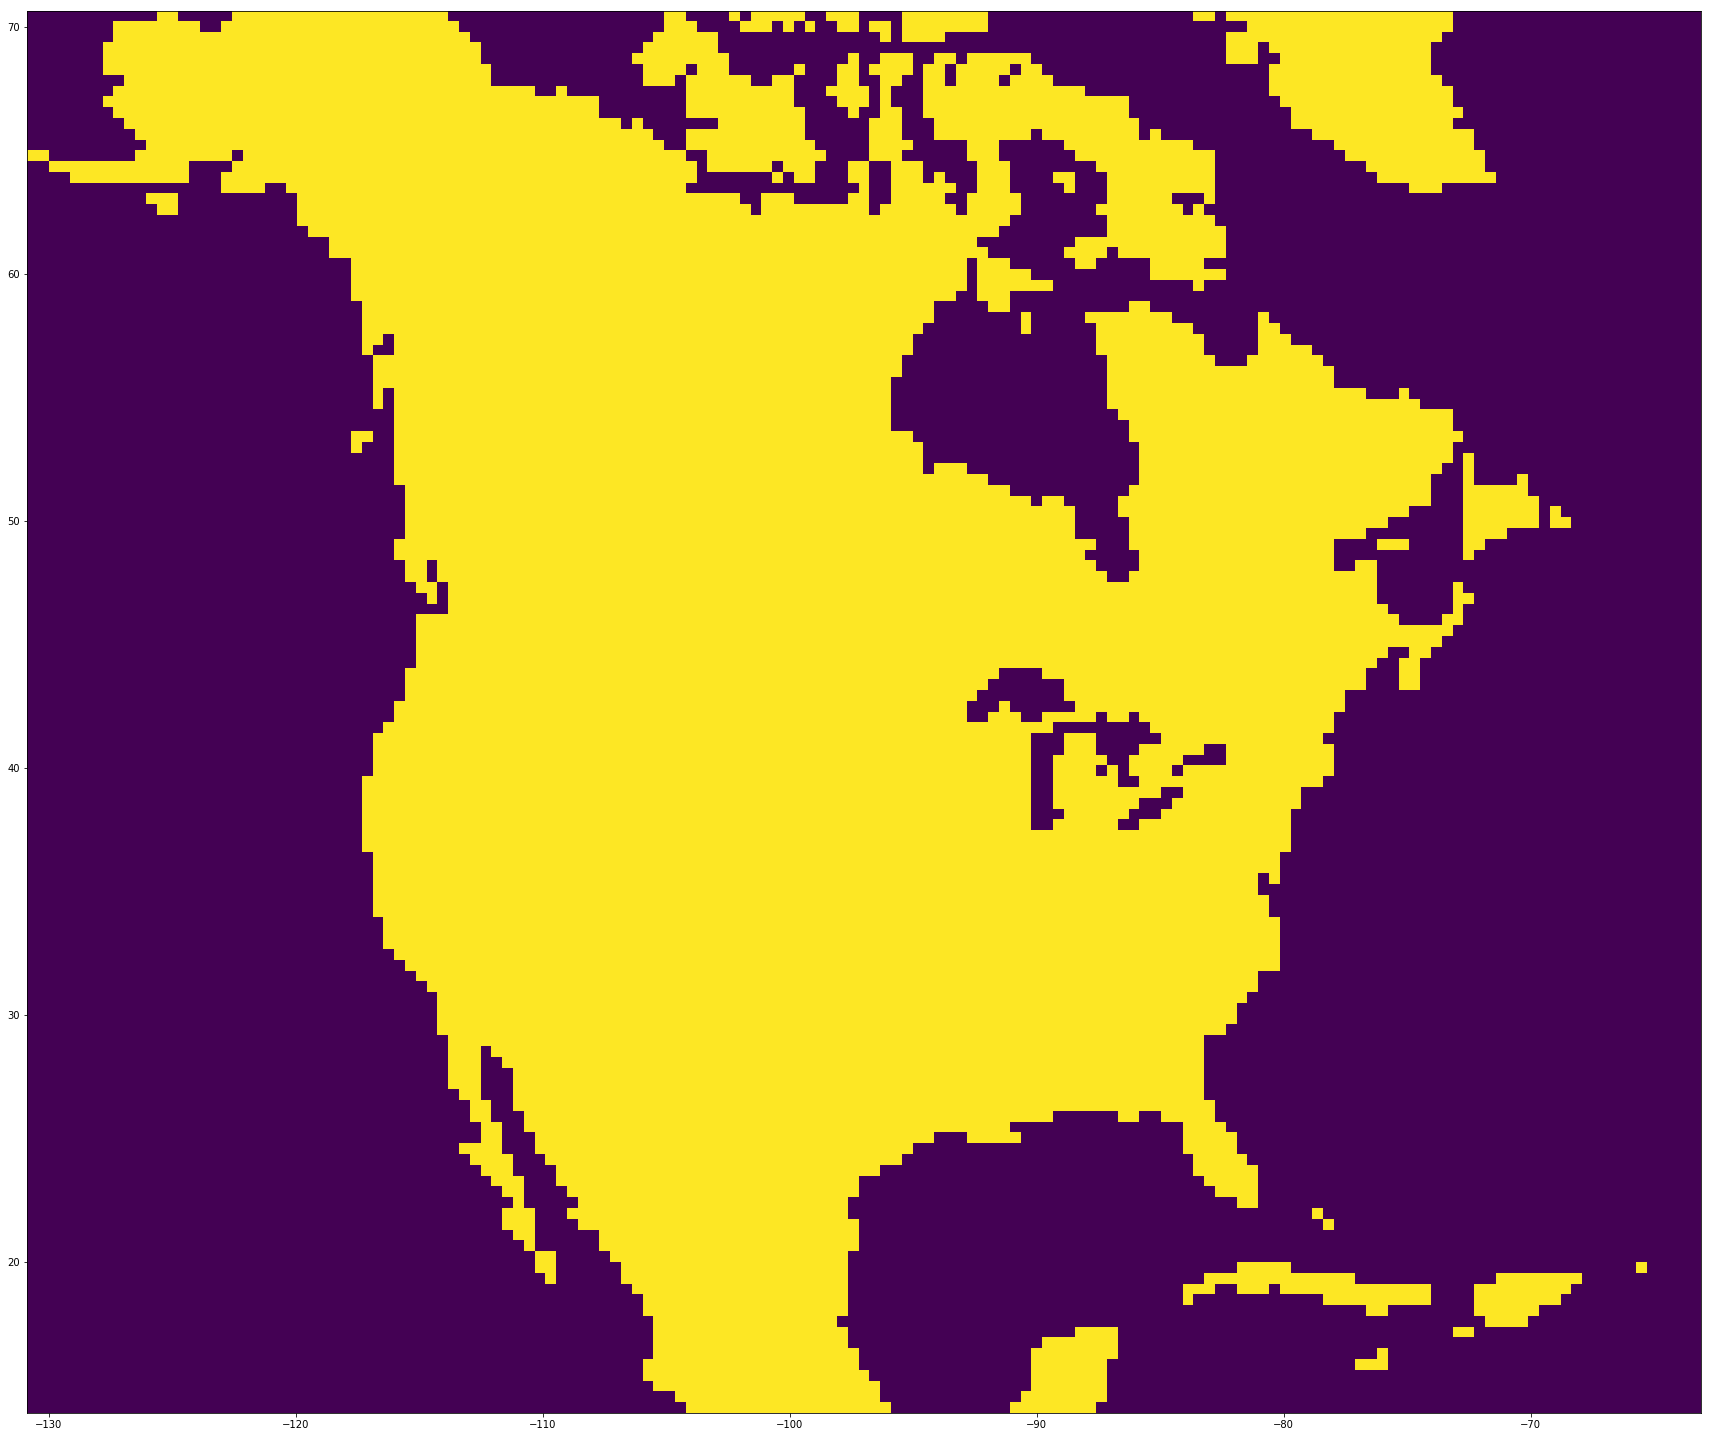

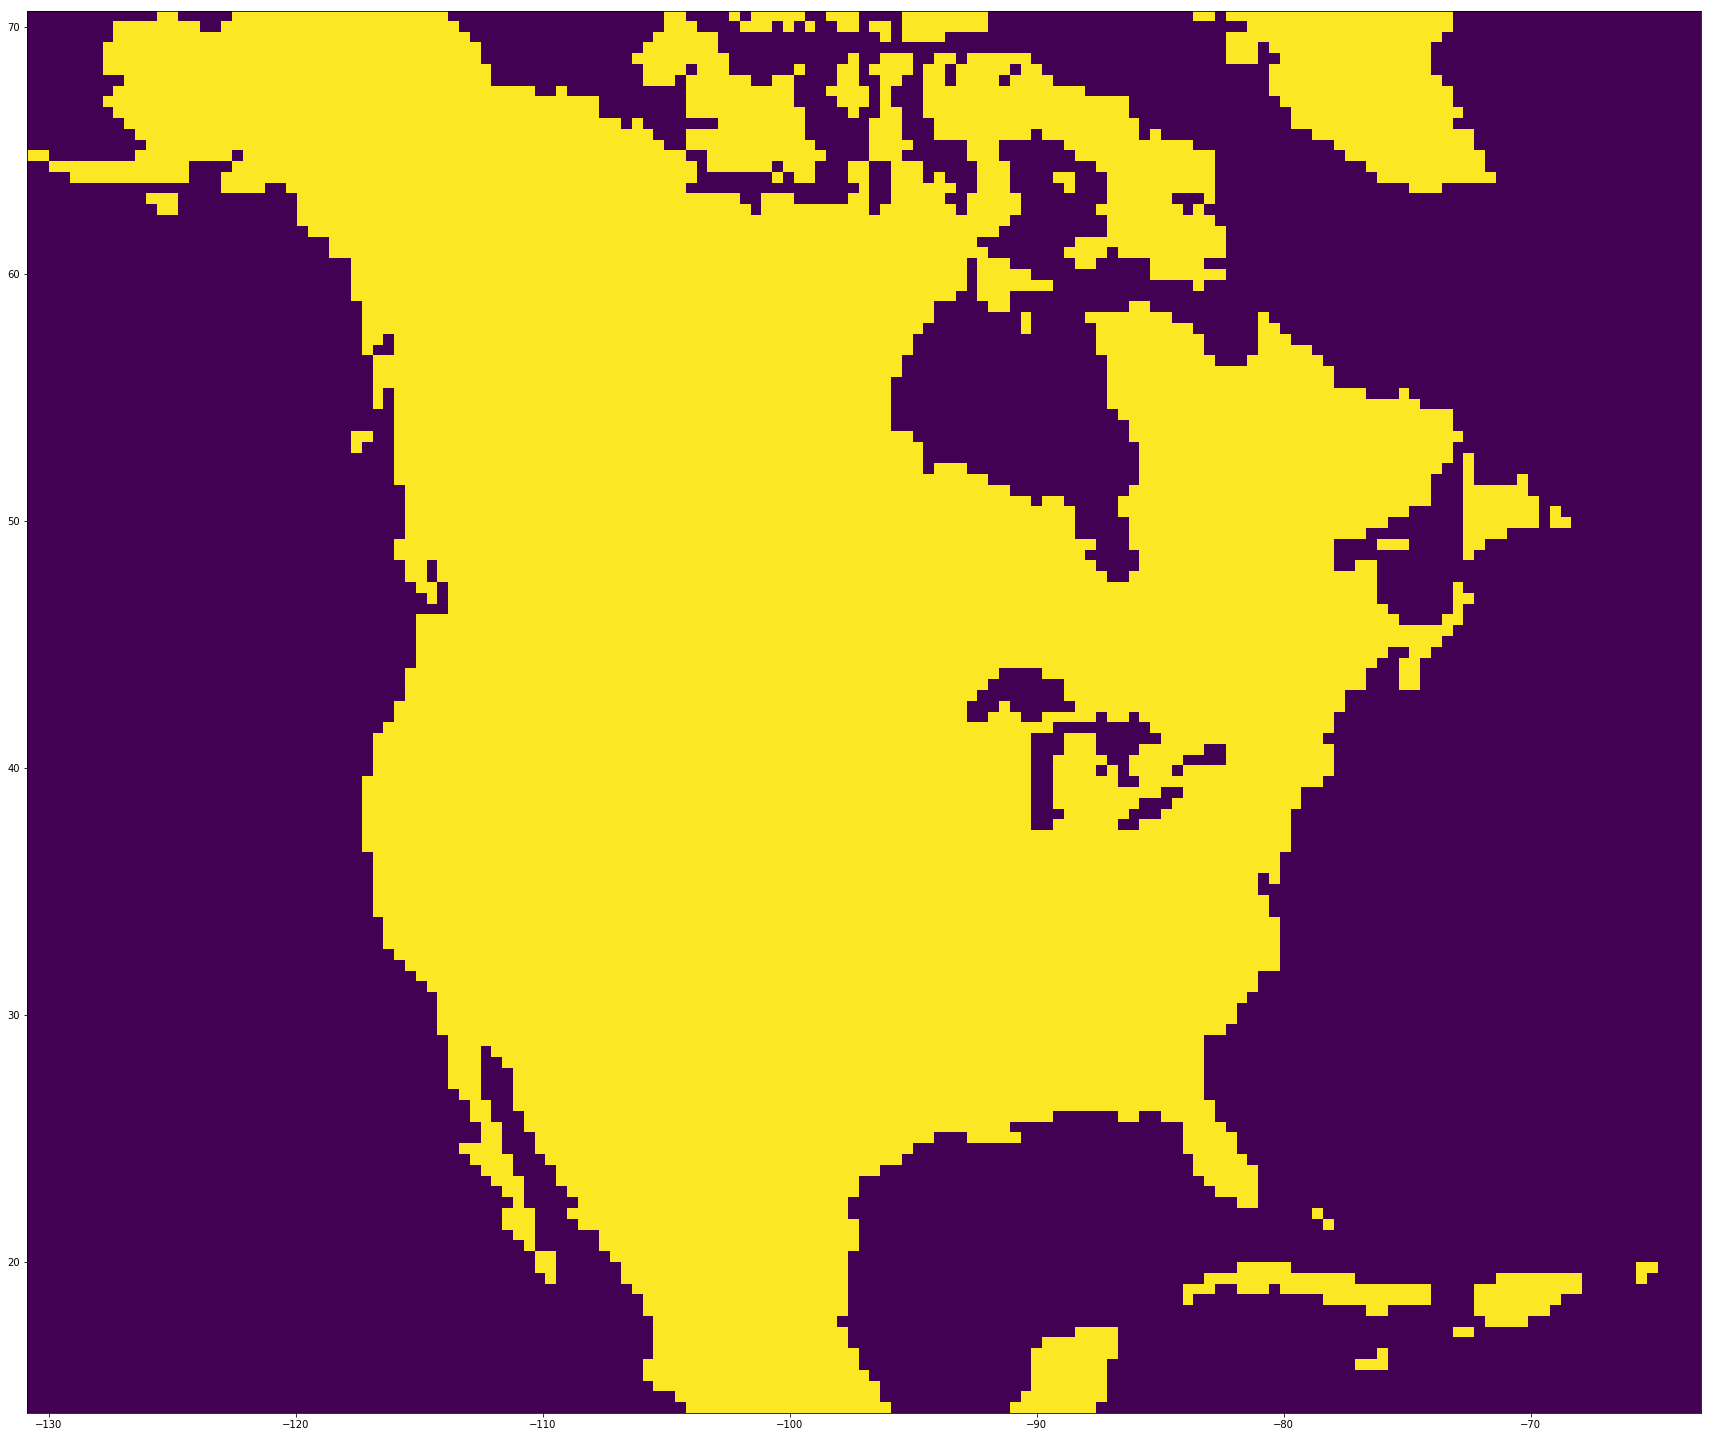

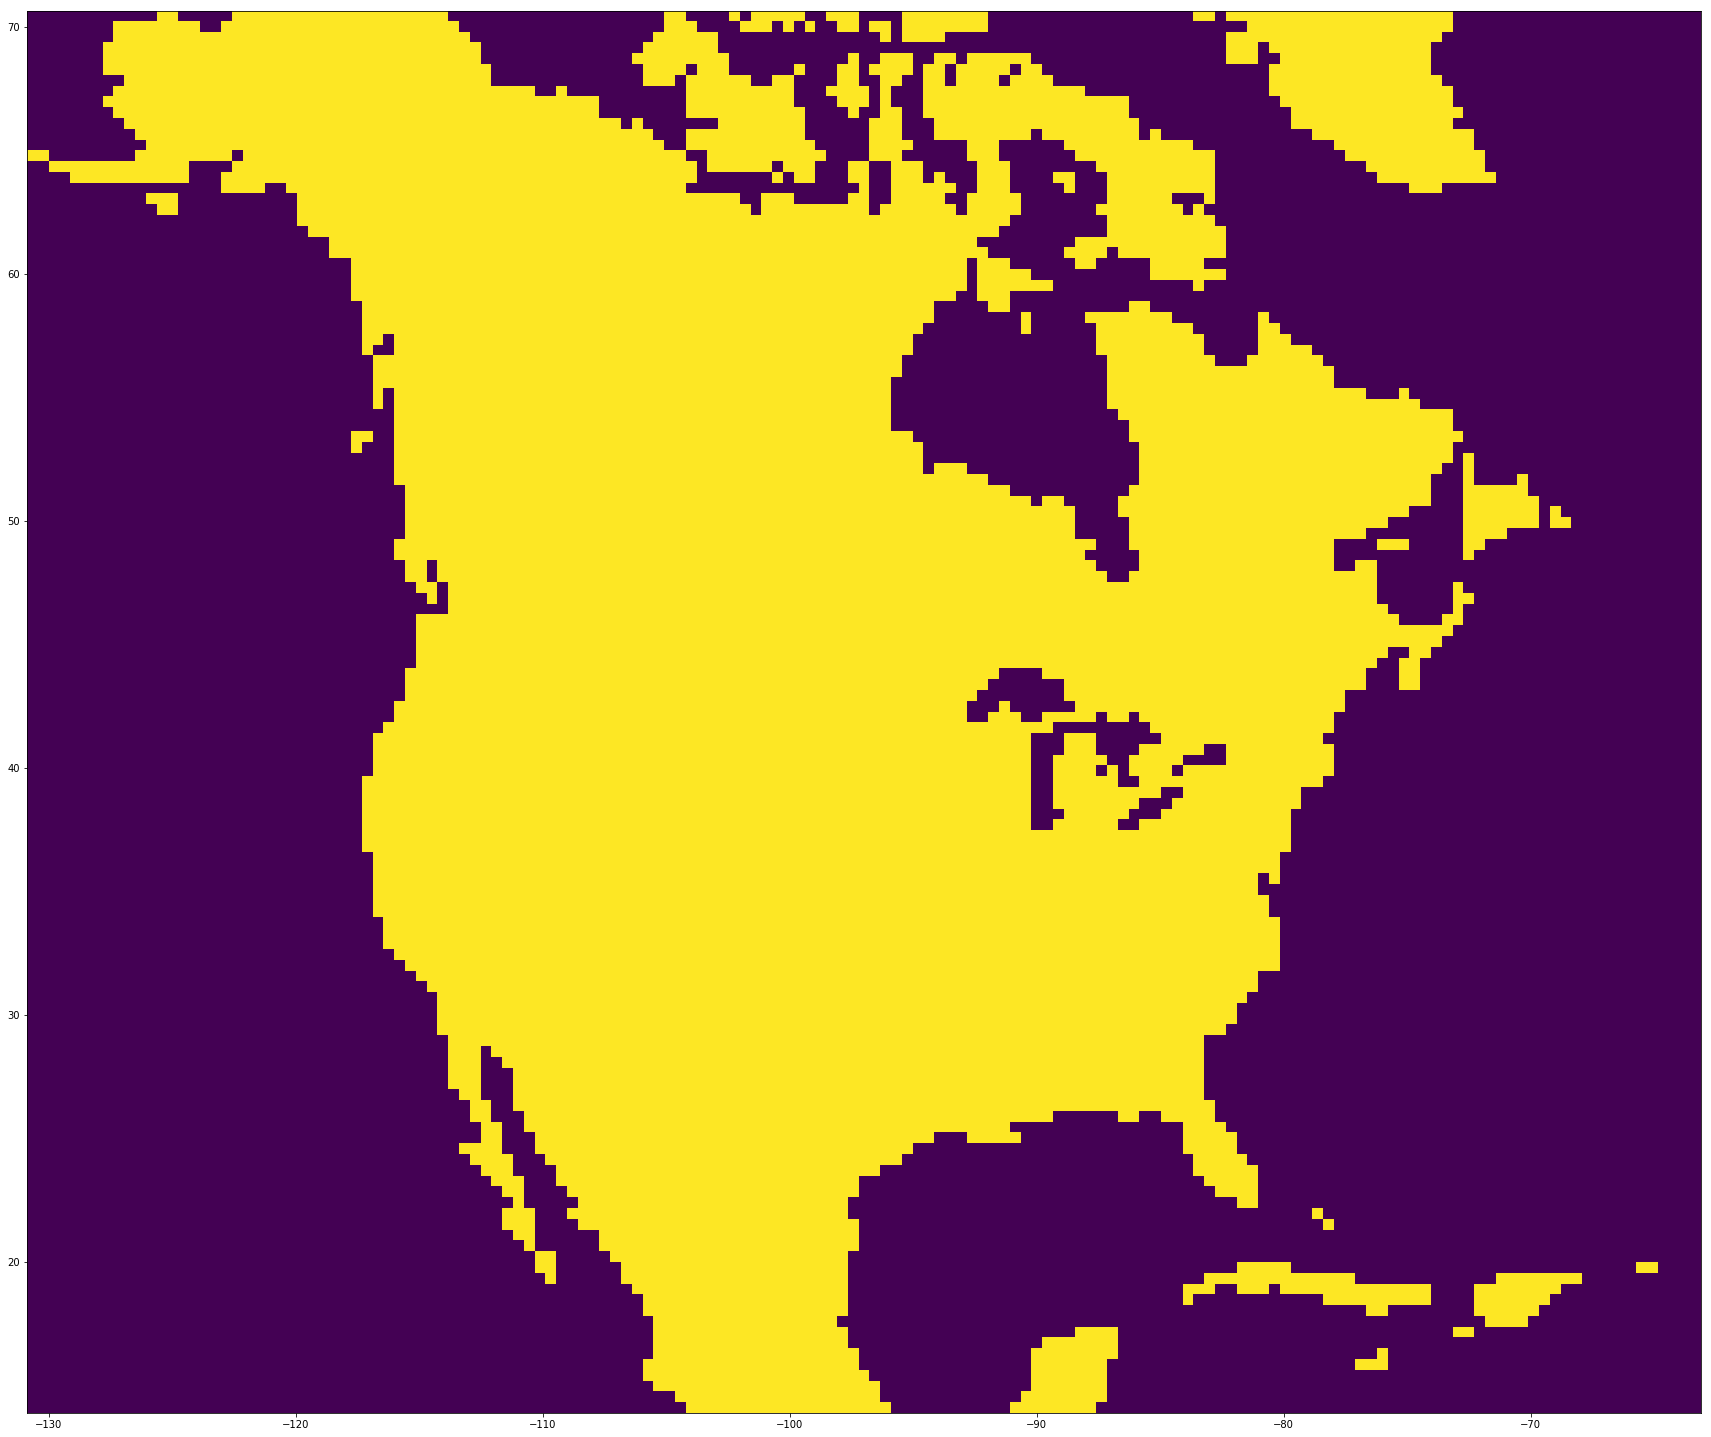

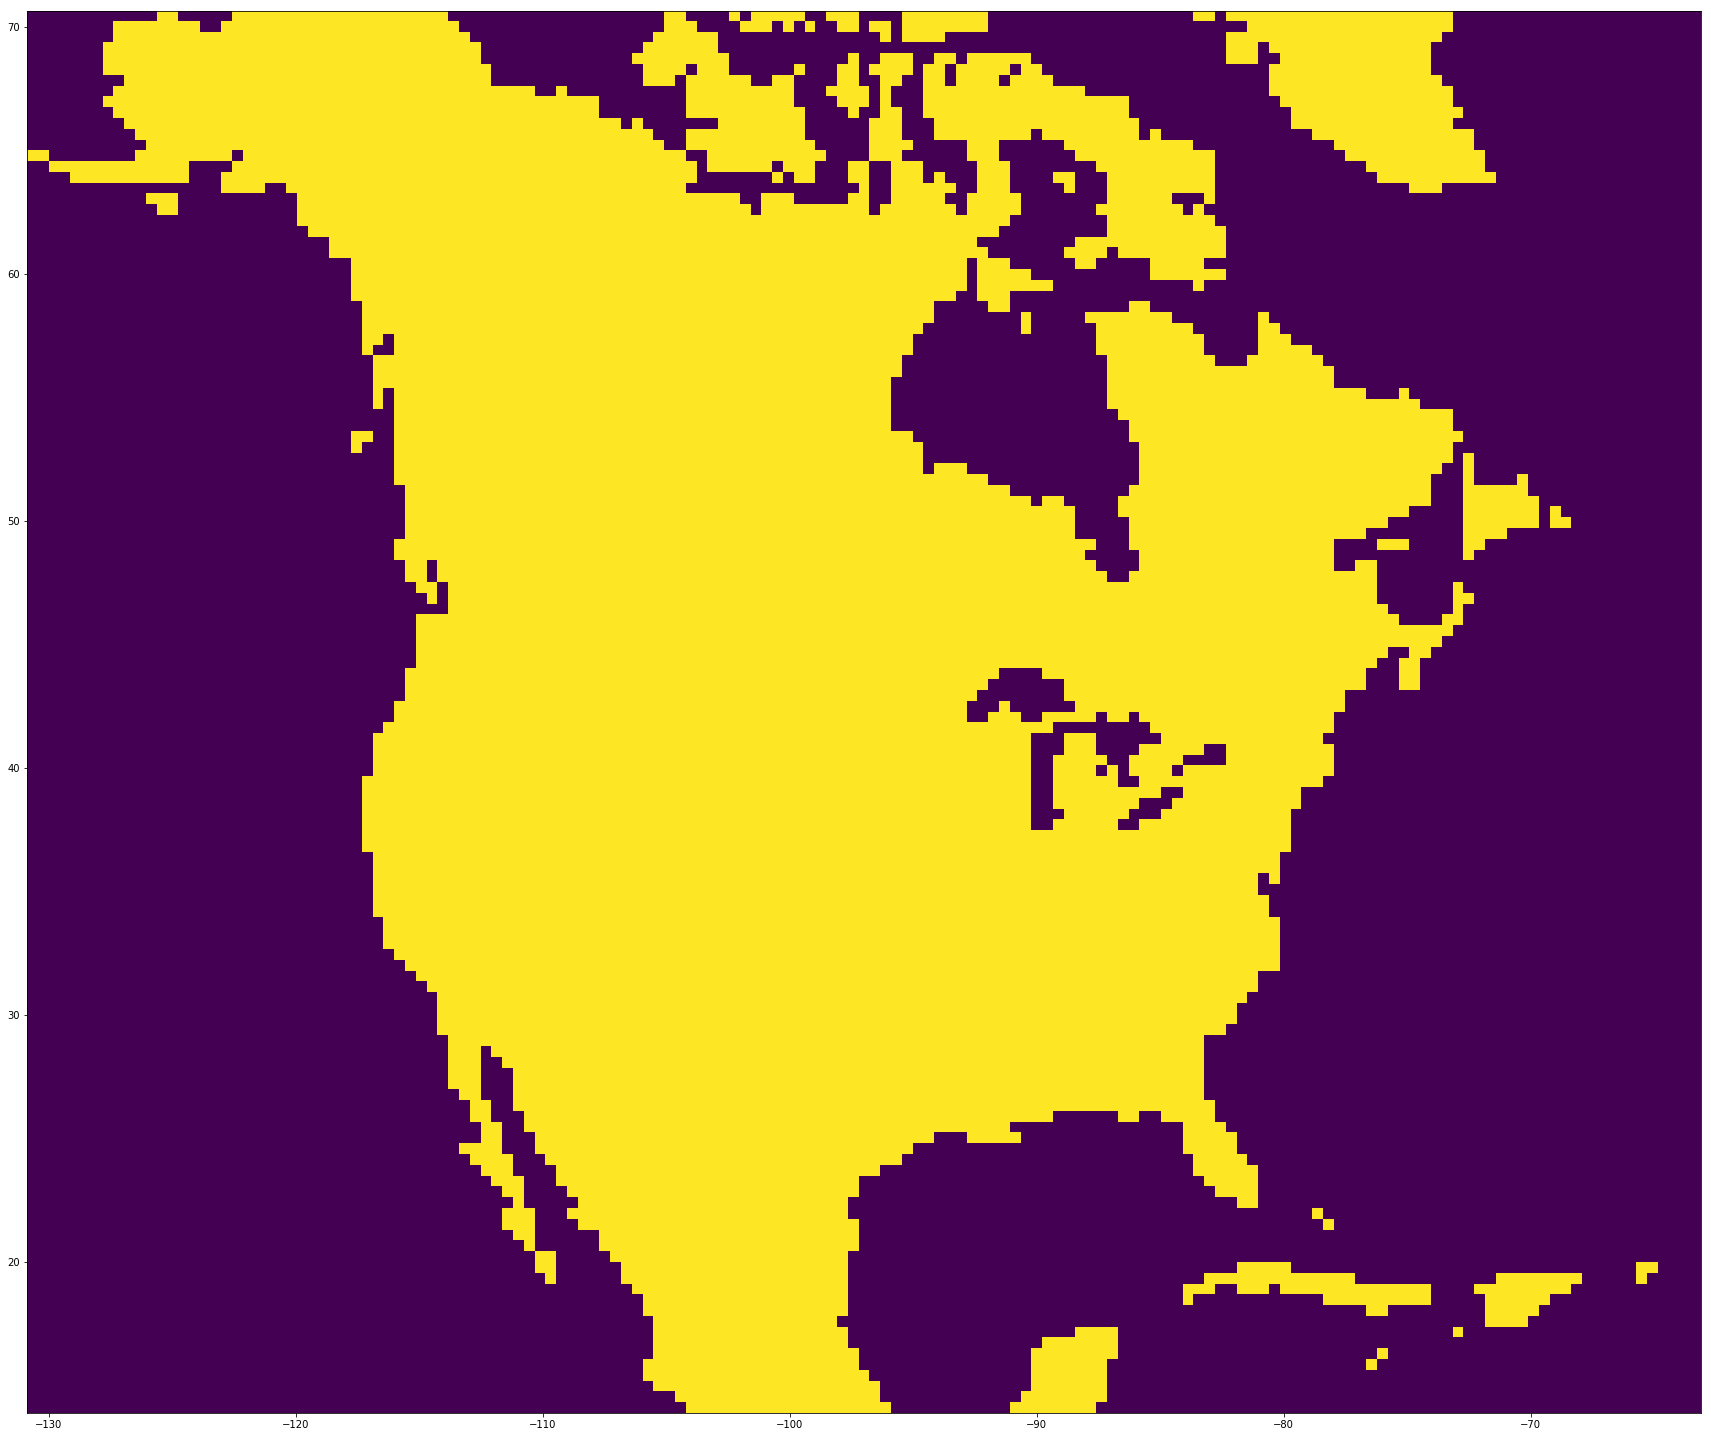

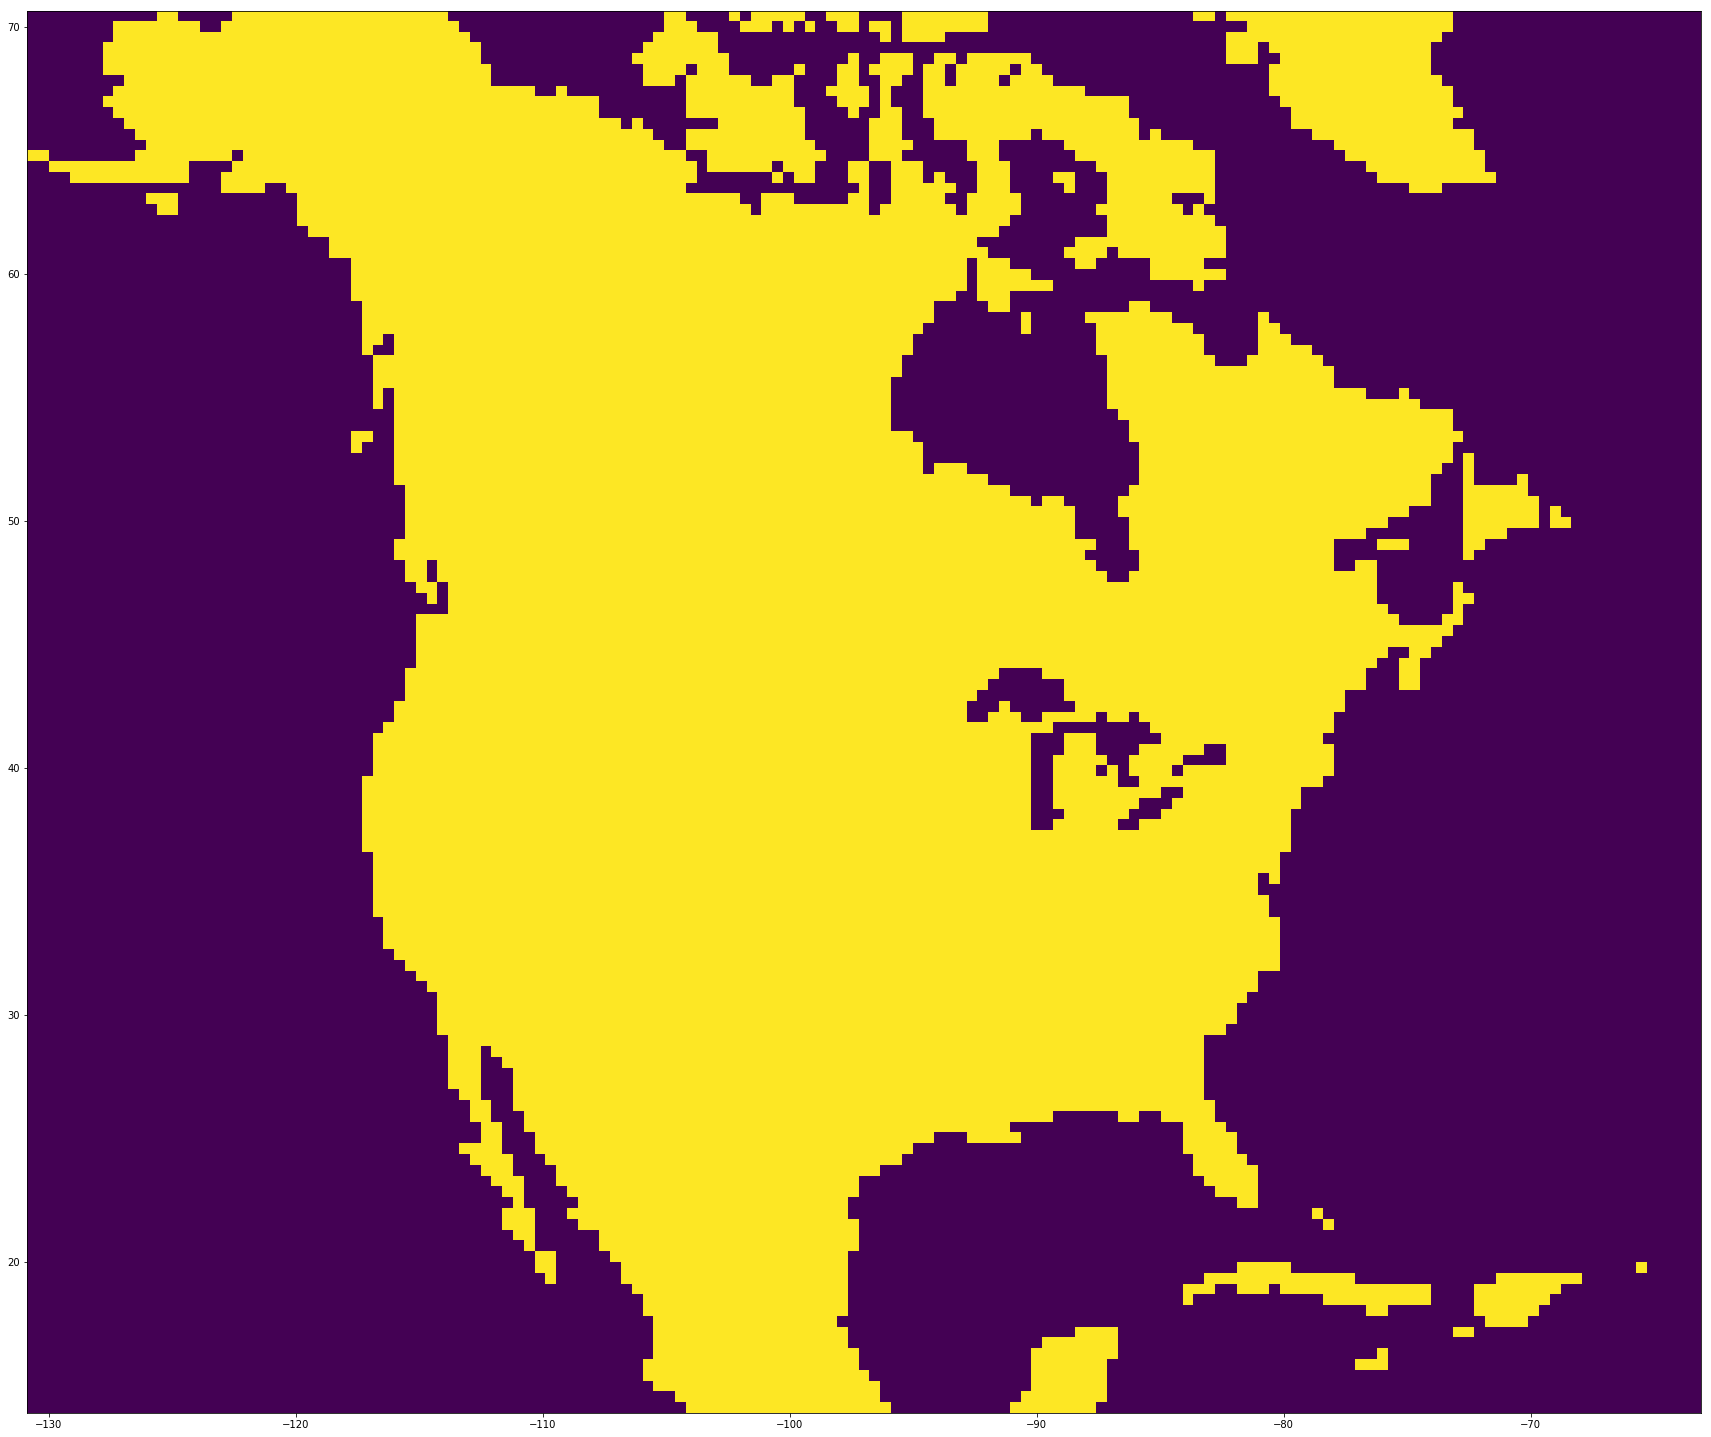

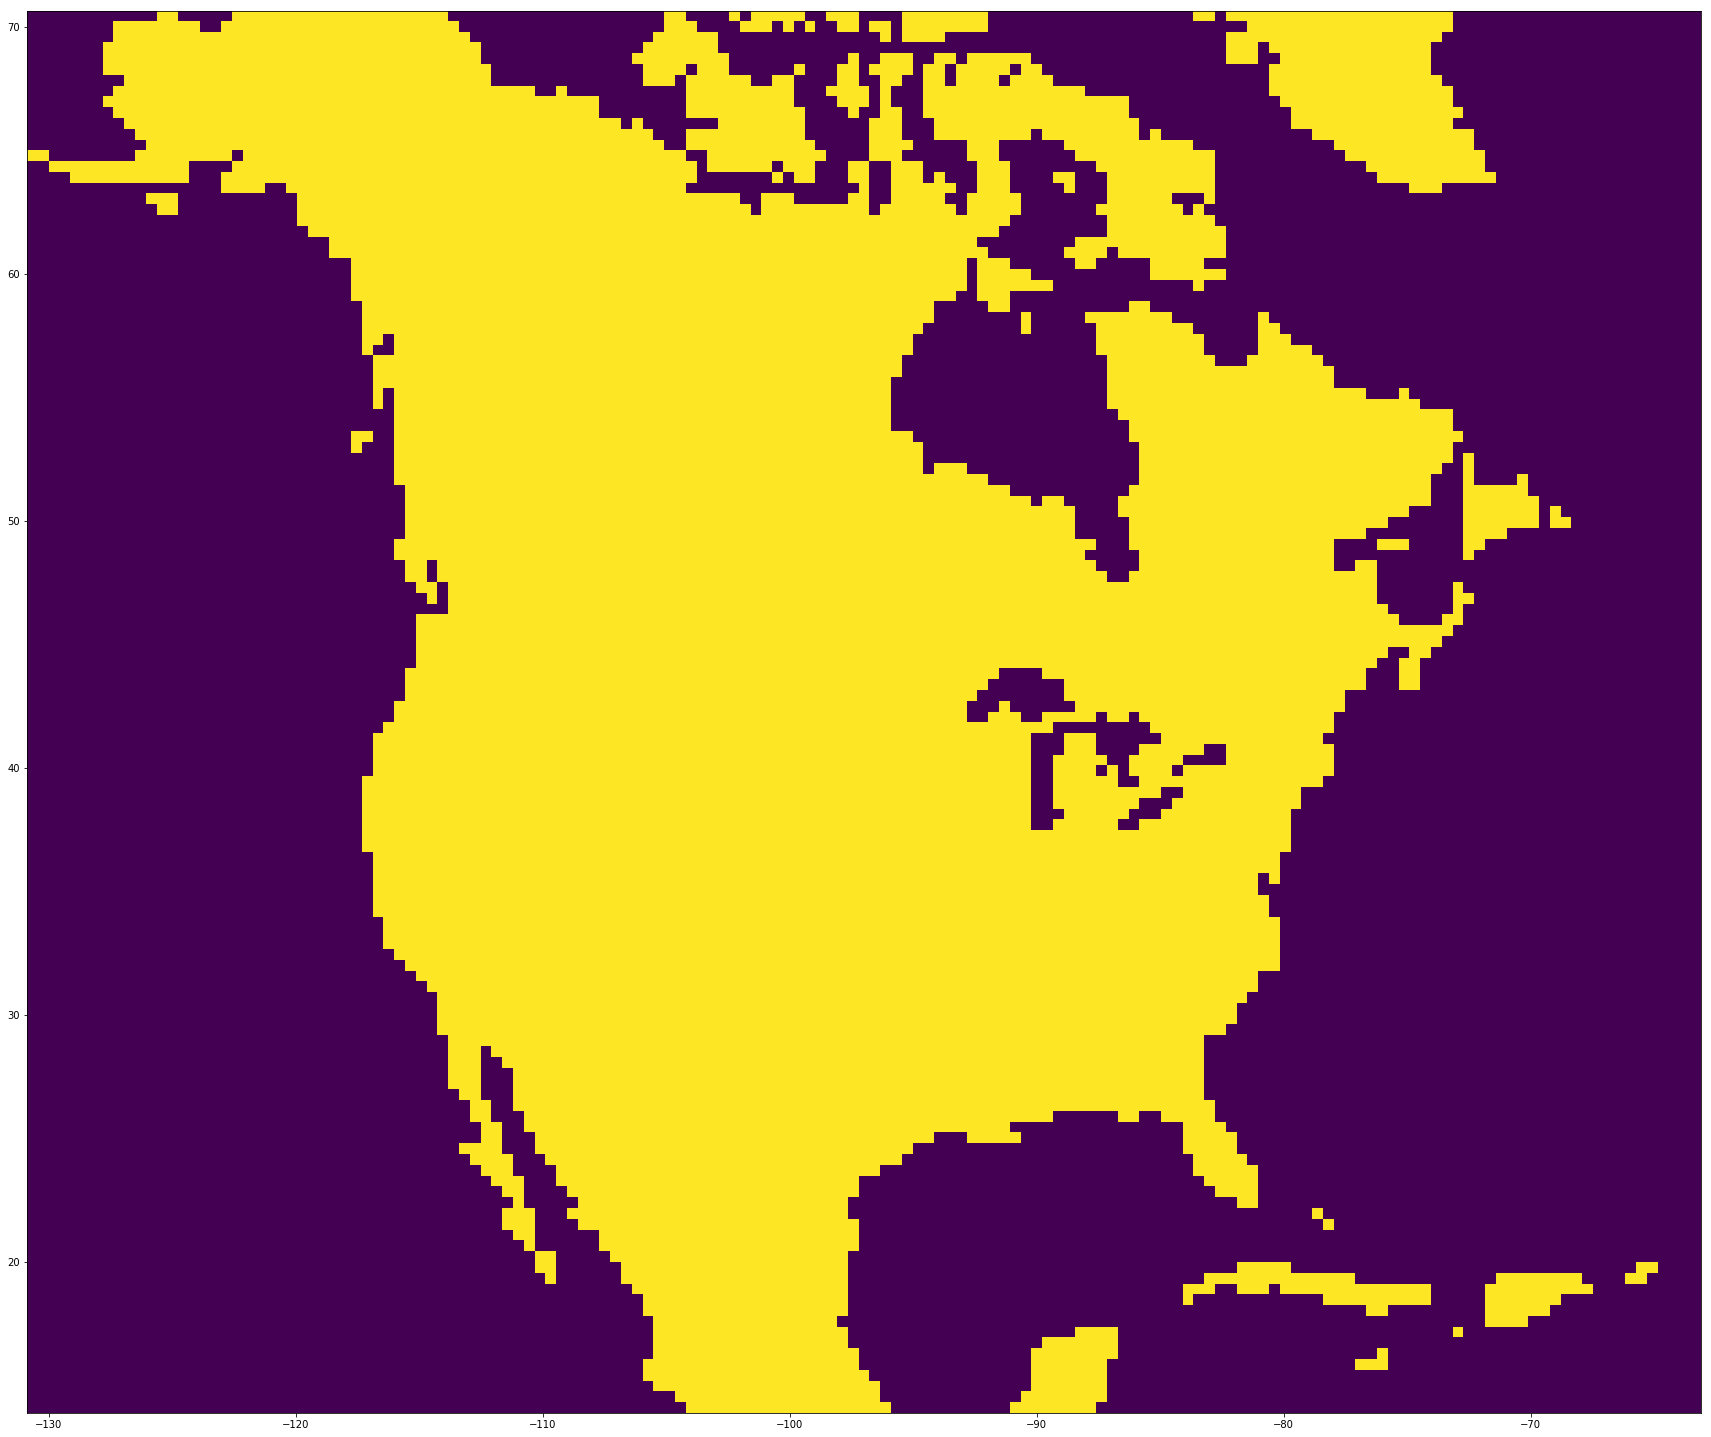

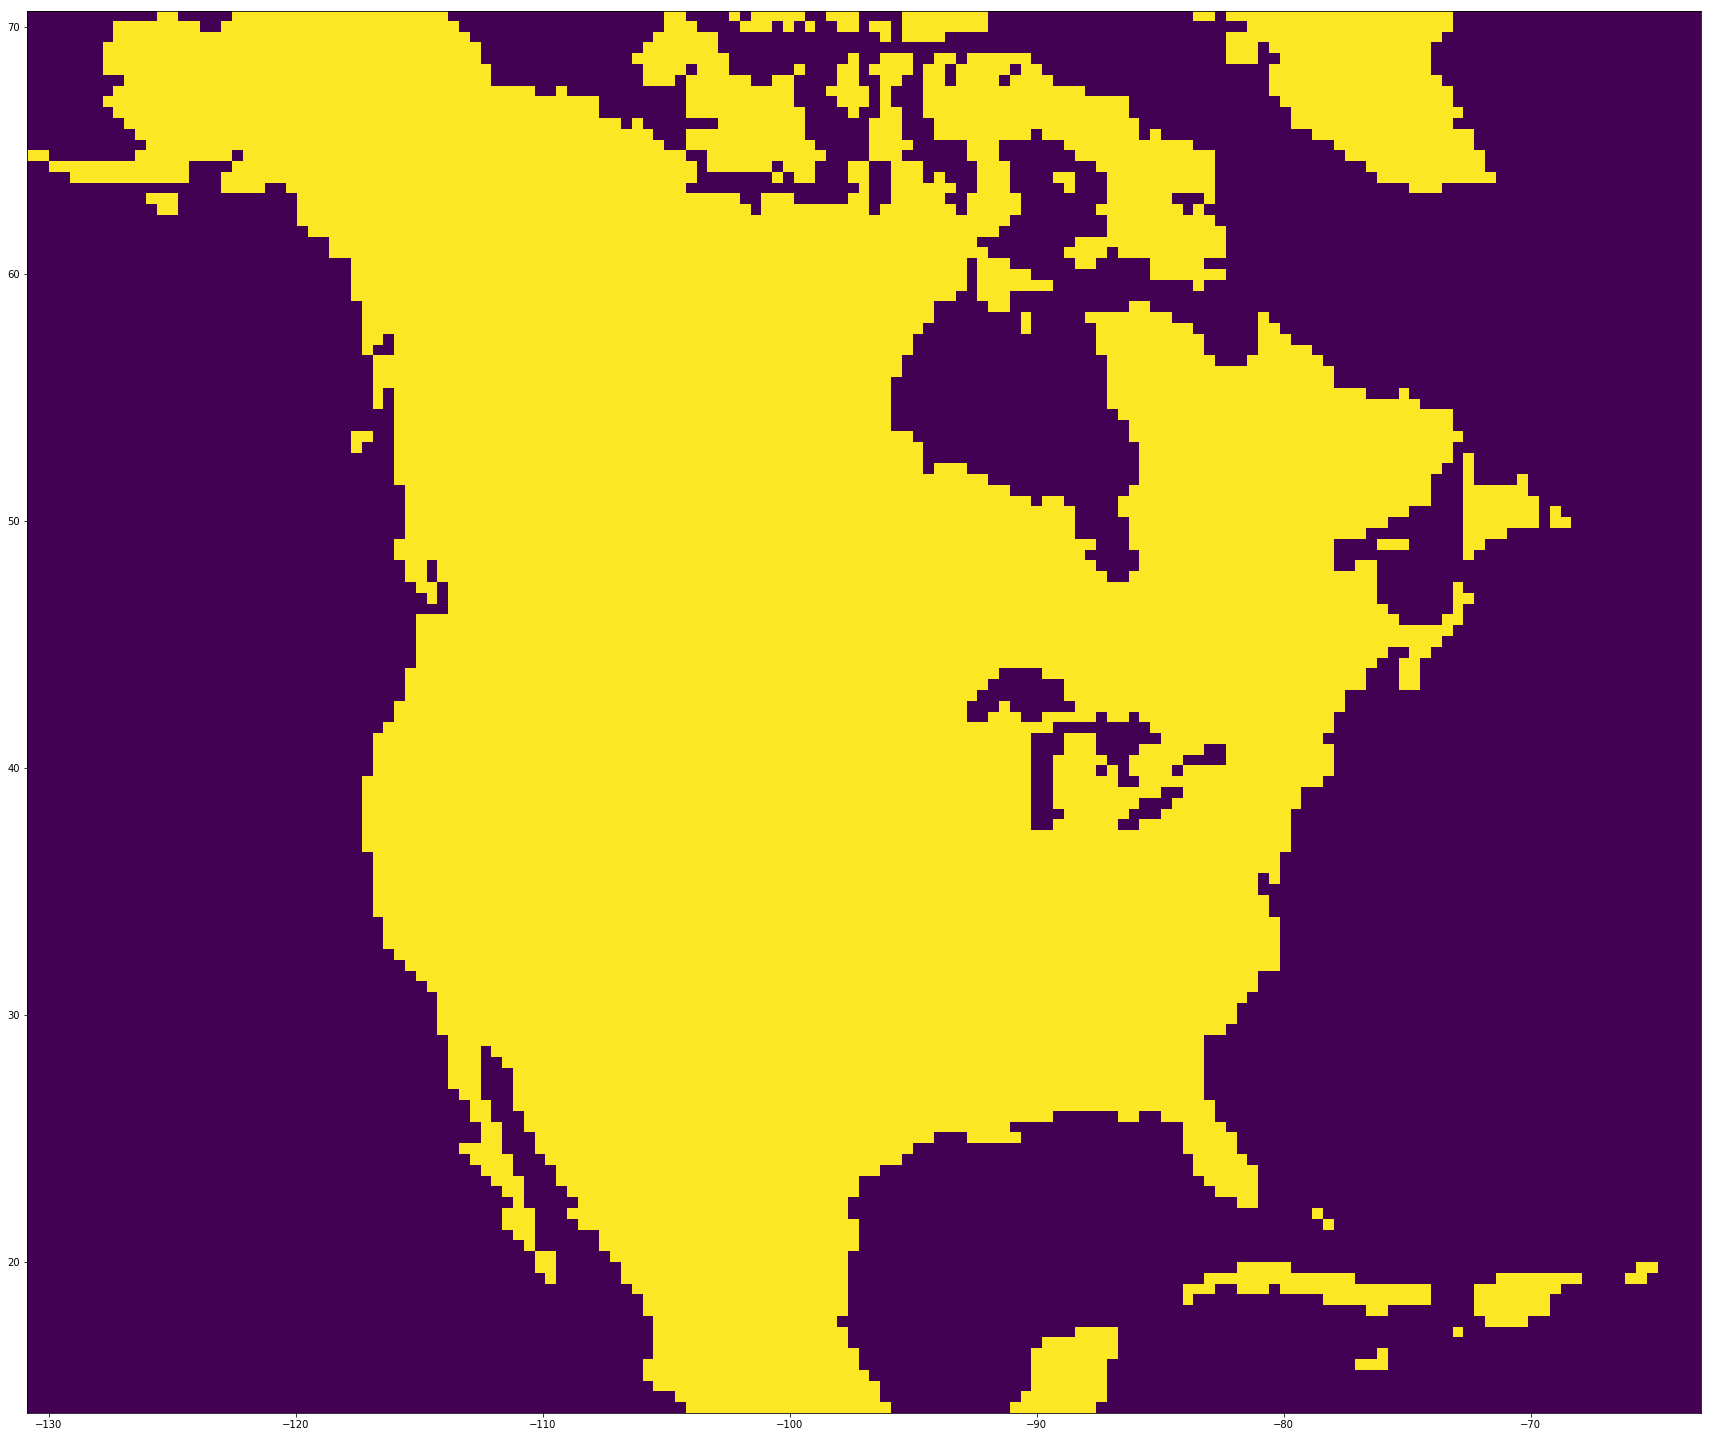

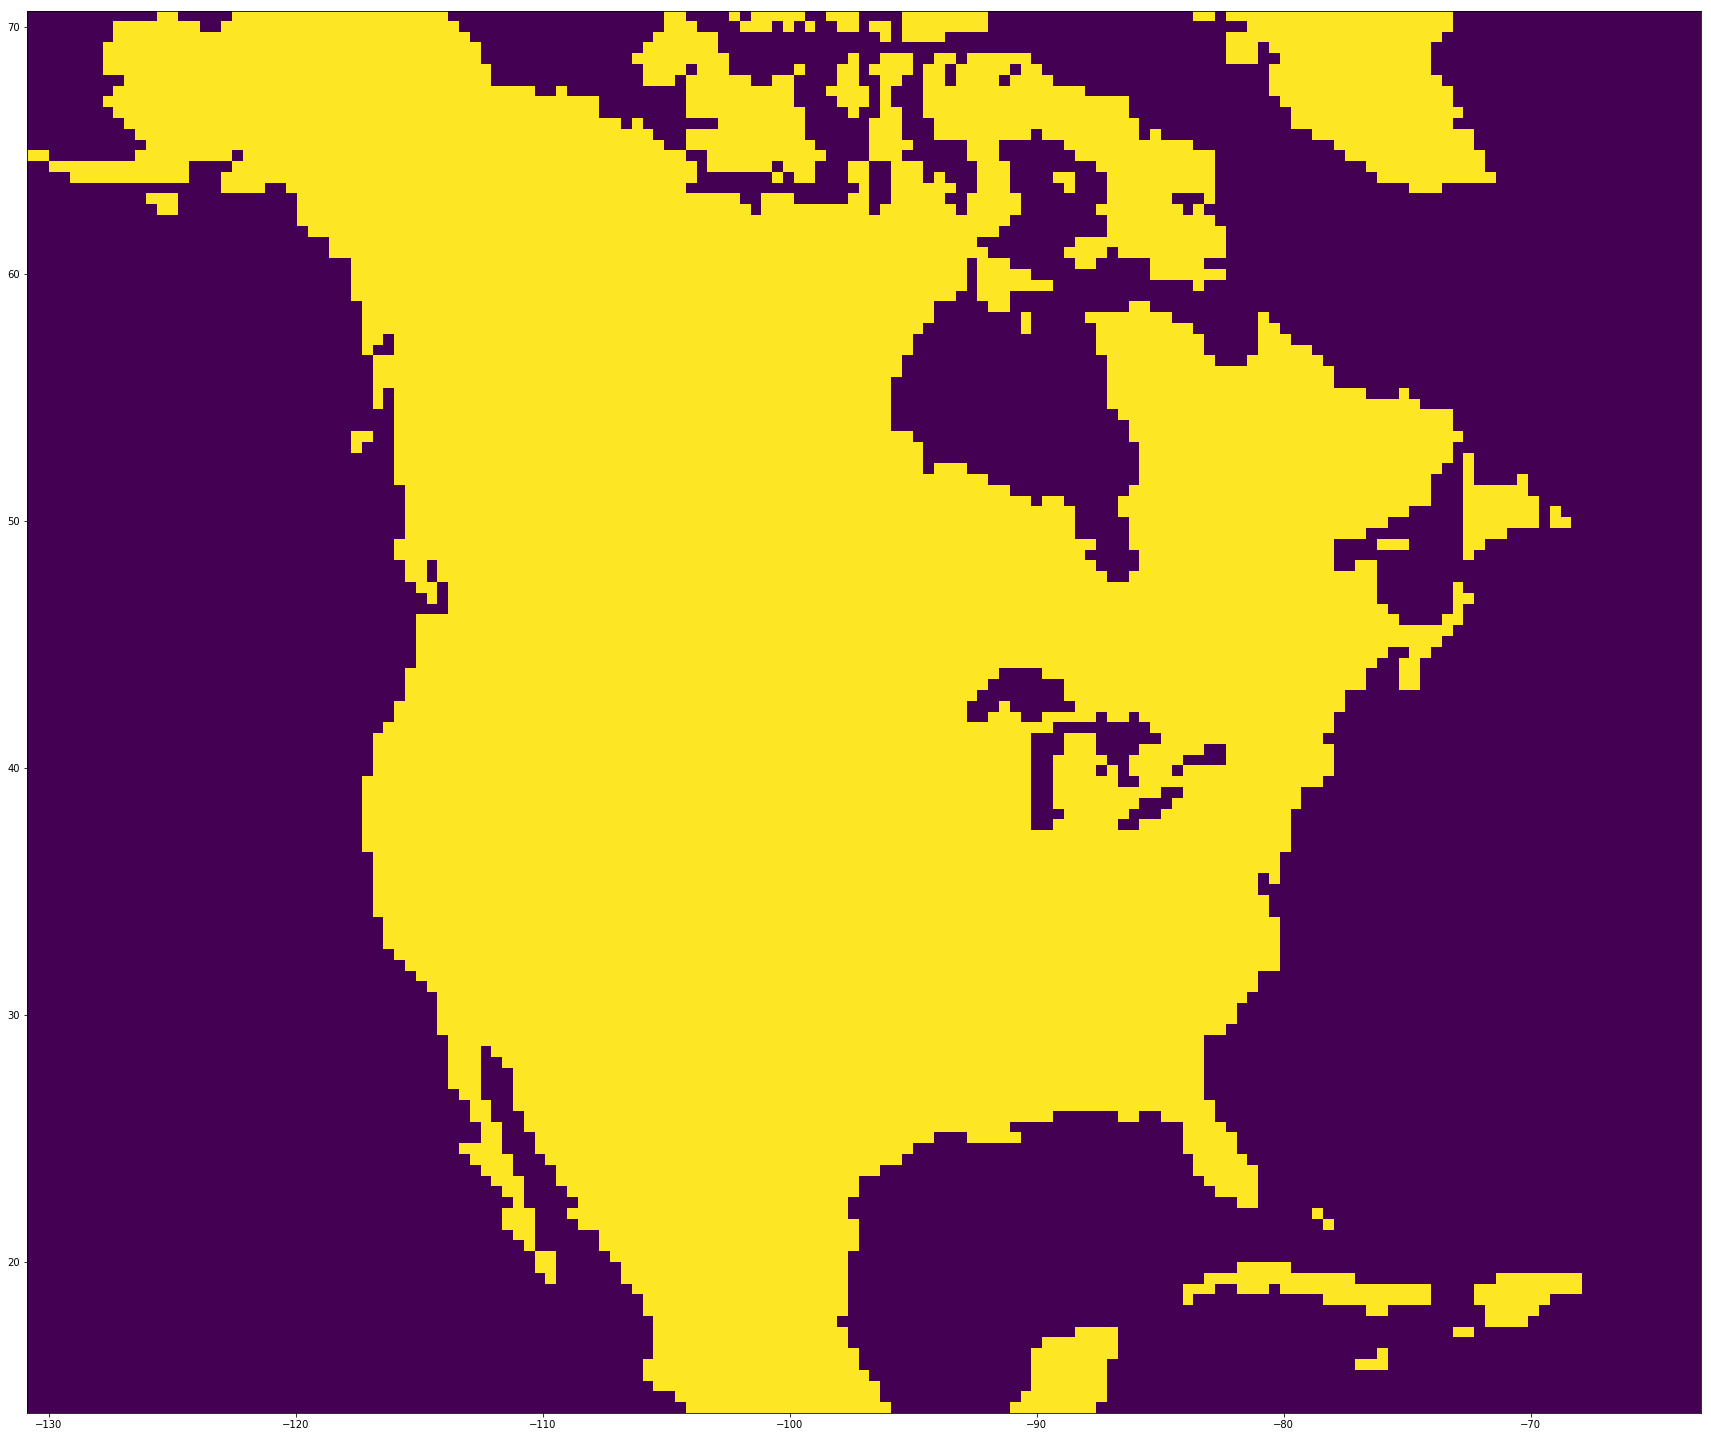

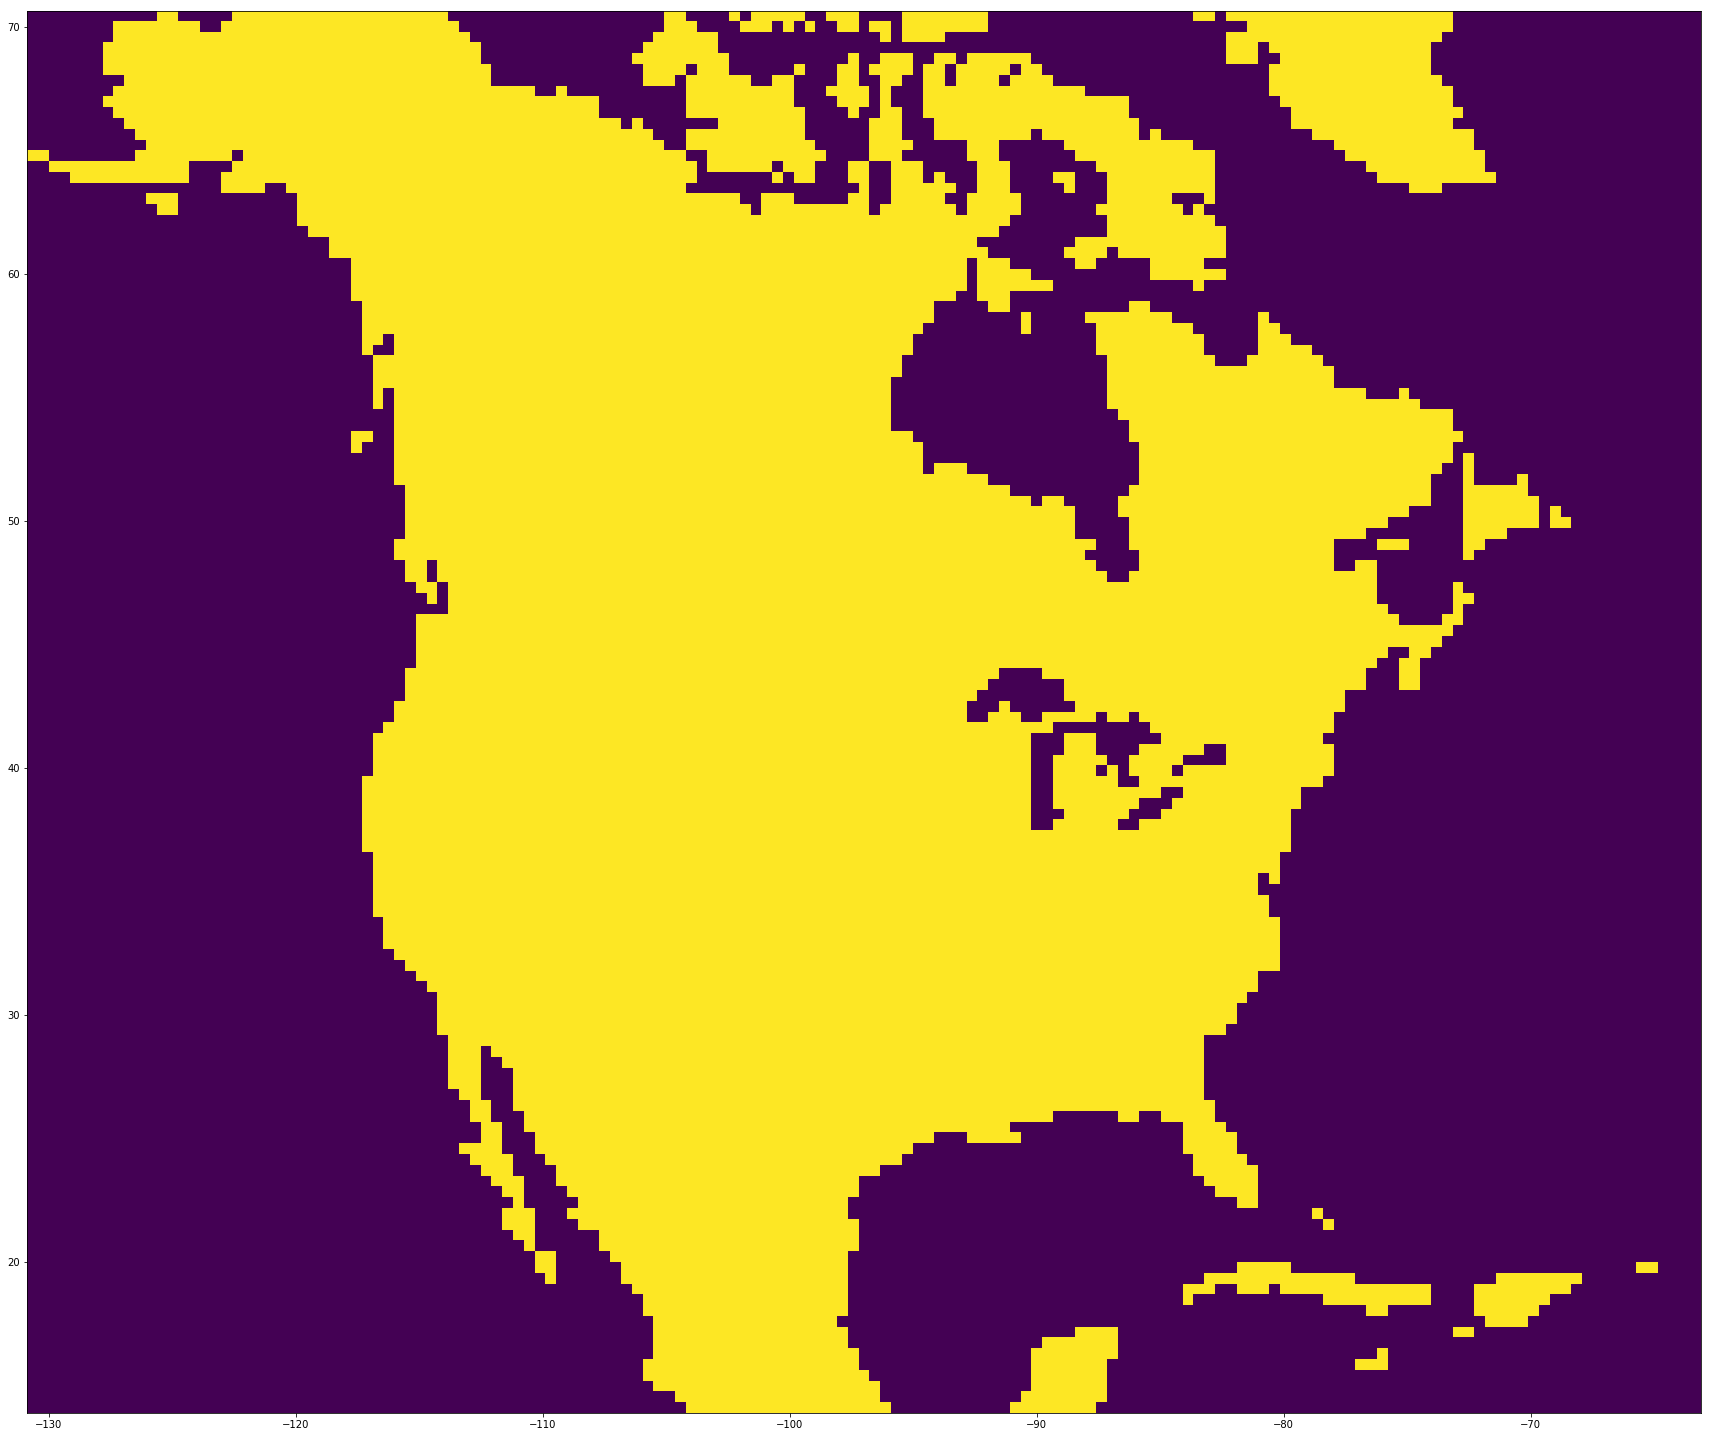

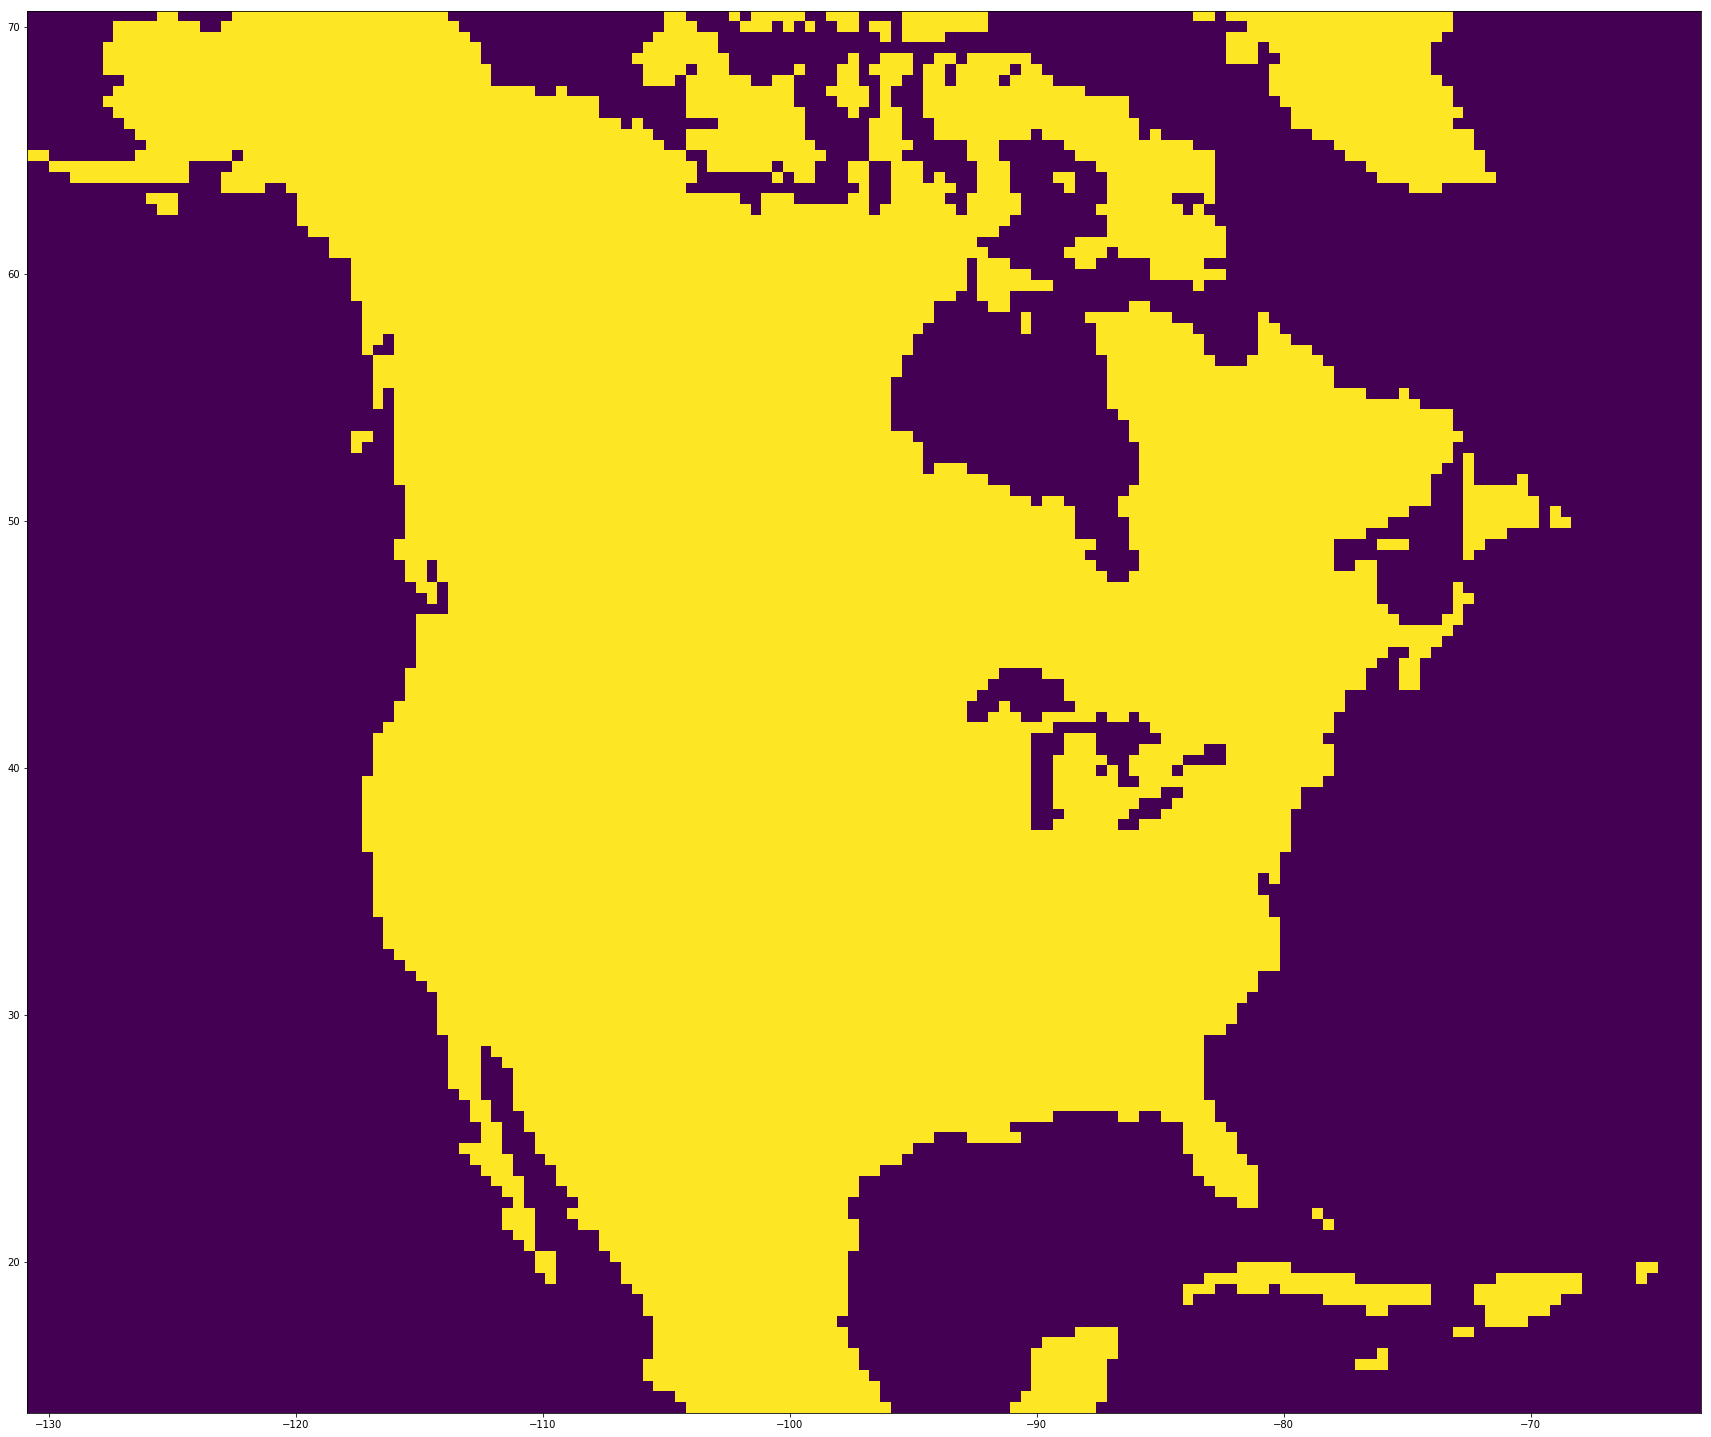

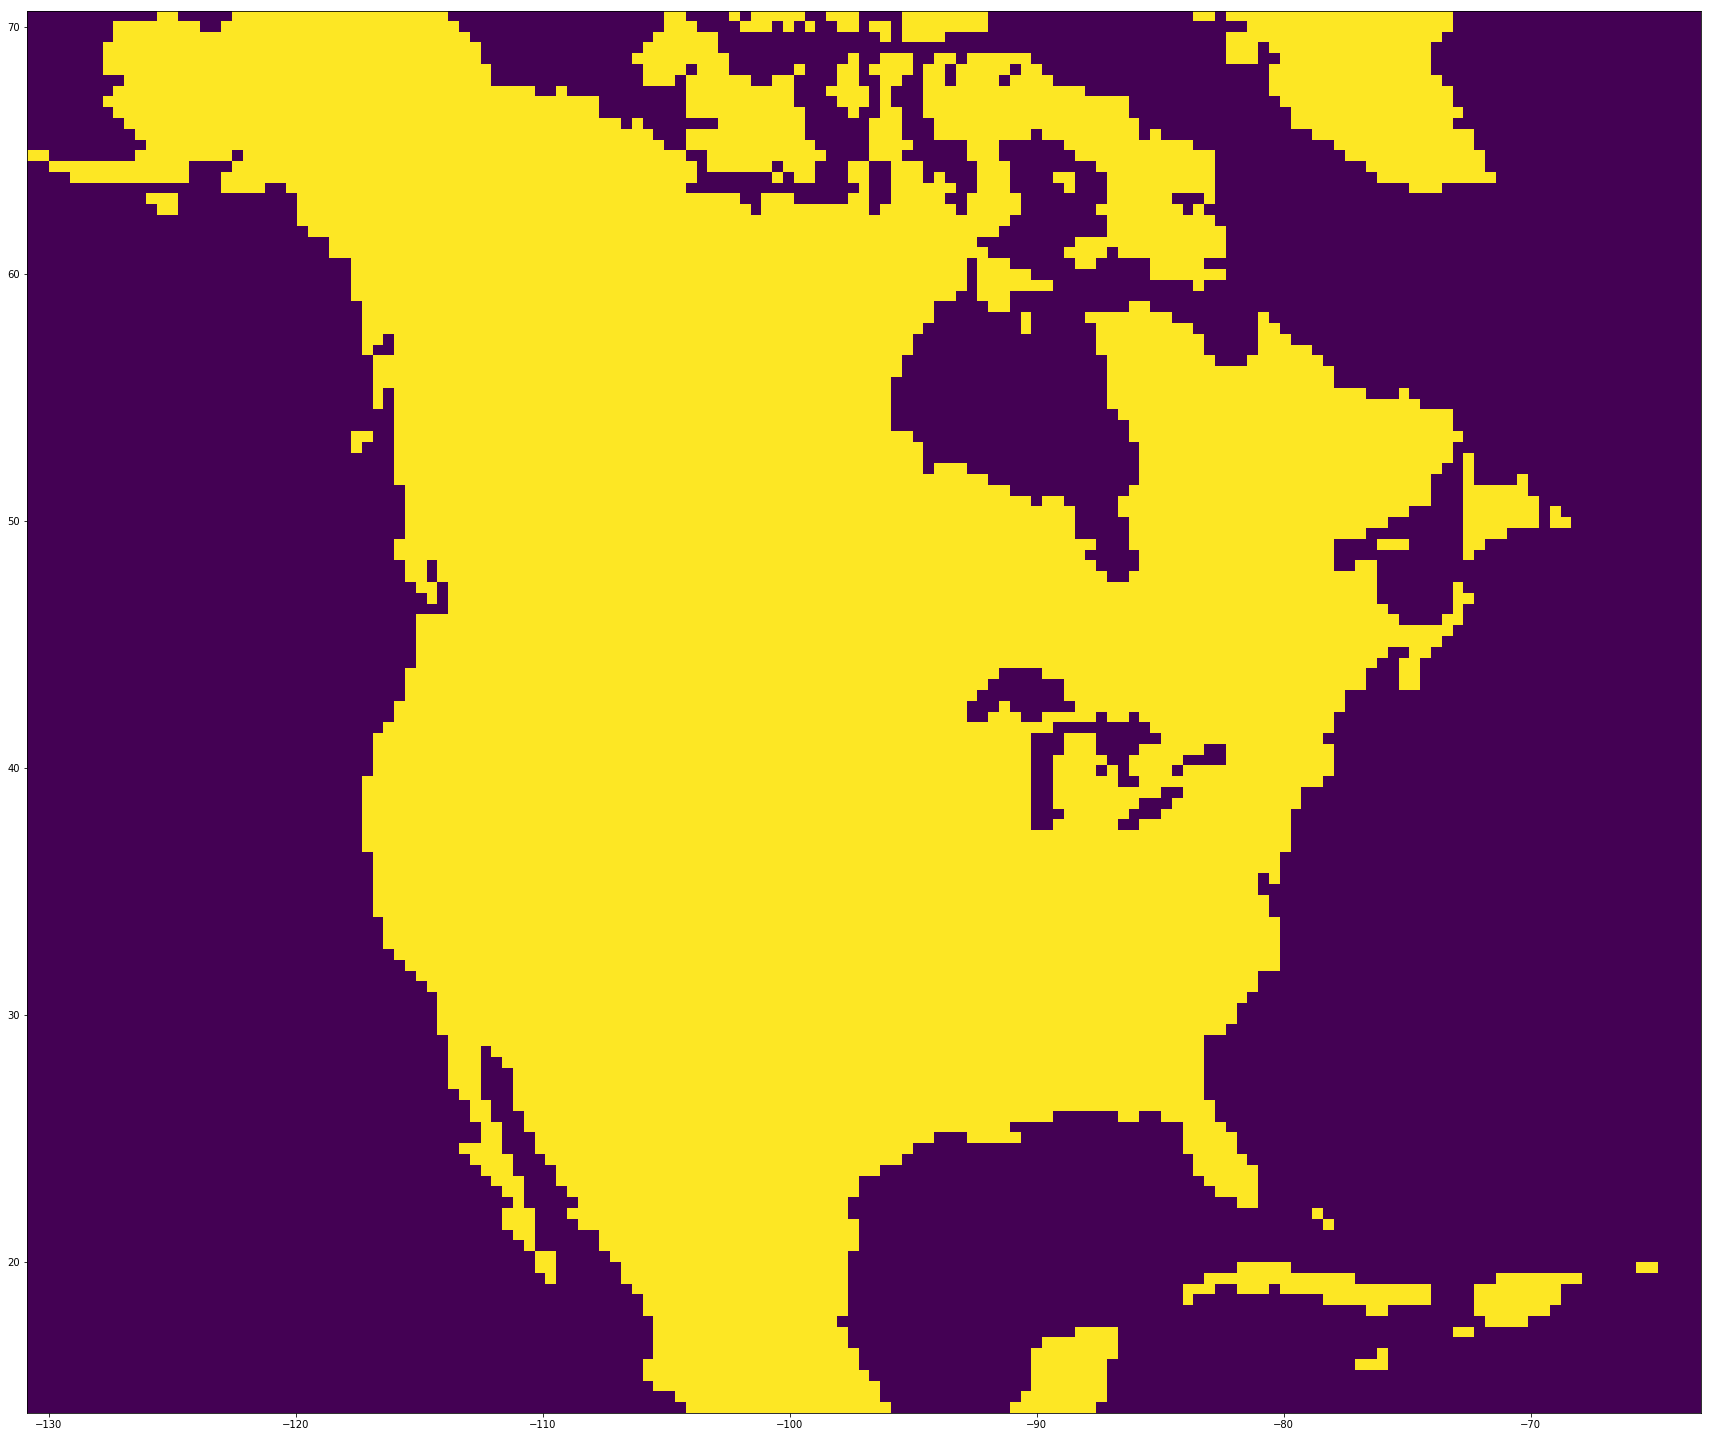

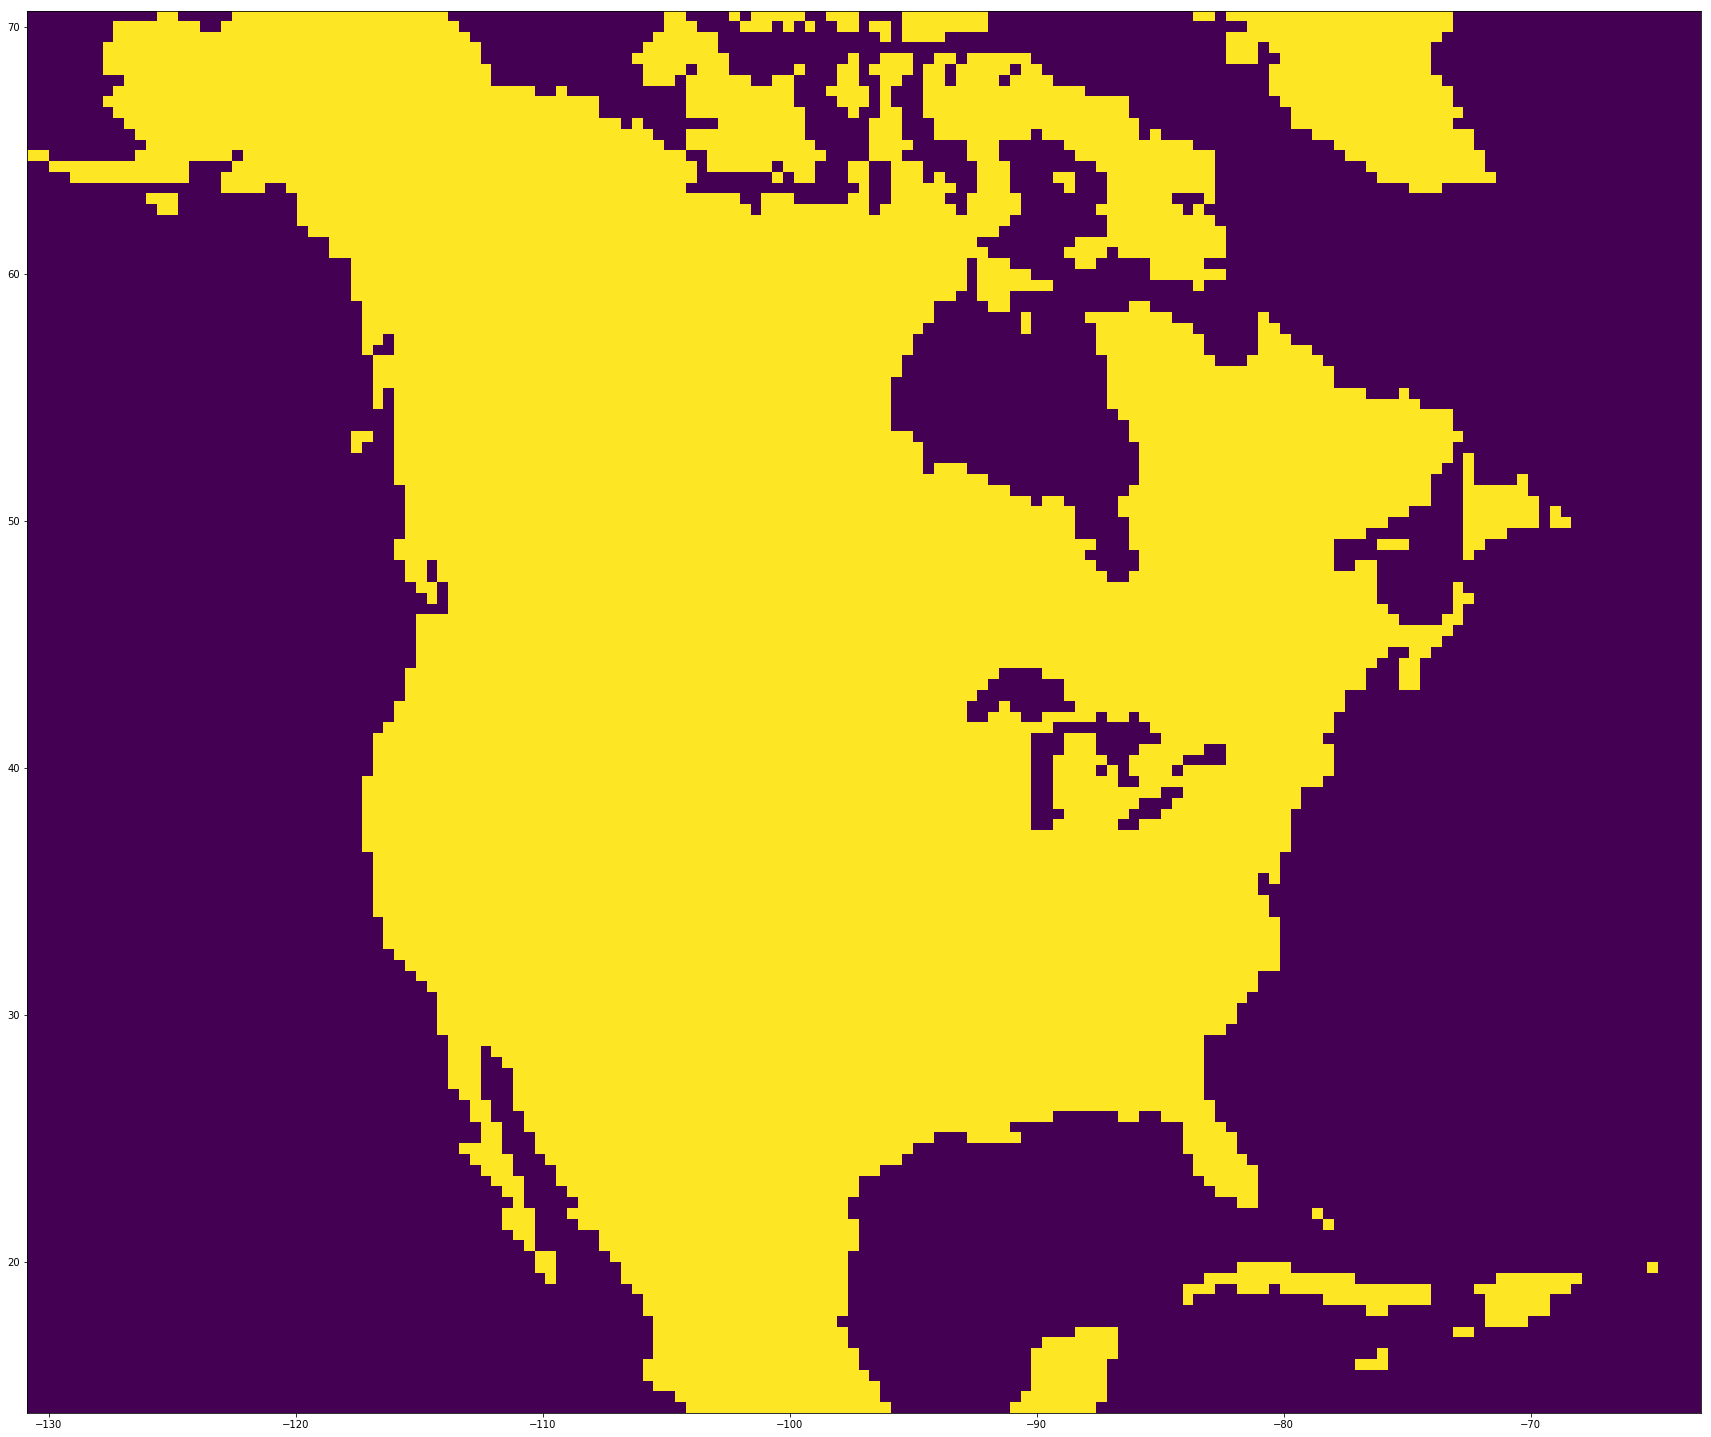

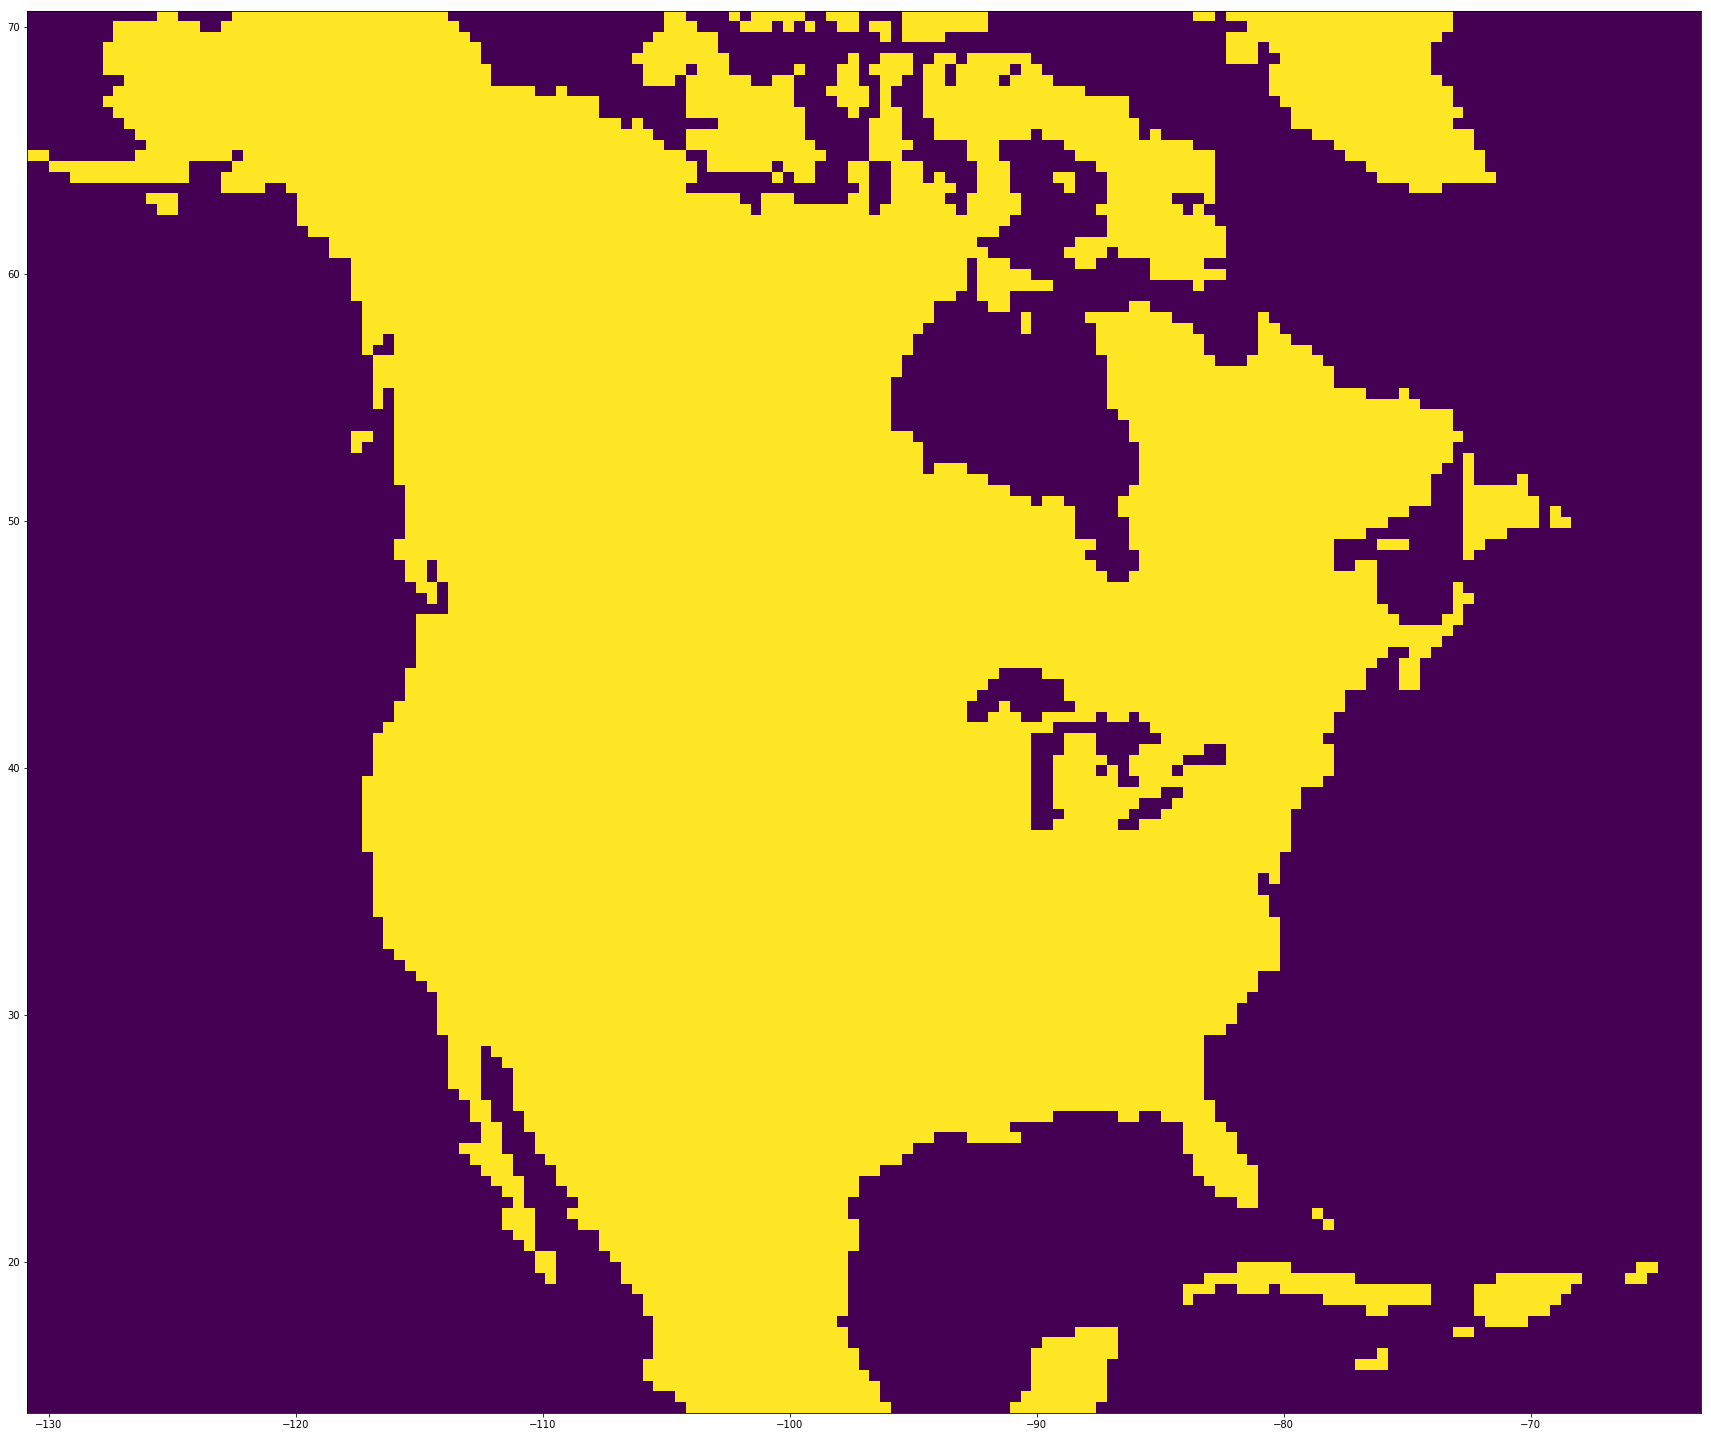

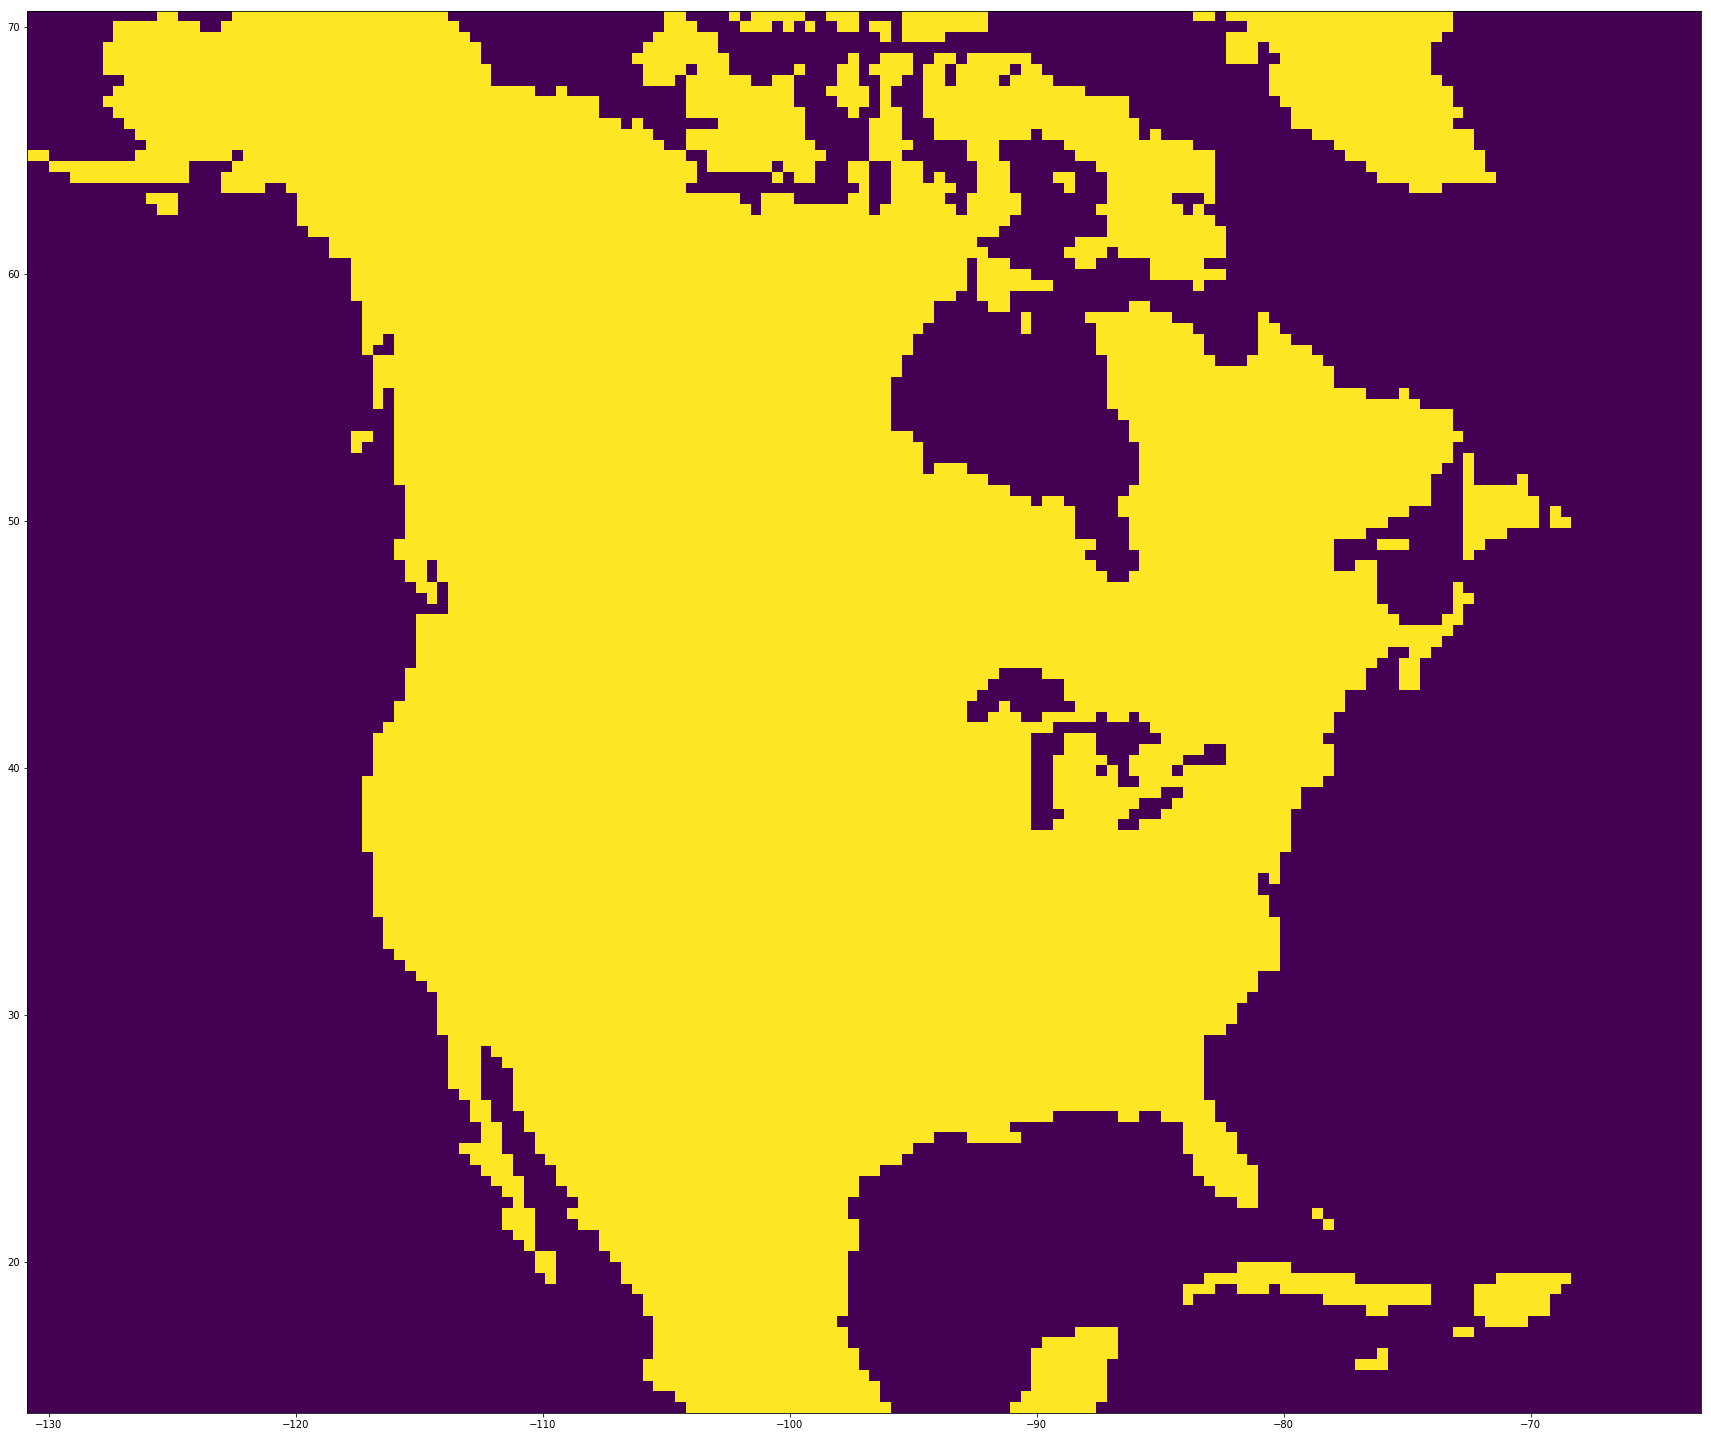

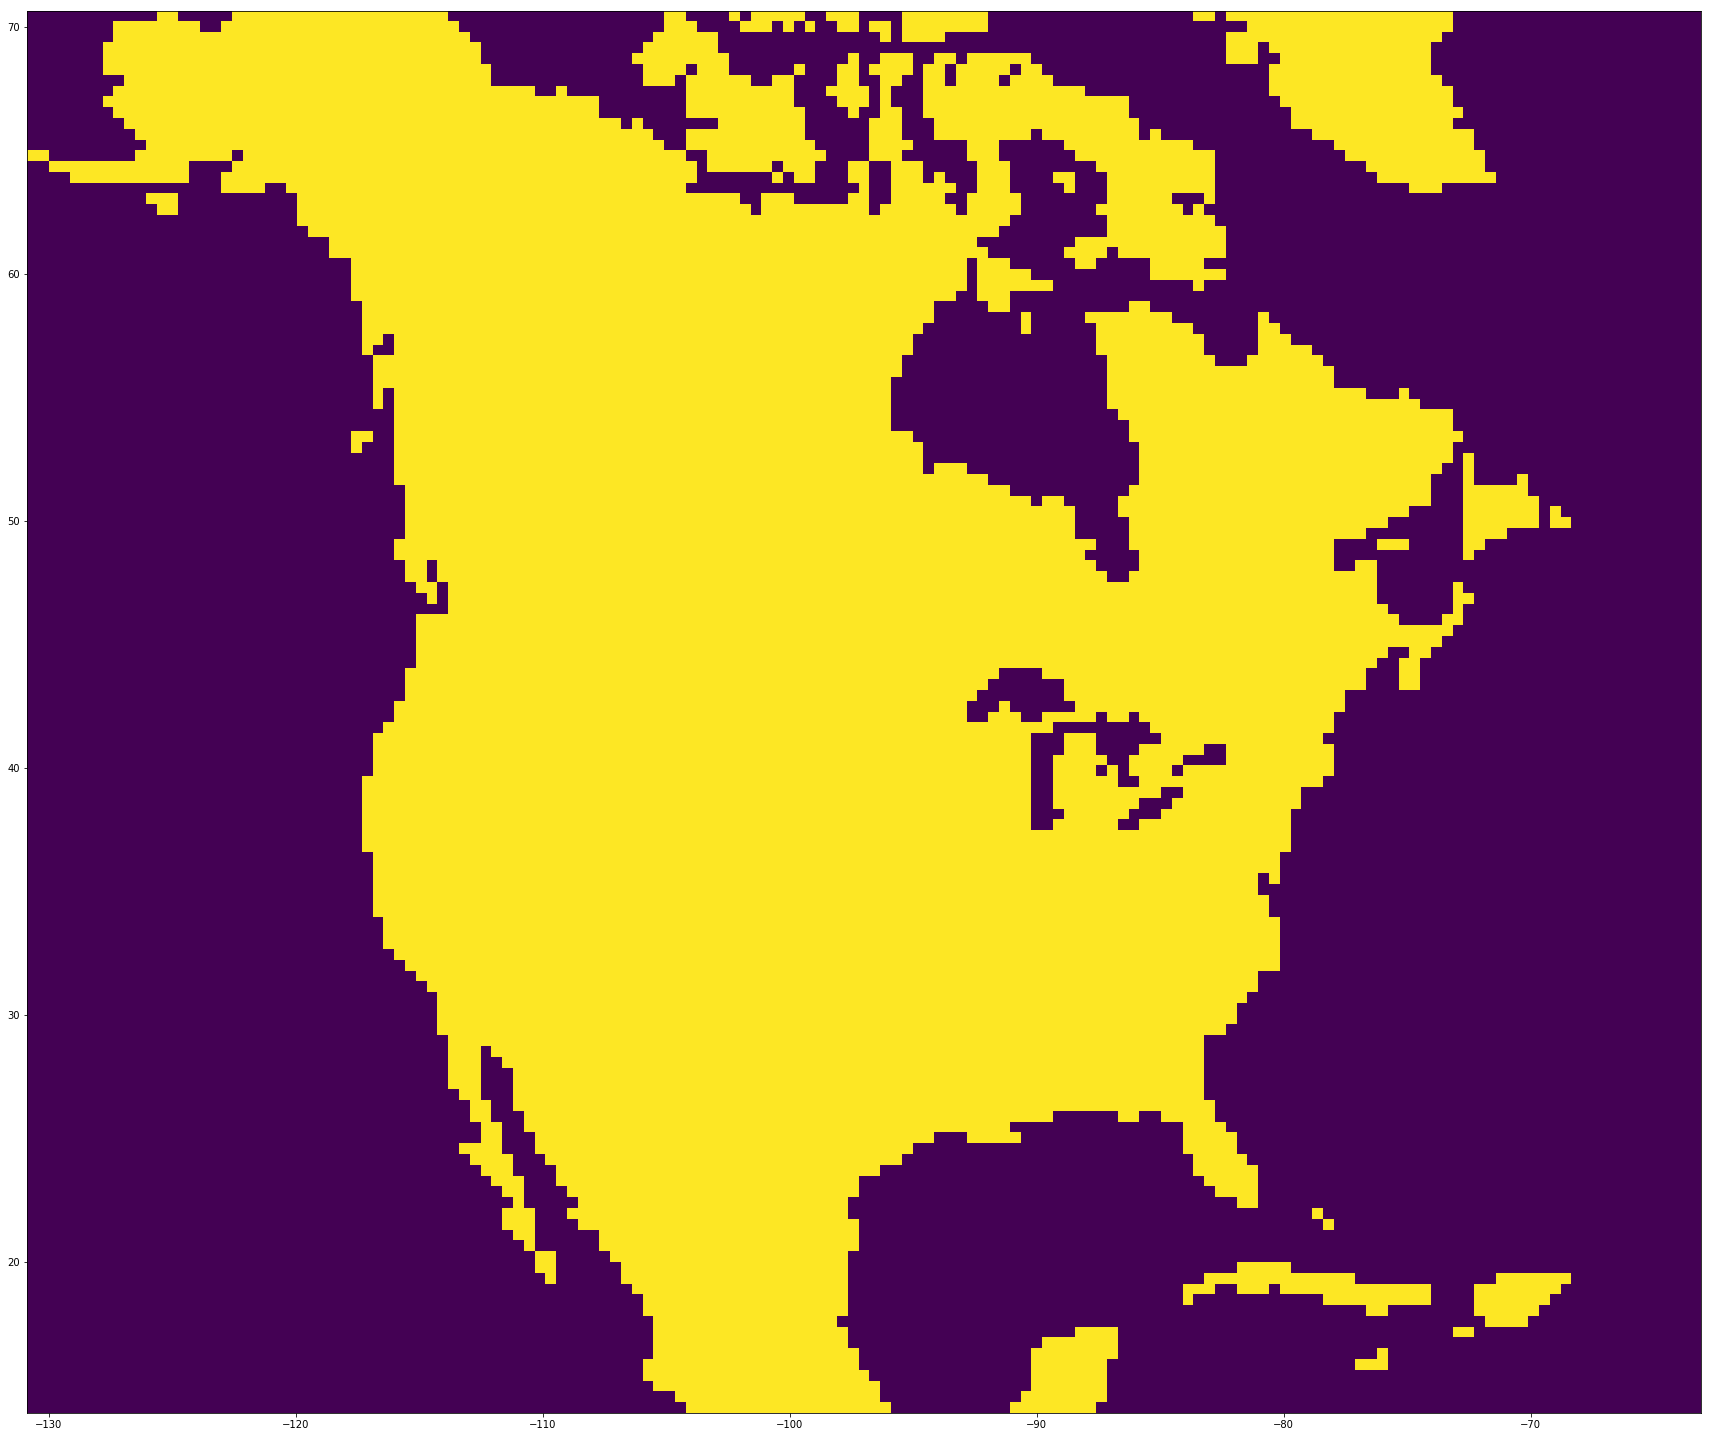

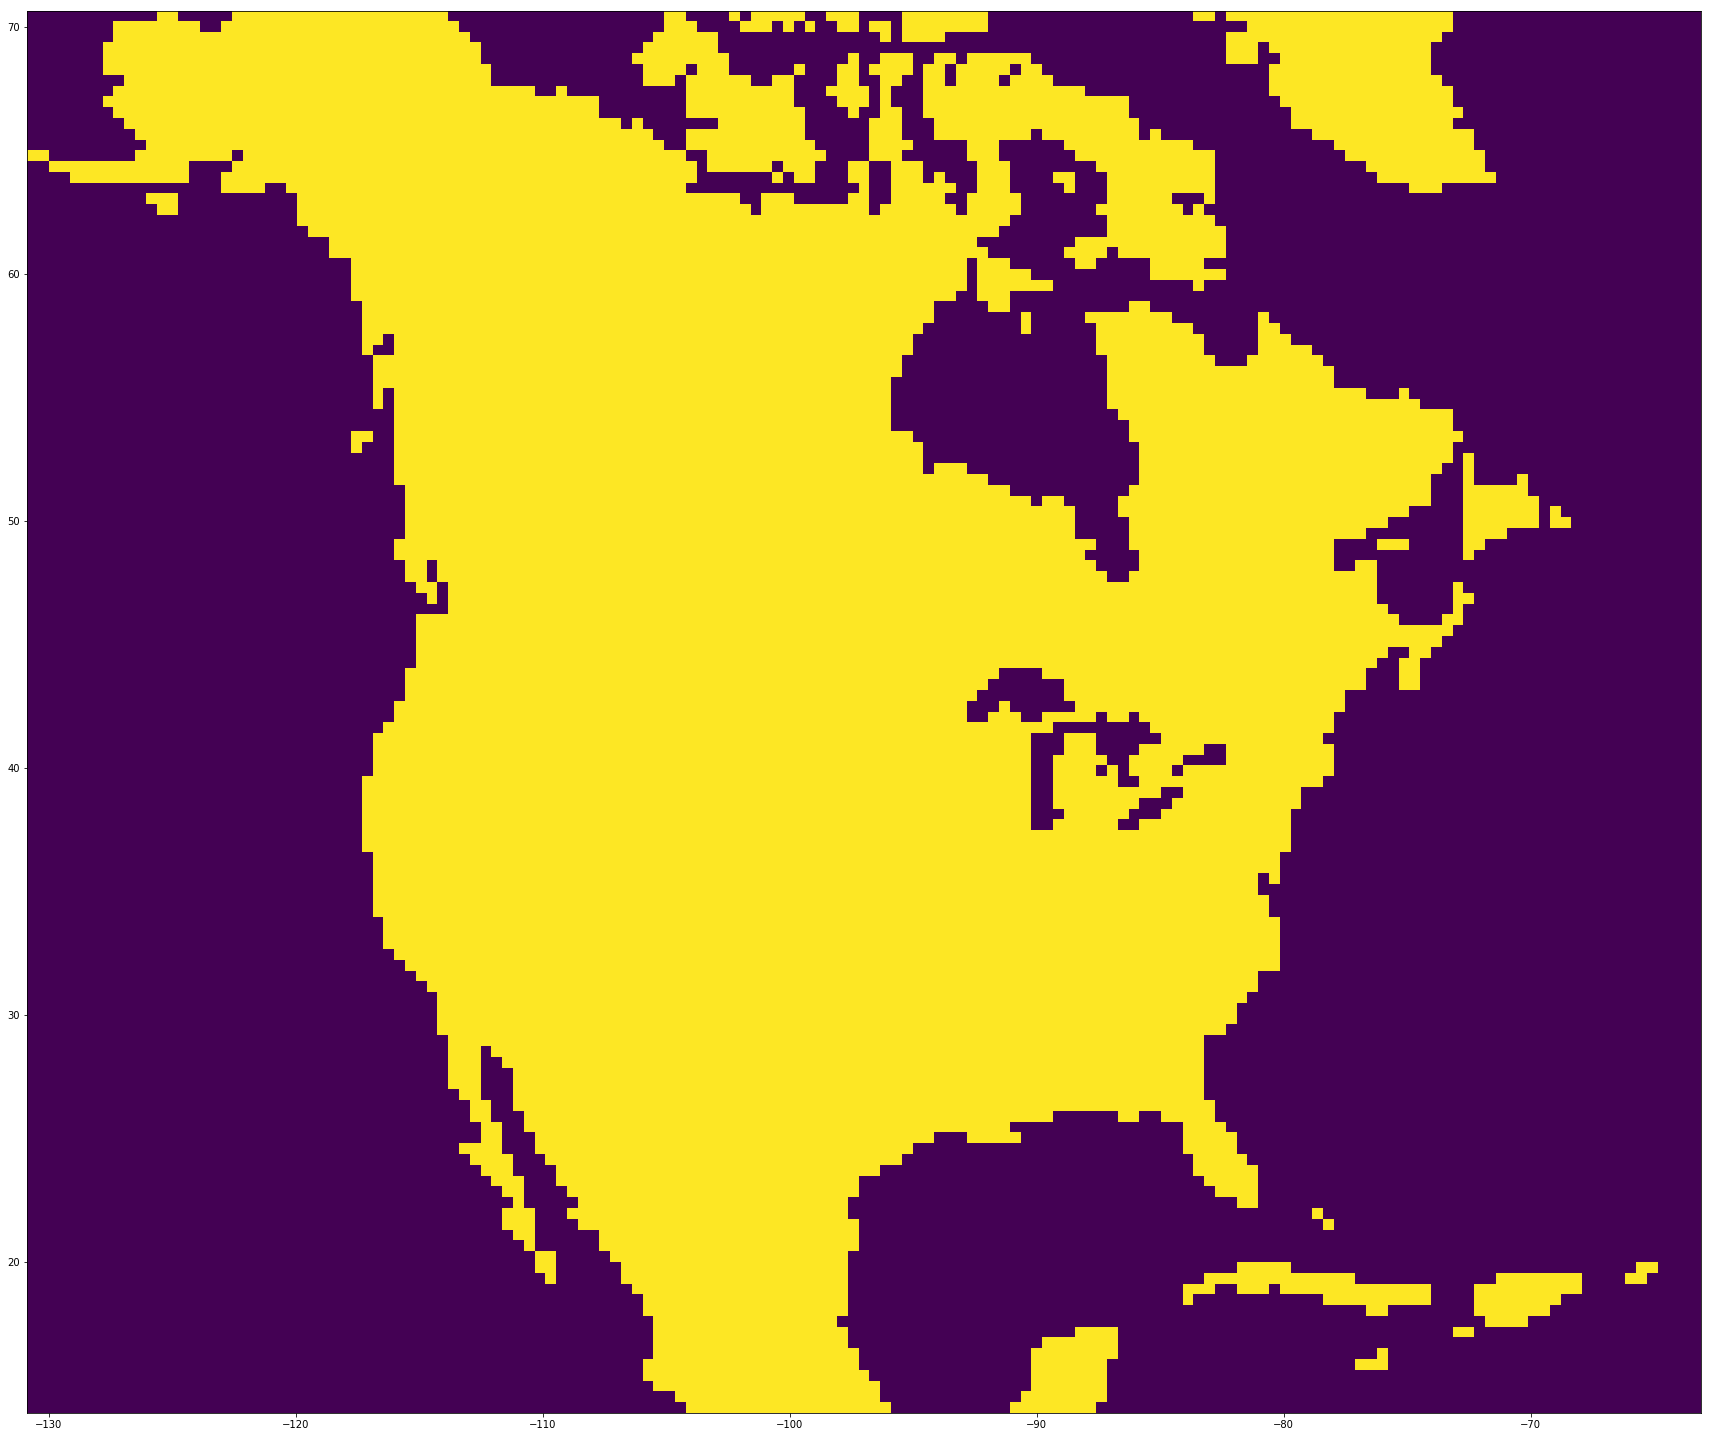

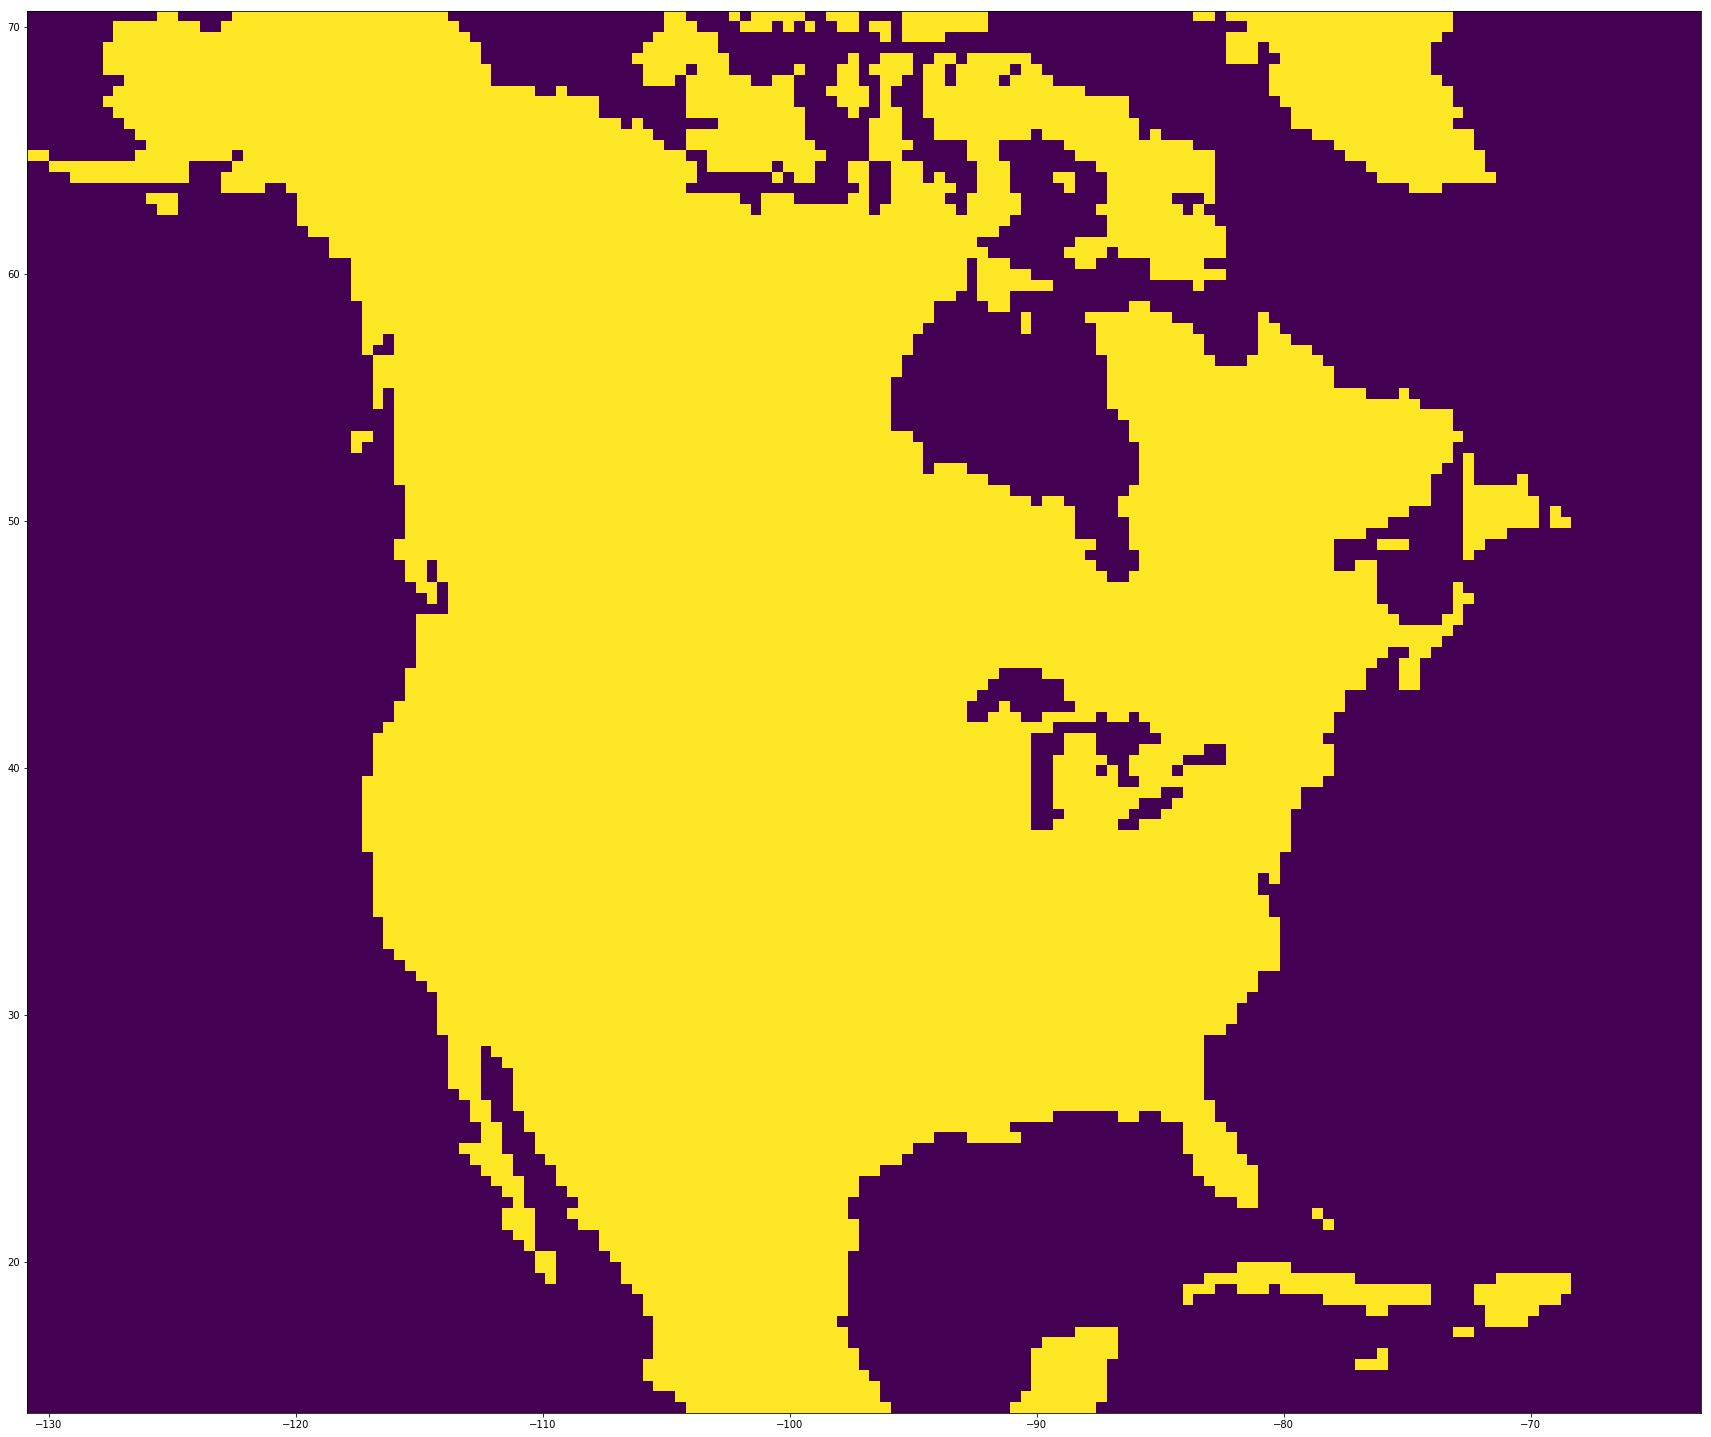

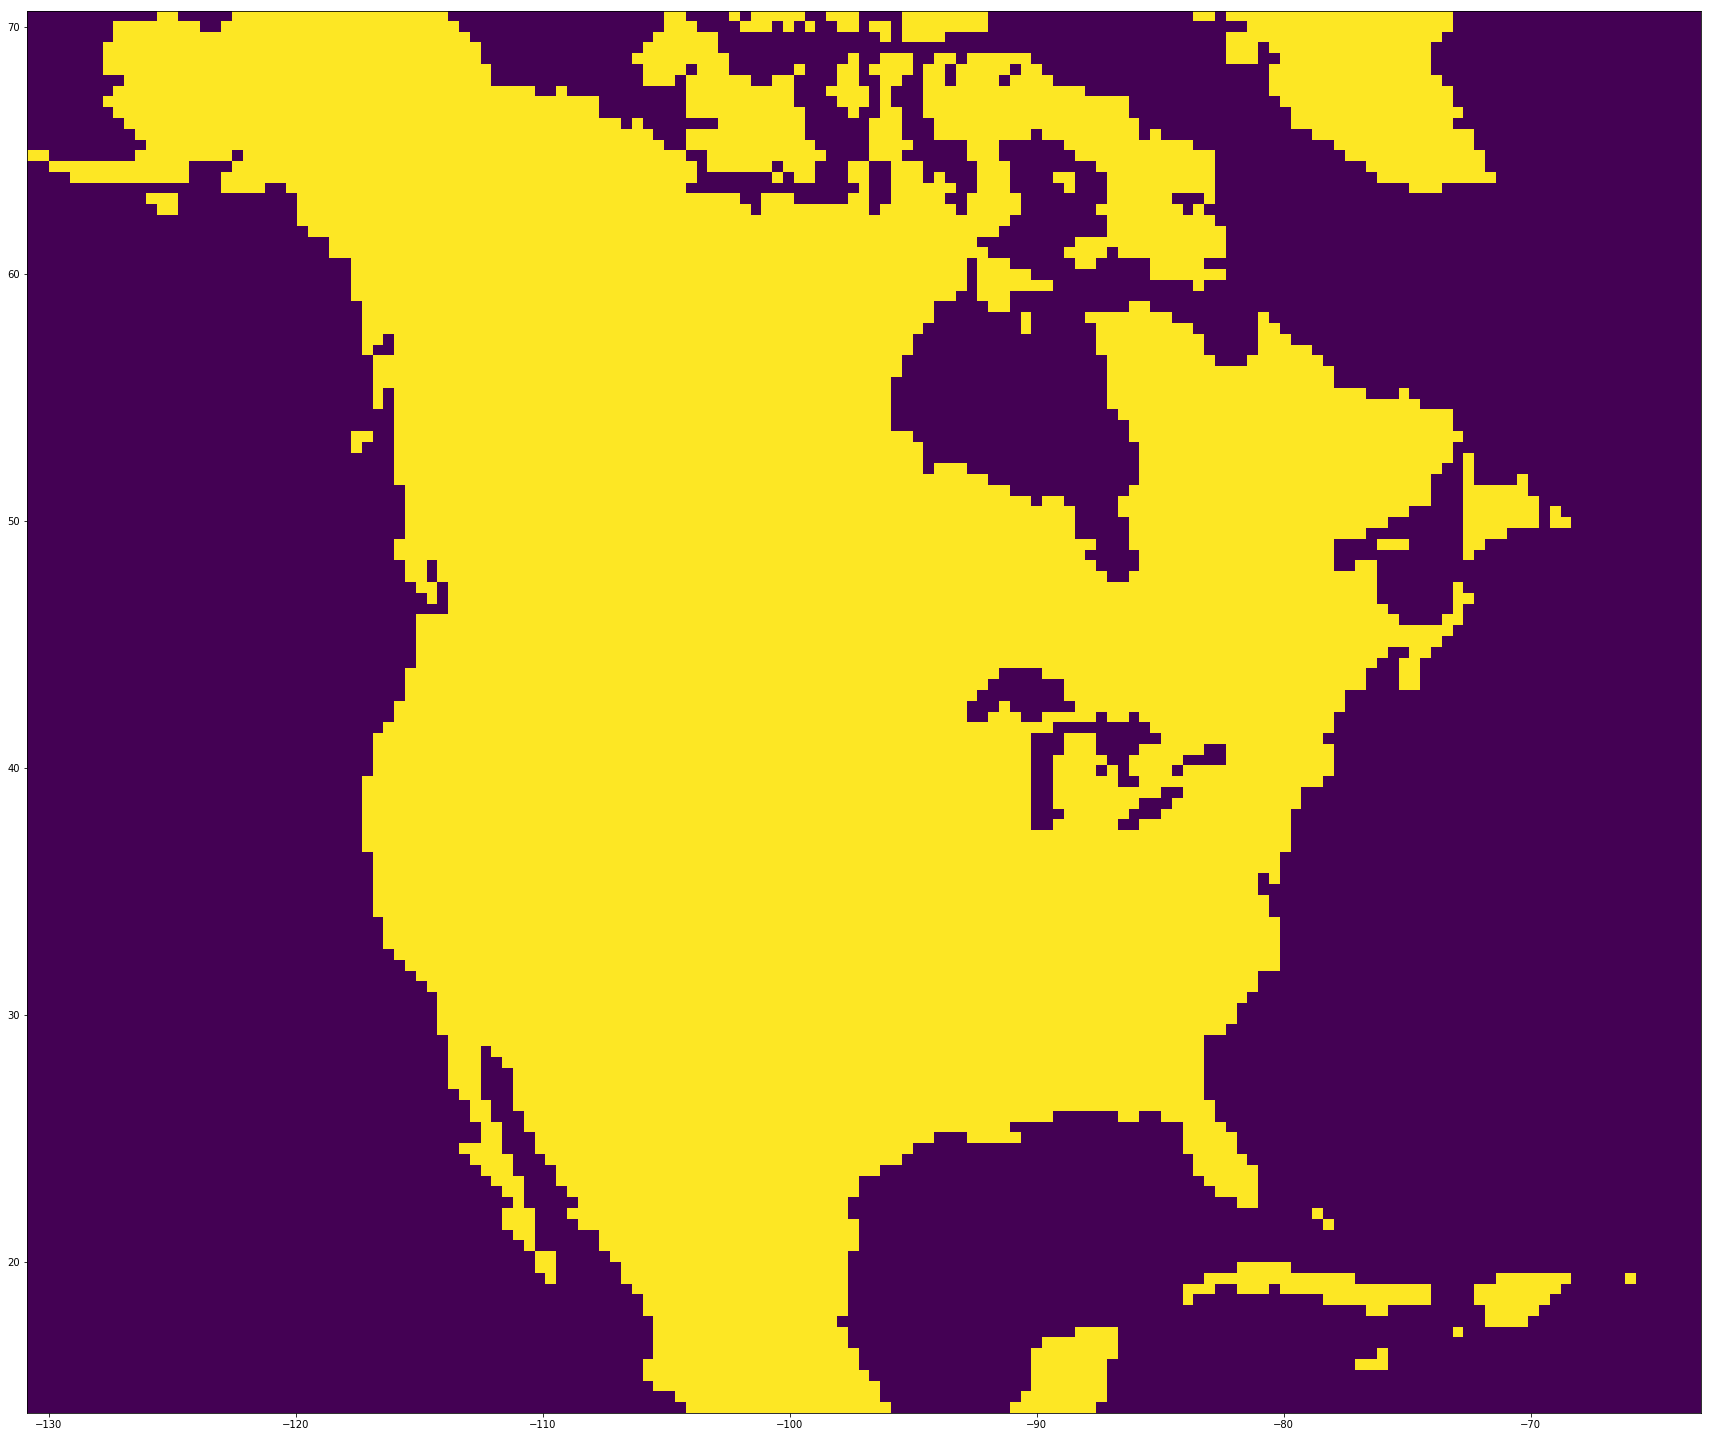

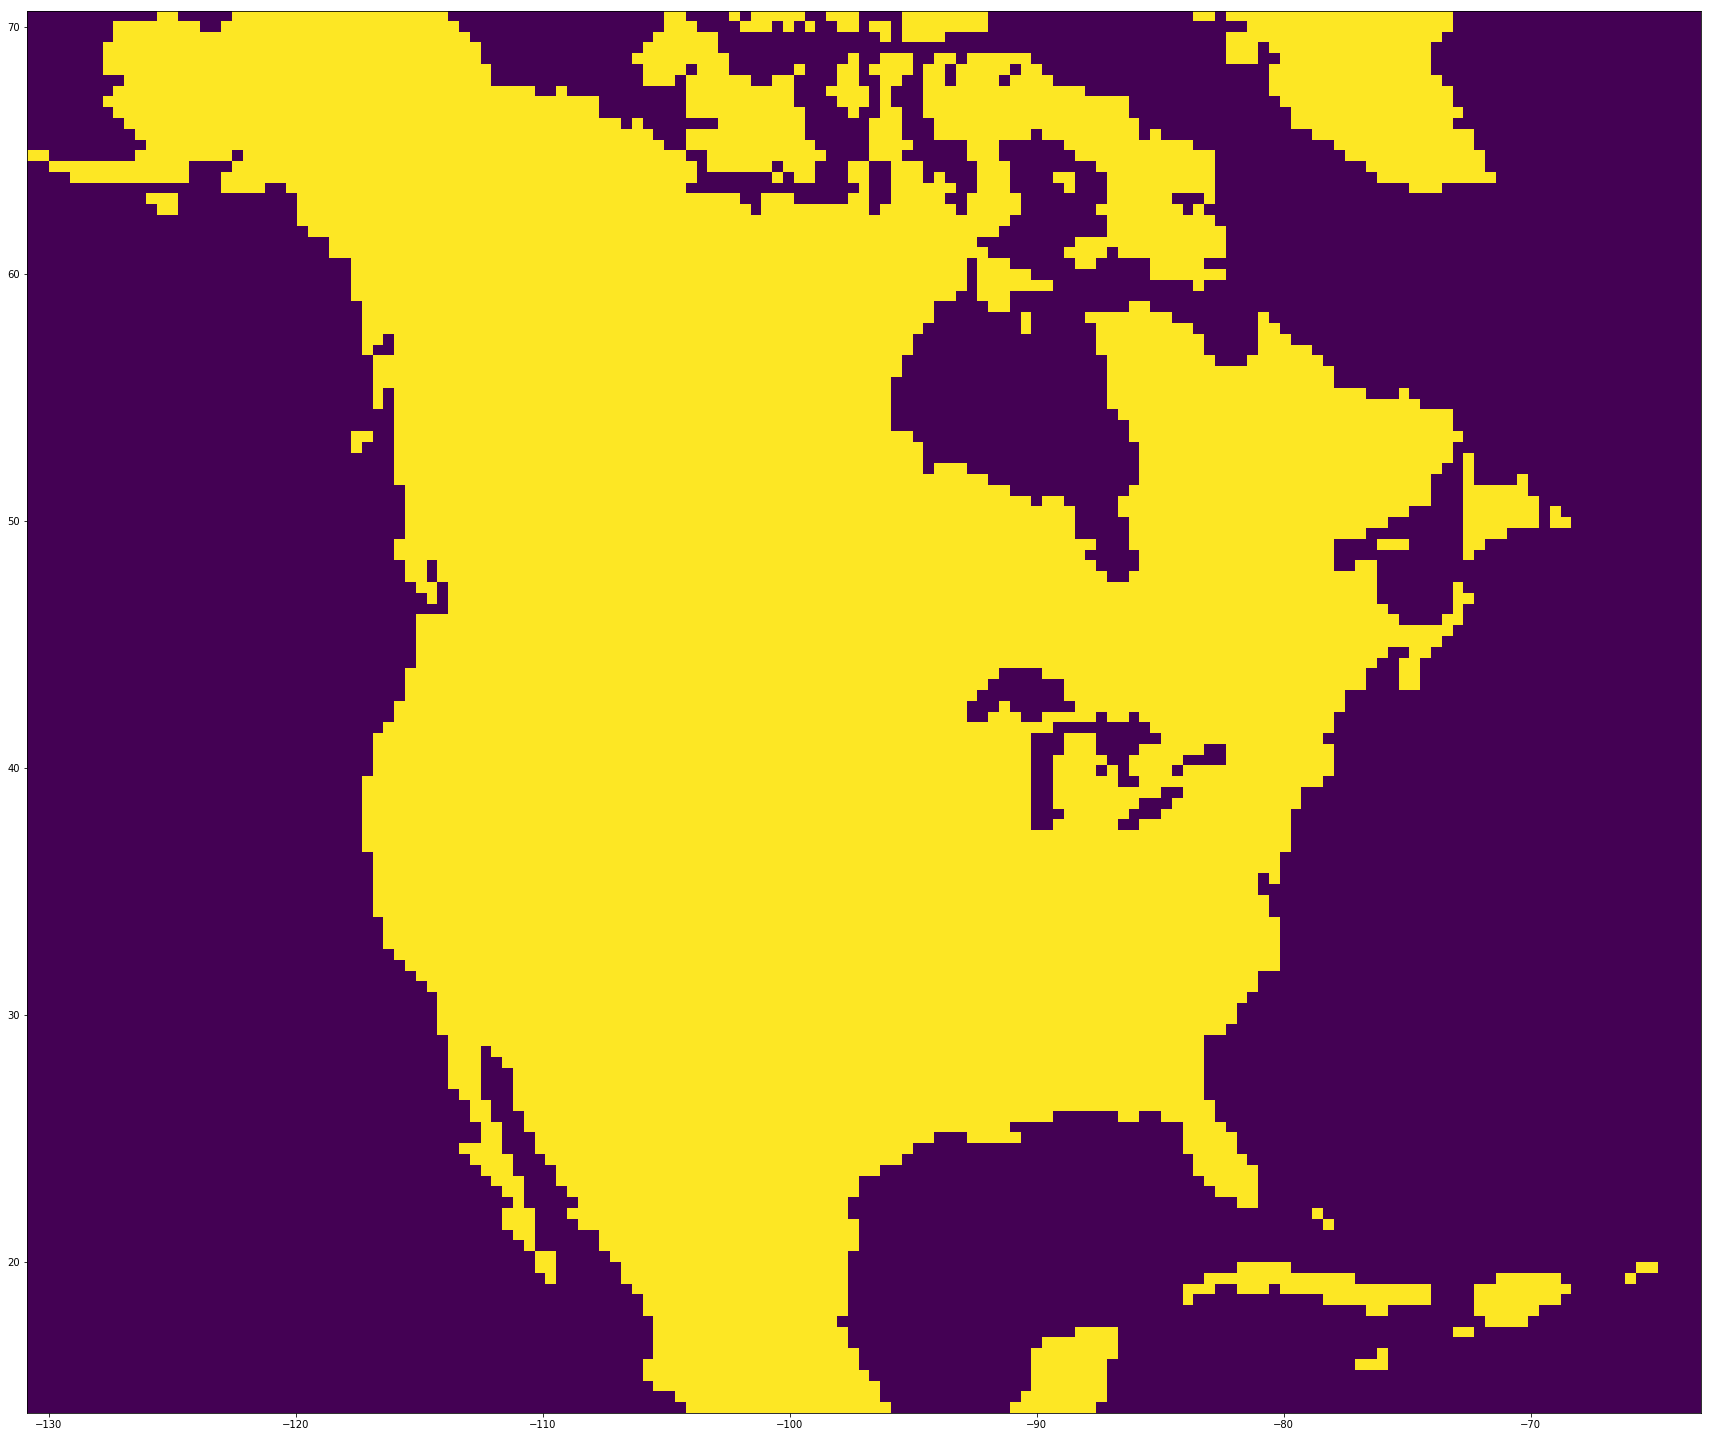

'plt.imshow(mask[0, ...], alpha=0.8, extent=[\n                                np.amin(dv_lon), \n                                np.amax(dv_lon),\n                                np.amax(dv_lat),\n                                np.amin(dv_lat)])'

In [218]:
from mapper import *

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (30, 45))
#ax = plt.axes(projection=rp())
#ax.coastlines(resolution='10m')

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'
for i in range(0, 34):
    fig = plt.figure(figsize = (30, 45))
    plt.imshow(mask_master[i, ...], extent=[
                                    np.amin(dv_lon), 
                                    np.amax(dv_lon),
                                    np.amax(dv_lat),
                                    np.amin(dv_lat)])
    plt.gca().invert_yaxis()
    plt.show()

"""fig = plt.figure(figsize = (30, 45))
ax = plt.axes(projection=rp())
ax.coastlines(resolution='10m')

ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

plt.imshow(mask_master[0, ...], extent=[
                                np.amin(dv_lon), 
                                np.amax(dv_lon),
                                np.amax(dv_lat),
                                np.amin(dv_lat)])
plt.gca().invert_yaxis()
plt.show()

"""
"""plt.imshow(mask[0, ...], alpha=0.8, extent=[
                                np.amin(dv_lon), 
                                np.amax(dv_lon),
                                np.amax(dv_lat),
                                np.amin(dv_lat)])"""
#ens[idx_arr[x, y]]
#ens_matched_cells = np.isin(mask_corr_dict['idx'], idx_arr[x, y])
#np.where(ens_matched_cells == True)[0].shape

#mask_corr_dict['idx'], np.sort(idx_arr[y, x])
#idx_list
#obs = df['quantile']*area_flat[ens_matched_cells][:, 0]

In [213]:
dv_field = ds['dv']

mean = ens_mean(dv_field)
area = frac_grid_area(dv_field)

mask = mask_flat(dv_field, mask_nan(dv_field))

# area weighted ens to get obs
ens_obs = ens_flat(dv_field*area)

# mask
ens_obs = ens_obs[:, ~mask.mask]

# get random ens to generate
# the pseudo obs
obs = get_obs(ens_obs)
obs_idx = rand_sample_index(obs, 0.02)
obs_sample = obs[obs_idx]

ens = ens_flat(dv_field*area - mean)
ens = ens[:, ~mask.mask]
ens = ens_to_eof(ens.T)[:, 0]
ens_obs = ens[obs_idx]
model = regress_eof(ens_obs, obs_sample)
pred_flat = predict_dv(model, ens)

pred = pred_to_grid(dv_field, pred_flat, mask_nan(dv_field))
pred = (pred/area + mean)

pred.shape

plt.scatter(obs, pred_flat, marker='+',s=1.5, alpha = 0.15)
plt.plot(np.linspace(-0.000, 0.0005, 10),
         np.linspace(-0.000, 0.0005, 10), 'r')
plt.xlim(0.0, 0.0007)
plt.ylim(0.0, 0.0007)
plt.title("Observations vs. Reconstructed Observations")
plt.xlabel("CanRCM4 Field Value")
plt.ylabel("Predicted Observations")
plt.savefig("plots/obs_reonstructed.pdf")

NameError: name 'mask_nan' is not defined

In [ ]:
y = get_obs(ds)
ensemble = ensemble_reshape(ds)
ensemble.shape

In [133]:
ensemble_eof = ensemble_to_eof(ensemble)

ens_cross_eof = ensemble_eof[index, :] 

model = regress_eof(ens_cross_eof, y)
predictions = predict_dv(model, ensemble_eof)

ds_eof = reconstruct_eof_full(predictions, ds)

(35, 124, 149)
(35, 124, 149)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<xarray.DataArray 'eofs' (eofs: 18476)>
array([     nan,      nan, 0.000278, ...,      nan,      nan, 0.000135])
Coordinates:
  * eofs     (eofs) float64 nan nan 0.0002782 nan ... nan nan 0.0001347

In [91]:
fit_transform(ds)

Model score: 0.6725304497264397


<xarray.Dataset>
Dimensions:  (eofs: 18476, rlat: 124, rlon: 149, run: 35)
Coordinates:
  * rlon     (rlon) float64 -32.56 -32.12 -31.68 -31.24 ... 31.68 32.12 32.56
  * rlat     (rlat) float64 -27.28 -26.84 -26.4 -25.96 ... 25.96 26.4 26.84
  * eofs     (eofs) float64 nan nan 9.58e-10 nan ... nan nan 4.373e-10
Dimensions without coordinates: run
Data variables:
    lon      (run, rlat, rlon) float64 233.5 233.8 234.2 ... 332.0 332.5 333.0
    lat      (run, rlat, rlon) float64 14.04 14.2 14.36 ... 59.87 59.56 59.26
    dv       (run, rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Author:        Chao Li @ PCIC - chaoli@uvic.ca
    Institution:   Pacific Climate Impacts Consortium
    Date created:  Tue Aug 28 00:13:00 2018

ValueError: x and y must be the same size

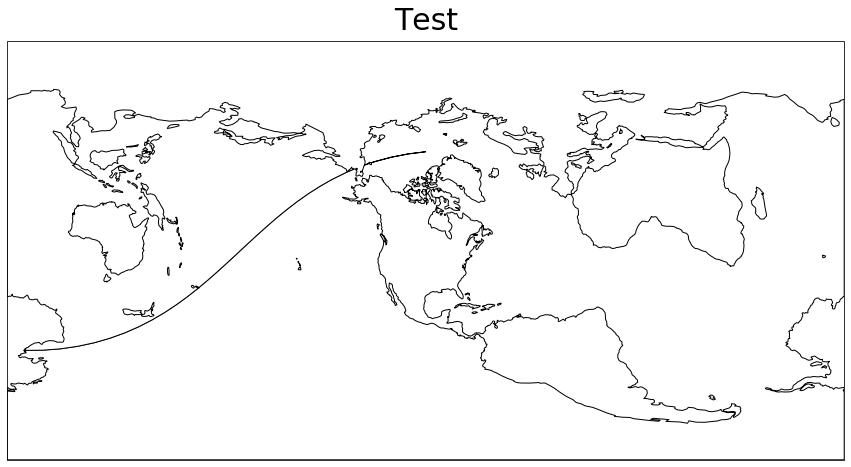

In [97]:
from mapper import *

plot_reference(ds, 'Test')